In [4]:
# -*- coding:utf-8 -*-
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from collections import defaultdict
import xgboost as xgb
import joblib
import ast
import os
import glob
import json
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report
import datetime as dt
from connectors.sql import *
import tensorflow as tf
import connectors.sql as Q
from datetime import datetime, timedelta
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
plt.rcParams['font.sans-serif'] = ['SimHei'] # 步骤一（替换sans-serif字体）
plt.rcParams['axes.unicode_minus'] = False   # 步骤二（解决坐标轴负数的负号显示问题）
%matplotlib inline
pd.set_option('display.float_format', lambda x: '%.4f' % x)

seed = 42
np.random.seed(seed)
engine = create_presto_engine("daiyuxuan")
import sys

from scipy import stats

#显示所有列
pd.set_option('display.max_columns', None)

#显示所有行
pd.set_option('display.max_rows', None)

#设置value的显示长度为100，默认为50
pd.set_option('max_colwidth',500)

2025-02-28 17:21:33.961342: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2025-02-28 17:21:33.961407: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# 基础函数&配置

In [2]:
# 计算GAUC
def cal_gauc(labels, preds, user_id_list):
    labels = labels.tolist()
    preds = preds.tolist()
    user_id_list = user_id_list.tolist()
    if len(user_id_list) != len(labels):
        raise ValueError(
            "impression id num should equal to the sample num,impression id num is {0},but sample num is {1}".format(
                len(user_id_list), len(labels)))
    group_score = defaultdict(lambda: [])
    group_truth = defaultdict(lambda: [])
    for idx, truth in enumerate(labels):
        user_id = user_id_list[idx]
        score = preds[idx]
        truth = labels[idx]
        group_score[user_id].append(score)
        group_truth[user_id].append(truth)
    group_flag = defaultdict(lambda: False)
    for user_id in set(user_id_list):
        truths = group_truth[user_id]
        flag = False
        for i in range(len(truths) - 1):
            if truths[i] != truths[i + 1]:
                flag = True
                break
        group_flag[user_id] = flag
    impression_total = 0
    total_auc = 0
    for user_id in group_flag:
        if group_flag[user_id]:
            auc = roc_auc_score(np.asarray(group_truth[user_id]), np.asarray(group_score[user_id]))
            total_auc += auc * len(group_truth[user_id])
            impression_total += len(group_truth[user_id])
    if impression_total == 0:
        return 0.5  # 或者返回一个适当的默认值
    group_auc = float(total_auc) / impression_total
    group_auc = round(group_auc, 4)
    return group_auc

In [3]:
# sparse_user_feature = ["s_u_click_tag_id_0_7", "s_u_click_seats_0_7", "s_u_click_minor_category_id_0_7",
#                        "s_u_click_guobie_0_7", "s_u_click_gearbox_0_7", "s_u_click_fuel_type_0_7",
#                        "s_u_click_emission_standard_0_7", "s_u_click_city_id_0_7", "s_u_click_car_year_0_7",
#                        "s_u_click_auto_type_0_7", "s_u_click_car_color_0_7", "s_u_click_evaluate_level_segment_0_7",
#                        "s_u_click_evaluate_score_segment_0_7", "s_u_click_model_price_bin_0_7", "s_u_bid_tag_id_0_7",
#                        "s_u_bid_seats_0_7", "s_u_bid_minor_category_id_0_7", "s_u_bid_guobie_0_7",
#                        "s_u_bid_gearbox_0_7", "s_u_bid_fuel_type_0_7", "s_u_bid_emission_standard_0_7",
#                        "s_u_bid_city_id_0_7", "s_u_bid_car_year_0_7", "s_u_bid_auto_type_0_7", "s_u_bid_car_color_0_7",
#                        "s_u_bid_evaluate_level_segment_0_7", "s_u_bid_evaluate_score_segment_0_7",
#                        "s_u_bid_model_price_bin_0_7", "s_u_deal_tag_id_0_30", "s_u_deal_seats_0_30",
#                        "s_u_deal_minor_category_id_0_30", "s_u_deal_guobie_0_30", "s_u_deal_gearbox_0_30",
#                        "s_u_deal_fuel_type_0_30", "s_u_deal_emission_standard_0_30", "s_u_deal_city_id_0_30",
#                        "s_u_deal_car_year_0_30", "s_u_deal_auto_type_0_30", "s_u_deal_car_color_0_30",
#                        "s_u_deal_tag_id_0_365", "s_u_deal_seats_0_365", "s_u_deal_minor_category_id_0_365",
#                        "s_u_deal_guobie_0_365", "s_u_deal_gearbox_0_365", "s_u_deal_fuel_type_0_365",
#                        "s_u_deal_emission_standard_0_365", "s_u_deal_city_id_0_365", "s_u_deal_car_year_0_365",
#                        "s_u_deal_auto_type_0_365", "s_u_deal_car_color_0_365", "user_id"]
# dense_user_feature = ["d_u_beseen_cnt_0_7", "d_u_beseen_cnt_7_14", "d_u_beseen_cnt_14_30", "d_u_click_cnt_0_7",
#                       "d_u_click_cnt_7_14", "d_u_click_cnt_14_30", "d_u_bid_cnt_0_7", "d_u_bid_cnt_7_14",
#                       "d_u_bid_cnt_14_30", "d_u_collect_cnt_0_7", "d_u_collect_cnt_7_14", "d_u_collect_cnt_14_30",
#                       "d_u_contract_cnt_30", "d_u_contract_cnt_365", "d_u_click_suggest_price_max_0_30",
#                       "d_u_click_suggest_price_min_0_30", "d_u_click_suggest_price_median_0_30",
#                       "d_u_click_road_haul_max_0_30", "d_u_click_road_haul_min_0_30", "d_u_click_road_haul_median_0_30",
#                       "d_u_click_evaluate_score_max_0_30", "d_u_click_evaluate_score_min_0_30",
#                       "d_u_click_evaluate_score_median_0_30", "d_u_bid_suggest_price_max_0_30",
#                       "d_u_bid_suggest_price_min_0_30", "d_u_bid_suggest_price_median_0_30",
#                       "d_u_bid_road_haul_max_0_30", "d_u_bid_road_haul_min_0_30", "d_u_bid_road_haul_median_0_30",
#                       "d_u_bid_evaluate_score_max_0_30", "d_u_bid_evaluate_score_min_0_30",
#                       "d_u_bid_evaluate_score_median_0_30"]
# sparse_item_feature = ["s_i_c2b_evaluate_score_segment", "s_i_city_id", "s_i_emission_standard", "s_i_minor_category_id", "s_i_model_price_bin",
#                        "s_i_car_year", "s_i_gearbox", "s_i_air_displacement", "s_i_tag_id", "s_i_car_color", "s_i_guobie", "s_i_evaluate_level",
#                        "s_i_auto_type", "s_i_fuel_type", "s_i_seats", "s_i_c2b_ctob_car_level"]

# dense_item_feature = ["d_i_c2b_offline_car_click_bid_rate_0_3_d", "d_i_c2b_offline_car_click_bid_rate_0_30_d", "d_i_c2b_offline_car_beseen_click_rate_0_3_d",
#                       "d_i_c2b_offline_car_beseen_click_rate_0_30_d", "d_i_c2b_offline_car_tag_id_bid_percent_ratio_0_7_d", "d_i_c2b_offline_car_tag_id_bid_percent_ratio_7_14_d",
#                       "d_i_c2b_offline_car_tag_id_bid_percent_ratio_14_30_d", "d_i_c2b_offline_car_tag_id_click_rate_0_7_d", "d_i_c2b_offline_car_tag_id_click_rate_7_14_d",
#                       "d_i_c2b_offline_car_tag_id_quick_collection_rate_0_7_d", "d_i_c2b_offline_car_tag_id_quick_collection_rate_7_14_d", "d_i_c2b_offline_car_tag_id_bid_rate_0_7_d",
#                       "d_i_c2b_offline_car_tag_id_bid_rate_7_14_d", "d_i_c2b_offline_car_minor_category_id_click_rate_0_7_d", "d_i_c2b_offline_car_minor_category_id_quick_collection_rate_0_7_d",
#                       "d_i_c2b_offline_car_minor_category_id_quick_collection_rate_7_14_d", "d_i_transfer_num", "d_i_c2b_evaluate_score", "d_i_c2b_ctob_model_price",
#                       "d_i_c2b_seller_price", "d_i_c2b_ctob_diff_price", "d_i_road_haul"]

# sparse_fea = sparse_user_feature + sparse_item_feature
# dense_fea = dense_user_feature + dense_item_feature
# user_fea = sparse_user_feature + dense_user_feature
# item_fea = sparse_item_feature + dense_item_feature
# total_fea = sparse_user_feature + dense_user_feature + sparse_item_feature + dense_item_feature  # 注意按顺序

# 保存新样本

In [78]:
# start_date = '2024-09-01'
# last_date = '2024-11-30'
start_date = '2024-12-15'
last_date = '2024-12-15'
samples_data_sql = f"""
    select *
    from g3_feature_dev.c2b_dssm_samples_search_step3  
    where dt between '{start_date}' and '{last_date}'
    -- limit 1
"""
samples_data = pd.read_sql_query(samples_data_sql, engine)


In [79]:
# 将空字符串替换为 NaN
samples_data.replace('', np.nan, inplace=True)

# 计算各列的缺失率
missing_rate = samples_data.isnull().mean()

# 显示结果
print("Missing rate for each column:")
print(missing_rate)

Missing rate for each column:
user_id                                                  0.0000
clue_id                                                  0.0000
recommend_id                                             0.0000
label                                                    0.0000
ts                                                       0.0000
s_i_c2b_evaluate_score_segment                           0.0000
s_i_city_id                                              0.0000
s_i_emission_standard                                    0.0000
s_i_minor_category_id                                    0.0000
s_i_model_price_bin                                      0.0000
s_i_car_year                                             0.0000
s_i_gearbox                                              0.0000
s_i_air_displacement                                     0.0000
s_i_tag_id                                               0.0000
s_i_car_color                                            0.0000
s_i_guobie

In [80]:
# 确保目录存在
output_dir = '/home/jupyterhub/daiyuxuan/dssm_samples_search/data_new_fea/'
os.makedirs(output_dir, exist_ok=True)

# 按 'dt' 列分组并保存每个组为单独的 CSV 文件
for dt_value, group in samples_data.groupby('dt'):
    output_file = os.path.join(output_dir, f'samples_data_{dt_value}.csv')
    group.to_csv(output_file, index=False)
    print(f"DataFrame for dt={dt_value} has been saved to {output_file}")

DataFrame for dt=2024-12-15 has been saved to /home/jupyterhub/daiyuxuan/dssm_samples_search/data_new_fea/samples_data_2024-12-15.csv


# 离线评估

In [106]:
test_date = '2024-10-27'
df_sample = pd.read_csv(f"/home/jupyterhub/daiyuxuan/dssm_models_search/inference_data/inference_{test_date}.csv", sep='\t')
score_df = pd.read_csv('/home/jupyterhub/daiyuxuan/dssm_models_search/inference_data/inner_products.csv', )
score_df['dssm_prediction'] = score_df['dssm_prediction'].apply(lambda x: ast.literal_eval(x)[0] if isinstance(x, str) else x)

In [107]:
df_sample.head()

,Unnamed: 0,clue_id,user_id,recommend_id,ts,label,s_i_c2b_evaluate_score_segment,s_i_city_id,s_i_emission_standard,s_i_minor_category_id,s_i_model_price_bin,s_i_car_year,s_i_gearbox,s_i_air_displacement,s_i_tag_id,s_i_car_color,s_i_guobie,s_i_evaluate_level,s_i_auto_type,s_i_fuel_type,s_i_seats,s_i_c2b_ctob_car_level,d_i_c2b_offline_car_click_bid_rate_0_3_d,d_i_c2b_offline_car_click_bid_rate_0_30_d,d_i_c2b_offline_car_beseen_click_rate_0_3_d,d_i_c2b_offline_car_beseen_click_rate_0_30_d,d_i_c2b_offline_car_tag_id_bid_percent_ratio_0_7_d,d_i_c2b_offline_car_tag_id_bid_percent_ratio_7_14_d,d_i_c2b_offline_car_tag_id_bid_percent_ratio_14_30_d,d_i_c2b_offline_car_tag_id_click_rate_0_7_d,d_i_c2b_offline_car_tag_id_click_rate_7_14_d,d_i_c2b_offline_car_tag_id_quick_collection_rate_0_7_d,d_i_c2b_offline_car_tag_id_quick_collection_rate_7_14_d,d_i_c2b_offline_car_tag_id_bid_rate_0_7_d,d_i_c2b_offline_car_tag_id_bid_rate_7_14_d,d_i_c2b_offline_car_minor_category_id_click_rate_0_7_d,d_i_c2b_offline_car_minor_category_id_quick_collection_rate_0_7_d,d_i_c2b_offline_car_minor_category_id_quick_collection_rate_7_14_d,d_i_transfer_num,d_i_c2b_evaluate_score,d_i_c2b_ctob_model_price,d_i_c2b_seller_price,d_i_c2b_ctob_diff_price,d_i_road_haul,d_u_beseen_cnt_0_7,d_u_beseen_cnt_7_14,d_u_beseen_cnt_14_30,d_u_click_cnt_0_7,d_u_click_cnt_7_14,d_u_click_cnt_14_30,d_u_bid_cnt_0_7,d_u_bid_cnt_7_14,d_u_bid_cnt_14_30,d_u_collect_cnt_0_7,d_u_collect_cnt_7_14,d_u_collect_cnt_14_30,d_u_contract_cnt_30,d_u_contract_cnt_365,d_u_click_suggest_price_max_0_30,d_u_click_suggest_price_min_0_30,d_u_click_suggest_price_median_0_30,d_u_click_road_haul_max_0_30,d_u_click_road_haul_min_0_30,d_u_click_road_haul_median_0_30,d_u_click_evaluate_score_max_0_30,d_u_click_evaluate_score_min_0_30,d_u_click_evaluate_score_median_0_30,d_u_bid_suggest_price_max_0_30,d_u_bid_suggest_price_min_0_30,d_u_bid_suggest_price_median_0_30,d_u_bid_road_haul_max_0_30,d_u_bid_road_haul_min_0_30,d_u_bid_road_haul_median_0_30,d_u_bid_evaluate_score_max_0_30,d_u_bid_evaluate_score_min_0_30,d_u_bid_evaluate_score_median_0_30,s_u_click_tag_id_0_7,s_u_click_seats_0_7,s_u_click_minor_category_id_0_7,s_u_click_guobie_0_7,s_u_click_gearbox_0_7,s_u_click_fuel_type_0_7,s_u_click_emission_standard_0_7,s_u_click_city_id_0_7,s_u_click_car_year_0_7,s_u_click_auto_type_0_7,s_u_click_car_color_0_7,s_u_click_evaluate_level_segment_0_7,s_u_click_evaluate_score_segment_0_7,s_u_click_model_price_bin_0_7,s_u_bid_tag_id_0_7,s_u_bid_seats_0_7,s_u_bid_minor_category_id_0_7,s_u_bid_guobie_0_7,s_u_bid_gearbox_0_7,s_u_bid_fuel_type_0_7,s_u_bid_emission_standard_0_7,s_u_bid_city_id_0_7,s_u_bid_car_year_0_7,s_u_bid_auto_type_0_7,s_u_bid_car_color_0_7,s_u_bid_evaluate_level_segment_0_7,s_u_bid_evaluate_score_segment_0_7,s_u_bid_model_price_bin_0_7,s_u_deal_tag_id_0_30,s_u_deal_seats_0_30,s_u_deal_minor_category_id_0_30,s_u_deal_guobie_0_30,s_u_deal_gearbox_0_30,s_u_deal_fuel_type_0_30,s_u_deal_emission_standard_0_30,s_u_deal_city_id_0_30,s_u_deal_car_year_0_30,s_u_deal_auto_type_0_30,s_u_deal_car_color_0_30,s_u_deal_tag_id_0_365,s_u_deal_seats_0_365,s_u_deal_minor_category_id_0_365,s_u_deal_guobie_0_365,s_u_deal_gearbox_0_365,s_u_deal_fuel_type_0_365,s_u_deal_emission_standard_0_365,s_u_deal_city_id_0_365,s_u_deal_car_year_0_365,s_u_deal_auto_type_0_365,s_u_deal_car_color_0_365
0,0,139546743,604985065,1a204d82-61d3-4404-bdf6-986455b76af5,1730019128,0,5.0000,13.0000,1.0000,199.0000,2.0000,17.0000,3.0000,1.0000,1626.0000,3.0000,4.0000,5.0000,3.0000,14.0000,6.0000,1.0000,0.1780,0.1872,0.0630,0.0757,0.5090,0.5667,0.5399,0.0668,0.0658,0.0000,0.0000,0.0103,0.0104,0.0772,0.0001,0.0000,0.0000,90.0000,NaN,NaN,NaN,111400.0000,7529.0000,3745.0000,9287.0000,387.0000,264.0000,588.0000,67.0000,38.0000,79.0000,0.0000,1.0000,0.0000,6.0000,119.0000,0.0000,0.0000,0.0000,370500.0000,300.0000,61300.0000,100.0000,14.0000,85.0000,0.0000,0.0000,0.0000,164899.0000,300.0000,57200.0000,100.0000,30.0000,85.0000,1025.0000,6.0000,168.0000,4.0000,3.000

In [108]:
score_df.head()

,user_id,item_id,recommend_id,inner_product,dssm_prediction
0,40385130,140431162,521b211a-2ce1-4407-9b5c-40a3f7be9e19,-1.7063,0.1536
1,308043671,138831603,4a8c9253-8d05-49dc-a1f3-55311786cb6b,-1.3009,0.2140
2,40385130,138995243,521b211a-2ce1-4407-9b5c-40a3f7be9e19,-3.2533,0.0372
3,95610261,138633642,725faa9a-ad0e-42ad-846d-28aba97ab995,0.0598,0.5149
4,95610261,140628499,725faa9a-ad0e-42ad-846d-28aba97ab995,2.9939,0.9523


In [109]:
merge_df = pd.merge(df_sample[['clue_id', 'user_id', 'recommend_id', 'label']], score_df, 
    left_on=['user_id', 'clue_id', 'recommend_id'], right_on=['user_id', 'item_id', 'recommend_id'])
gauc = cal_gauc(labels = merge_df['label'], preds = merge_df['dssm_prediction'], user_id_list = merge_df['user_id'])
auc = round(roc_auc_score(merge_df['label'], merge_df['dssm_prediction']), 4)

In [110]:
merge_df.head(2)

,clue_id,user_id,recommend_id,label,item_id,inner_product,dssm_prediction
0,139546743,604985065,1a204d82-61d3-4404-bdf6-986455b76af5,0,139546743,-0.0360,0.4910
1,140561039,623078443,8bb23f17-a550-4193-953c-ac3774844d15,0,140561039,3.4078,0.9679


In [111]:
df_sample.count()[0], score_df.count()[0], merge_df.count()[0], 

(1634304, 1634304, 1634316)

In [112]:
auc, gauc
# click：(0.7089, 0.6773)
# bid(用的click生成样本)：1比47负采样，(0.7751, 0.6813)
# bid：1比5负采样，(0.6792, 0.6826)
# bid：1比100负采样，(0.6815, 0.6879)
# bid：1比50负采样，(0.6781, 0.6847)
# bid(用的click生成样本)：1比47负采样，(0.7659, 0.6862)
# bid去掉时间限制：1比100负采样，(0.6879, 0.6886)
# 优化采样：(0.8197, 0.7033)

# 上一版模型：(0.8064, 0.6821)

# 10-17~10-26，10天数据：(0.7982, 0.6615)
# cos相似度：(0.7765, 0.6195)


(0.8317, 0.6888)

In [47]:
# 修改emb维度之后：
# 09-27~10-26，30天数据：
# 原始特征：(0.8054, 0.6771)
# 带上dense seq：(0.8069, 0.6726)
# 带上sparse seq：(0.8154, 0.6808)
# all fea：(0.81, 0.681)
# 扩充数据集：(0.827, 0.6863)
# 上线适配修改：(0.8317, 0.6888)

# 保存lookup表

In [81]:
lookup_sql = """
select * 
from g3_feature_dev.c2b_encoding_lookup_table  
where dt = '2024-11-01'
"""
df_lookup = pd.read_sql_query(lookup_sql, engine)

In [83]:
# 创建一个空字典来存储结果
result = {}

# 按照 fea_name 分组
grouped = df_lookup.groupby('fea_name')

# 遍历每个分组
for name, group in grouped:
    # 将 fea_val 和 encode_id 转换为字典
    fea_dict = dict(zip(group['fea_val'], group['encode_id']))
    # 将字典存储到结果中
    result[name] = fea_dict

# 将结果转换为 JSON 格式
result_json = json.dumps(result, indent=4)

# 打印 JSON 结果
print(result.keys())

dict_keys(['air_displacement', 'auto_type', 'c2b_ctob_car_level', 'c2b_evaluate_level', 'c2b_evaluate_level_segment', 'c2b_evaluate_score_segment', 'car_color', 'car_id', 'car_level', 'car_owner_type', 'car_year', 'city_id', 'emission_standard', 'evaluate_level', 'fuel_type', 'gearbox', 'guobie', 'minor_category_id', 'model_price_bin', 'seats', 'tag_id'])


In [84]:
# 指定文件路径
file_path = '/home/jupyterhub/daiyuxuan/dssm_server_search/lookup.json'

# 将 JSON 字符串写入文件
with open(file_path, 'w') as file:
    file.write(result_json)

print(f"JSON 数据已保存到 {file_path}")

JSON 数据已保存到 /home/jupyterhub/daiyuxuan/dssm_server_search/lookup.json


In [64]:
# 指定文件路径
file_path = '/home/jupyterhub/daiyuxuan/dssm_server_search/lookup.json'

# 读取 JSON 文件
with open(file_path, 'r') as file:
    data = json.load(file)

# 上线验证

## 特征列表

In [12]:
sparse_user_feature = ['s_u_click_tag_id_0_7', 's_u_click_seats_0_7', 's_u_click_minor_category_id_0_7', 's_u_click_guobie_0_7', 's_u_click_gearbox_0_7', 's_u_click_fuel_type_0_7', 's_u_click_emission_standard_0_7', 's_u_click_city_id_0_7', 's_u_click_car_year_0_7', 's_u_click_auto_type_0_7', 's_u_click_car_color_0_7', 's_u_click_c2b_evaluate_level_segment_0_7', 's_u_click_c2b_evaluate_score_segment_0_7', 's_u_click_model_price_bin_0_7', 's_u_bid_tag_id_0_7', 's_u_bid_seats_0_7', 's_u_bid_minor_category_id_0_7', 's_u_bid_guobie_0_7', 's_u_bid_gearbox_0_7', 's_u_bid_fuel_type_0_7', 's_u_bid_emission_standard_0_7', 's_u_bid_city_id_0_7', 's_u_bid_car_year_0_7', 's_u_bid_auto_type_0_7', 's_u_bid_car_color_0_7', 's_u_bid_c2b_evaluate_level_segment_0_7', 's_u_bid_c2b_evaluate_score_segment_0_7', 's_u_bid_model_price_bin_0_7', 's_u_deal_tag_id_0_30', 's_u_deal_seats_0_30', 's_u_deal_minor_category_id_0_30', 's_u_deal_guobie_0_30', 's_u_deal_gearbox_0_30', 's_u_deal_fuel_type_0_30', 's_u_deal_emission_standard_0_30', 's_u_deal_city_id_0_30', 's_u_deal_car_year_0_30', 's_u_deal_auto_type_0_30', 's_u_deal_car_color_0_30', 's_u_deal_tag_id_0_365', 's_u_deal_seats_0_365', 's_u_deal_minor_category_id_0_365', 's_u_deal_guobie_0_365', 's_u_deal_gearbox_0_365', 's_u_deal_fuel_type_0_365', 's_u_deal_emission_standard_0_365', 's_u_deal_city_id_0_365', 's_u_deal_car_year_0_365', 's_u_deal_auto_type_0_365', 's_u_deal_car_color_0_365', 'user_id']
dense_user_feature = ['d_u_beseen_cnt_0_7', 'd_u_beseen_cnt_7_14', 'd_u_beseen_cnt_14_30', 'd_u_click_cnt_0_7', 'd_u_click_cnt_7_14', 'd_u_click_cnt_14_30', 'd_u_bid_cnt_0_7', 'd_u_bid_cnt_7_14', 'd_u_bid_cnt_14_30', 'd_u_contract_cnt_30', 'd_u_contract_cnt_365', 'd_u_click_road_haul_max_0_7', 'd_u_click_road_haul_min_0_7', 'd_u_click_road_haul_median_0_7', 'd_u_click_evaluate_score_max_0_7', 'd_u_click_evaluate_score_min_0_7', 'd_u_click_evaluate_score_median_0_7', 'd_u_bid_road_haul_max_0_7', 'd_u_bid_road_haul_min_0_7', 'd_u_bid_road_haul_median_0_7', 'd_u_bid_evaluate_score_max_0_7', 'd_u_bid_evaluate_score_min_0_7', 'd_u_bid_evaluate_score_median_0_7', 'd_u_click_road_haul_max_0_30', 'd_u_click_road_haul_min_0_30', 'd_u_click_road_haul_median_0_30', 'd_u_click_evaluate_score_max_0_30', 'd_u_click_evaluate_score_min_0_30', 'd_u_click_evaluate_score_median_0_30', 'd_u_bid_road_haul_max_0_30', 'd_u_bid_road_haul_min_0_30', 'd_u_bid_road_haul_median_0_30', 'd_u_bid_evaluate_score_max_0_30', 'd_u_bid_evaluate_score_min_0_30', 'd_u_bid_evaluate_score_median_0_30', 'd_u_deal_road_haul_max_0_30', 'd_u_deal_road_haul_min_0_30', 'd_u_deal_road_haul_median_0_30', 'd_u_deal_evaluate_score_max_0_30', 'd_u_deal_evaluate_score_min_0_30', 'd_u_deal_evaluate_score_median_0_30', 'd_u_deal_road_haul_max_0_365', 'd_u_deal_road_haul_min_0_365', 'd_u_deal_road_haul_median_0_365', 'd_u_deal_evaluate_score_max_0_365', 'd_u_deal_evaluate_score_min_0_365', 'd_u_deal_evaluate_score_median_0_365', 'd_u_c2b_realtime_user_road_haul_avg_fix', 'd_u_c2b_realtime_user_evaluate_score_avg', 'd_u_c2b_realtime_user_seller_price_avg', 'd_u_c2b_realtime_user_model_price_avg', 'd_u_c2b_realtime_user_diff_price_avg', 'd_u_c2b_realtime_user_road_haul_max_fix', 'd_u_c2b_realtime_user_evaluate_score_max', 'd_u_c2b_realtime_user_seller_price_max', 'd_u_c2b_realtime_user_model_price_max', 'd_u_c2b_realtime_user_diff_price_max', 'd_u_c2b_realtime_user_road_haul_min_fix', 'd_u_c2b_realtime_user_evaluate_score_min', 'd_u_c2b_realtime_user_seller_price_min', 'd_u_c2b_realtime_user_model_price_min', 'd_u_c2b_realtime_user_diff_price_min', 'd_u_c2b_realtime_user_road_haul_p50_fix', 'd_u_c2b_realtime_user_evaluate_score_p50', 'd_u_c2b_realtime_user_seller_price_p50', 'd_u_c2b_realtime_user_model_price_p50', 'd_u_c2b_realtime_user_diff_price_p50']
sparse_item_feature = ['s_i_c2b_evaluate_score_segment', 's_i_city_id', 's_i_emission_standard', 's_i_minor_category_id', 's_i_model_price_bin', 's_i_car_year', 's_i_gearbox', 's_i_air_displacement', 's_i_tag_id', 's_i_car_color', 's_i_guobie', 's_i_c2b_evaluate_level', 's_i_auto_type', 's_i_fuel_type', 's_i_seats', 's_i_c2b_ctob_car_level']
dense_item_feature = ['d_i_c2b_offline_car_click_bid_rate_0_3_d', 'd_i_c2b_offline_car_click_bid_rate_0_30_d', 'd_i_c2b_offline_car_beseen_click_rate_0_3_d', 'd_i_c2b_offline_car_beseen_click_rate_0_30_d', 'd_i_c2b_offline_car_tag_id_bid_percent_ratio_0_7_d', 'd_i_c2b_offline_car_tag_id_bid_percent_ratio_7_14_d', 'd_i_c2b_offline_car_tag_id_bid_percent_ratio_14_30_d', 'd_i_c2b_offline_car_tag_id_click_rate_0_7_d', 'd_i_c2b_offline_car_tag_id_click_rate_7_14_d', 'd_i_c2b_offline_car_tag_id_bid_rate_0_7_d', 'd_i_c2b_offline_car_tag_id_bid_rate_7_14_d', 'd_i_c2b_offline_car_minor_category_id_click_rate_0_7_d', 'd_i_transfer_num', 'd_i_c2b_evaluate_score', 'd_i_c2b_ctob_model_price', 'd_i_c2b_seller_price', 'd_i_c2b_ctob_diff_price', 'd_i_road_haul']
sparse_sequence_features = ['s_seq_c2b_click_fuel_type_seq', 's_seq_c2b_click_car_year_seq', 's_seq_c2b_click_gearbox_seq', 's_seq_c2b_click_emission_standard_seq', 's_seq_c2b_click_tag_id_seq', 's_seq_c2b_click_city_id_seq', 's_seq_c2b_click_car_color_seq', 's_seq_c2b_click_guobie_seq', 's_seq_c2b_click_minor_category_id_seq', 's_seq_c2b_click_auto_type_seq', 's_seq_c2b_click_seats_seq', 's_seq_c2b_click_evaluate_level_seq', 's_seq_c2b_click_c2b_evaluate_score_segment_seq', 's_seq_c2b_click_c2b_ctob_car_level_seq', 's_seq_c2b_click_model_price_bin_seq', 's_seq_c2b_bid_fuel_type_seq', 's_seq_c2b_bid_car_year_seq', 's_seq_c2b_bid_gearbox_seq', 's_seq_c2b_bid_emission_standard_seq', 's_seq_c2b_bid_tag_id_seq', 's_seq_c2b_bid_city_id_seq', 's_seq_c2b_bid_car_color_seq', 's_seq_c2b_bid_guobie_seq', 's_seq_c2b_bid_minor_category_id_seq', 's_seq_c2b_bid_auto_type_seq', 's_seq_c2b_bid_seats_seq', 's_seq_c2b_bid_evaluate_level_seq', 's_seq_c2b_bid_c2b_evaluate_score_segment_seq', 's_seq_c2b_bid_c2b_ctob_car_level_seq', 's_seq_c2b_bid_model_price_bin_seq', 's_seq_c2b_contract_fuel_type_seq', 's_seq_c2b_contract_car_year_seq', 's_seq_c2b_contract_gearbox_seq', 's_seq_c2b_contract_emission_standard_seq', 's_seq_c2b_contract_tag_id_seq', 's_seq_c2b_contract_city_id_seq', 's_seq_c2b_contract_car_color_seq', 's_seq_c2b_contract_guobie_seq', 's_seq_c2b_contract_minor_category_id_seq', 's_seq_c2b_contract_auto_type_seq', 's_seq_c2b_contract_seats_seq', 's_seq_c2b_contract_evaluate_level_seq', 's_seq_c2b_contract_c2b_evaluate_score_segment_seq', 's_seq_c2b_contract_c2b_ctob_car_level_seq', 's_seq_c2b_contract_model_price_bin_seq']
dense_sequence_features = ['d_seq_c2b_click_c2b_seller_price_seq', 'd_seq_c2b_click_road_haul_seq', 'd_seq_c2b_click_c2b_evaluate_score_seq', 'd_seq_c2b_click_transfer_num_seq', 'd_seq_c2b_click_c2b_ctob_model_price_seq', 'd_seq_c2b_click_c2b_ctob_diff_price_seq', 'd_seq_c2b_bid_c2b_seller_price_seq', 'd_seq_c2b_bid_road_haul_seq', 'd_seq_c2b_bid_c2b_evaluate_score_seq', 'd_seq_c2b_bid_transfer_num_seq', 'd_seq_c2b_bid_c2b_ctob_model_price_seq', 'd_seq_c2b_bid_c2b_ctob_diff_price_seq', 'd_seq_c2b_contract_c2b_seller_price_seq', 'd_seq_c2b_contract_road_haul_seq', 'd_seq_c2b_contract_c2b_evaluate_score_seq', 'd_seq_c2b_contract_transfer_num_seq', 'd_seq_c2b_contract_c2b_ctob_model_price_seq', 'd_seq_c2b_contract_c2b_ctob_diff_price_seq']
sparse_fea = sparse_user_feature + sparse_item_feature
dense_fea = dense_user_feature + dense_item_feature
seq_fea = sparse_sequence_features + dense_sequence_features
user_fea = sparse_user_feature + dense_user_feature + sparse_sequence_features + dense_sequence_features
item_fea = sparse_item_feature + dense_item_feature
total_fea = sparse_user_feature + dense_user_feature + sparse_sequence_features + dense_sequence_features + sparse_item_feature + dense_item_feature  # 注意按顺序


## 下单序列特征

In [138]:
cur_date = '2024-12-08'
contract_seq_sql = f"""
select * 
from g3_feature_dev.c2b_dssm_user_contract_seq
where dt = '{cur_date}'
and user_id = 2010108449
"""
df_contract_seq = pd.read_sql_query(contract_seq_sql, engine)

In [139]:
df_contract_seq.head()

,user_id,s_seq_c2b_contract_clue_id_seq,s_seq_c2b_contract_fuel_type_seq,s_seq_c2b_contract_car_year_seq,s_seq_c2b_contract_gearbox_seq,s_seq_c2b_contract_emission_standard_seq,s_seq_c2b_contract_tag_id_seq,s_seq_c2b_contract_city_id_seq,s_seq_c2b_contract_car_color_seq,s_seq_c2b_contract_guobie_seq,s_seq_c2b_contract_minor_category_id_seq,s_seq_c2b_contract_auto_type_seq,s_seq_c2b_contract_seats_seq,s_seq_c2b_contract_evaluate_level_seq,s_seq_c2b_contract_c2b_evaluate_score_segment_seq,s_seq_c2b_contract_c2b_ctob_car_level_seq,s_seq_c2b_contract_model_price_bin_seq,d_seq_c2b_contract_c2b_seller_price_seq,d_seq_c2b_contract_road_haul_seq,d_seq_c2b_contract_c2b_evaluate_score_seq,d_seq_c2b_contract_transfer_num_seq,d_seq_c2b_contract_c2b_ctob_model_price_seq,d_seq_c2b_contract_c2b_ctob_diff_price_seq,dt
0,2010108449,"141783716,141946830,141338549,141085299,140632025,1,1,1,1,1","11,11,11,11,11,1,1,1,1,1","22,23,25,23,23,1,1,1,1,1","3,3,3,3,3,1,1,1,1,1","6,7,8,7,7,1,1,1,1,1","3205,3341,3166,2507,3341,1,1,1,1,1","14,14,17,153,74,1,1,1,1,1","4,5,14,5,3,1,1,1,1,1","4,4,4,4,4,1,1,1,1,1","239,239,239,239,239,1,1,1,1,1","3,17,3,17,17,1,1,1,1,1","6,6,6,6,6,1,1,1,1,1","3,5,2,2,2,1,1,1,1,1","4,5,5,5,5,1,1,1,1,1","2,1,1,2,2,1,1,1,1,1","7,8,7,7,8,1,1,1,1,1","110000,0,0,80000,245000","53800,66300,3400,36700,20100","80,97,99,96,92","0,0,0,0,0","116857,210972,111765,95750,275934","-6857,-210972,-111765,-15750,-30934",2024-12-08


In [ ]:
contract_seq2_sql = f"""
SELECT *
FROM g3.mlp_feature_cal_result
WHERE dt = '{cur_date}'
and feature_job_id in ('C2bDssmUserContractSeqApp')
and related_id = '2010108449'
"""
df_contract_seq2 = pd.read_sql_query(contract_seq2_sql, engine)

In [ ]:
df_contract_seq2.head()

,related_id,related_id_type,feature_id_array,feature_value_array,ts_array,dt,feature_job_id
0,2010108449,USERID,"[s_seq_c2b_contract_fuel_type_seq, s_seq_c2b_contract_car_year_seq, s_seq_c2b_contract_gearbox_seq, s_seq_c2b_contract_emission_standard_seq, s_seq_c2b_contract_tag_id_seq, s_seq_c2b_contract_city_id_seq, s_seq_c2b_contract_car_color_seq, s_seq_c2b_contract_guobie_seq, s_seq_c2b_contract_minor_category_id_seq, s_seq_c2b_contract_auto_type_seq, s_seq_c2b_contract_seats_seq, s_seq_c2b_contract_evaluate_level_seq, s_seq_c2b_contract_c2b_evaluate_score_segment_seq, s_seq_c2b_contract_c2b_ctob_ca...","[11,11,11,11,11,1,1,1,1,1, 22,23,25,23,23,1,1,1,1,1, 3,3,3,3,3,1,1,1,1,1, 6,7,8,7,7,1,1,1,1,1, 3205,3341,3166,2507,3341,1,1,1,1,1, 14,14,17,153,74,1,1,1,1,1, 4,5,14,5,3,1,1,1,1,1, 4,4,4,4,4,1,1,1,1,1, 239,239,239,239,239,1,1,1,1,1, 3,17,3,17,17,1,1,1,1,1, 6,6,6,6,6,1,1,1,1,1, 3,5,2,2,2,1,1,1,1,1, 4,5,5,5,5,1,1,1,1,1, 2,1,1,2,2,1,1,1,1,1, 7,8,7,7,8,1,1,1,1,1, 0.009949762478840234,-0.01433039888452117,-0.01433039888452117,0.003327900288832579,0.039748142333874685,-0.007708536694513514,-0.00770...","[1733715531000, 1733715531000, 1733715531000, 1733715531000, 1733715531000, 1733715531000, 1733715531000, 1733715531000, 1733715531000, 1733715531000, 1733715531000, 1733715531000, 1733715531000, 1733715531000, 1733715531000, 1733715531000, 1733715531000, 1733715531000, 1733715531000, 1733715531000, 1733715531000]",2024-12-08,C2bDssmUserContractSeqApp


In [151]:
df_contract_seq[list(df_contract_seq2['feature_id_array'])[0]]

,s_seq_c2b_contract_fuel_type_seq,s_seq_c2b_contract_car_year_seq,s_seq_c2b_contract_gearbox_seq,s_seq_c2b_contract_emission_standard_seq,s_seq_c2b_contract_tag_id_seq,s_seq_c2b_contract_city_id_seq,s_seq_c2b_contract_car_color_seq,s_seq_c2b_contract_guobie_seq,s_seq_c2b_contract_minor_category_id_seq,s_seq_c2b_contract_auto_type_seq,s_seq_c2b_contract_seats_seq,s_seq_c2b_contract_evaluate_level_seq,s_seq_c2b_contract_c2b_evaluate_score_segment_seq,s_seq_c2b_contract_c2b_ctob_car_level_seq,s_seq_c2b_contract_model_price_bin_seq,d_seq_c2b_contract_c2b_seller_price_seq,d_seq_c2b_contract_road_haul_seq,d_seq_c2b_contract_c2b_evaluate_score_seq,d_seq_c2b_contract_transfer_num_seq,d_seq_c2b_contract_c2b_ctob_model_price_seq,d_seq_c2b_contract_c2b_ctob_diff_price_seq
0,"11,11,11,11,11,1,1,1,1,1","22,23,25,23,23,1,1,1,1,1","3,3,3,3,3,1,1,1,1,1","6,7,8,7,7,1,1,1,1,1","3205,3341,3166,2507,3341,1,1,1,1,1","14,14,17,153,74,1,1,1,1,1","4,5,14,5,3,1,1,1,1,1","4,4,4,4,4,1,1,1,1,1","239,239,239,239,239,1,1,1,1,1","3,17,3,17,17,1,1,1,1,1","6,6,6,6,6,1,1,1,1,1","3,5,2,2,2,1,1,1,1,1","4,5,5,5,5,1,1,1,1,1","2,1,1,2,2,1,1,1,1,1","7,8,7,7,8,1,1,1,1,1","110000,0,0,80000,245000","53800,66300,3400,36700,20100","80,97,99,96,92","0,0,0,0,0","116857,210972,111765,95750,275934","-6857,-210972,-111765,-15750,-30934"


In [153]:
list(df_contract_seq2['feature_value_array'])

[['11,11,11,11,11,1,1,1,1,1',
  '22,23,25,23,23,1,1,1,1,1',
  '3,3,3,3,3,1,1,1,1,1',
  '6,7,8,7,7,1,1,1,1,1',
  '3205,3341,3166,2507,3341,1,1,1,1,1',
  '14,14,17,153,74,1,1,1,1,1',
  '4,5,14,5,3,1,1,1,1,1',
  '4,4,4,4,4,1,1,1,1,1',
  '239,239,239,239,239,1,1,1,1,1',
  '3,17,3,17,17,1,1,1,1,1',
  '6,6,6,6,6,1,1,1,1,1',
  '3,5,2,2,2,1,1,1,1,1',
  '4,5,5,5,5,1,1,1,1,1',
  '2,1,1,2,2,1,1,1,1,1',
  '7,8,7,7,8,1,1,1,1,1',
  '0.009949762478840234,-0.01433039888452117,-0.01433039888452117,0.003327900288832579,0.039748142333874685,-0.007708536694513514,-0.007708536694513514,-0.007708536694513514,-0.007708536694513514,-0.007708536694513514',
  '-0.9432574121306081,-0.6714905363143547,-2.039021455421741,-1.3150344982472426,-1.675940909331227,-0.11926024465572808,-0.11926024465572808,-0.11926024465572808,-0.11926024465572808,-0.11926024465572808',
  '-0.04976041768642892,1.6586420332240635,1.8596305568605918,1.5581477714057992,1.1561707241327421,0.15122810595009958,0.15122810595009958,0.1512281059

In [153]:
list(df_contract_seq2['feature_value_array'])

[['11,11,11,11,11,1,1,1,1,1',
  '22,23,25,23,23,1,1,1,1,1',
  '3,3,3,3,3,1,1,1,1,1',
  '6,7,8,7,7,1,1,1,1,1',
  '3205,3341,3166,2507,3341,1,1,1,1,1',
  '14,14,17,153,74,1,1,1,1,1',
  '4,5,14,5,3,1,1,1,1,1',
  '4,4,4,4,4,1,1,1,1,1',
  '239,239,239,239,239,1,1,1,1,1',
  '3,17,3,17,17,1,1,1,1,1',
  '6,6,6,6,6,1,1,1,1,1',
  '3,5,2,2,2,1,1,1,1,1',
  '4,5,5,5,5,1,1,1,1,1',
  '2,1,1,2,2,1,1,1,1,1',
  '7,8,7,7,8,1,1,1,1,1',
  '0.009949762478840234,-0.01433039888452117,-0.01433039888452117,0.003327900288832579,0.039748142333874685,-0.007708536694513514,-0.007708536694513514,-0.007708536694513514,-0.007708536694513514,-0.007708536694513514',
  '-0.9432574121306081,-0.6714905363143547,-2.039021455421741,-1.3150344982472426,-1.675940909331227,-0.11926024465572808,-0.11926024465572808,-0.11926024465572808,-0.11926024465572808,-0.11926024465572808',
  '-0.04976041768642892,1.6586420332240635,1.8596305568605918,1.5581477714057992,1.1561707241327421,0.15122810595009958,0.15122810595009958,0.1512281059

In [ ]:
'0.009949762478840234,-0.01433039888452117,-0.01433039888452117,0.003327900288832579,0.039748142333874685,-0.007708536694513514,-0.007708536694513514,-0.007708536694513514,-0.007708536694513514,-0.007708536694513514'

## 车源向量计算验证

In [49]:
item_emb_sql = """
select * from gzlc_real.fact_vector_computation_behavior_record 
where dt = '2025-02-28'
-- and model_version = 'c2b_dssm_item_model_20241206'
and model_version = 'c2b_dssm_plaza_model_20241206'
-- and identity_id = '142522400'
order by ts desc
limit 1
"""
df_item_emb = pd.read_sql_query(item_emb_sql, engine)

In [50]:
df_item_emb

,identity_id,identity_type,ts,model_version,model_input_feature,result_embedding,click_car_list,origin_feature,result_key,data_cluster,dt,platform
0,74075343254,car_dssm_vector_v2,1740753549025,c2b_dssm_plaza_model_20241206,"{""instances"":[{""s_i_minor_category_id"":[19],""d_i_c2b_ctob_diff_price"":[-0.004682931554529598],""d_i_c2b_offline_car_minor_category_id_click_rate_0_7_d"":[0.13172128548345624],""d_i_c2b_offline_car_tag_id_bid_percent_ratio_14_30_d"":[0.10334581078993224],""d_i_c2b_evaluate_score"":[0.2669732120664708],""d_i_c2b_offline_car_tag_id_bid_rate_0_7_d"":[0.1230647005508408],""s_i_emission_standard"":[1],""d_i_c2b_offline_car_tag_id_click_rate_0_7_d"":[0.12898953622506373],""s_i_air_displacement"":[1],""d_i_road_ha...","[-0.062450096,0.307577908,0.239816517,-0.0817640275,0.320859045,-0.0345856473,-0.0271160156,-0.359987795,0.036761485,0.0233345293,0.0672619268,0.185512409,0.0122944489,0.114132717,0.0889070258,-0.0180655606,0.175904095,0.171951771,-0.119016409,-0.111178413,-0.0349698812,-0.292690217,0.158025607,0.153214991,0.368601322,0.186733902,-0.0450884029,0.16493848,-0.0342068523,0.400698274,-0.104574881,-0.0424039066]",None,"{""plaza_road_haul"":""3700"",""plaza_minor_category_id"":""1212"",""plaza_sale_price_bin"":""15"",""plaza_city_id"":""69"",""plaza_gearbox"":""2"",""plaza_car_color"":""2"",""plaza_tag_id"":""162724""}",,None,2025-02-28,c2b


### model_input_feature

In [51]:
item_fea = ['s_i_c2b_evaluate_score_segment', 's_i_city_id', 's_i_emission_standard', 's_i_minor_category_id', 's_i_model_price_bin', 's_i_car_year', 's_i_gearbox', 's_i_air_displacement', 's_i_tag_id', 's_i_car_color', 's_i_guobie', 's_i_c2b_evaluate_level', 's_i_auto_type', 's_i_fuel_type', 's_i_seats', 's_i_c2b_ctob_car_level', 'd_i_c2b_offline_car_click_bid_rate_0_3_d', 'd_i_c2b_offline_car_click_bid_rate_0_30_d', 'd_i_c2b_offline_car_beseen_click_rate_0_3_d', 'd_i_c2b_offline_car_beseen_click_rate_0_30_d', 'd_i_c2b_offline_car_tag_id_bid_percent_ratio_0_7_d', 'd_i_c2b_offline_car_tag_id_bid_percent_ratio_7_14_d', 'd_i_c2b_offline_car_tag_id_bid_percent_ratio_14_30_d', 'd_i_c2b_offline_car_tag_id_click_rate_0_7_d', 'd_i_c2b_offline_car_tag_id_click_rate_7_14_d', 'd_i_c2b_offline_car_tag_id_bid_rate_0_7_d', 'd_i_c2b_offline_car_tag_id_bid_rate_7_14_d', 'd_i_c2b_offline_car_minor_category_id_click_rate_0_7_d', 'd_i_transfer_num', 'd_i_c2b_evaluate_score', 'd_i_c2b_ctob_model_price', 'd_i_c2b_seller_price', 'd_i_c2b_ctob_diff_price', 'd_i_road_haul']

# 日志记录的model_input_feature
# 解析JSON字符串并提取特征
def parse_features(json_str):
    parsed = json.loads(json_str)
    features = parsed['instances'][0]
    return features

# 提取特征并拼接成模型输入
model_inputs = []
for index, row in df_item_emb.iterrows():
    features = parse_features(row['model_input_feature'])
    model_input = []
    for key in item_fea:  # 确保特征顺序一致
        model_input.extend(features[key])
    model_inputs.append(model_input)

# 转换为NumPy数组
model_inputs = np.array(model_inputs)
df_model_inputs = pd.DataFrame(model_inputs, columns=item_fea)
print(model_inputs)
df_model_inputs.head()

[[ 1.00000000e+00  6.80000000e+01  1.00000000e+00  1.90000000e+01
   7.00000000e+00  1.00000000e+00  3.00000000e+00  1.00000000e+00
   3.23600000e+03  3.00000000e+00  1.00000000e+00  1.00000000e+00
   1.00000000e+00  1.00000000e+00  1.00000000e+00  1.00000000e+00
   3.52010967e-04  1.53403841e-01 -1.46001270e-01 -9.39016301e-02
   1.11791238e-01  1.14804480e-01  1.03345811e-01  1.28989536e-01
   1.26492381e-01  1.23064701e-01  1.11656060e-01  1.31721285e-01
  -5.38676004e-01  2.66973212e-01 -2.82377109e-01 -1.43919030e-02
  -4.68293155e-03 -1.46785802e+00]]


,s_i_c2b_evaluate_score_segment,s_i_city_id,s_i_emission_standard,s_i_minor_category_id,s_i_model_price_bin,s_i_car_year,s_i_gearbox,s_i_air_displacement,s_i_tag_id,s_i_car_color,s_i_guobie,s_i_c2b_evaluate_level,s_i_auto_type,s_i_fuel_type,s_i_seats,s_i_c2b_ctob_car_level,d_i_c2b_offline_car_click_bid_rate_0_3_d,d_i_c2b_offline_car_click_bid_rate_0_30_d,d_i_c2b_offline_car_beseen_click_rate_0_3_d,d_i_c2b_offline_car_beseen_click_rate_0_30_d,d_i_c2b_offline_car_tag_id_bid_percent_ratio_0_7_d,d_i_c2b_offline_car_tag_id_bid_percent_ratio_7_14_d,d_i_c2b_offline_car_tag_id_bid_percent_ratio_14_30_d,d_i_c2b_offline_car_tag_id_click_rate_0_7_d,d_i_c2b_offline_car_tag_id_click_rate_7_14_d,d_i_c2b_offline_car_tag_id_bid_rate_0_7_d,d_i_c2b_offline_car_tag_id_bid_rate_7_14_d,d_i_c2b_offline_car_minor_category_id_click_rate_0_7_d,d_i_transfer_num,d_i_c2b_evaluate_score,d_i_c2b_ctob_model_price,d_i_c2b_seller_price,d_i_c2b_ctob_diff_price,d_i_road_haul
0,1.0000,68.0000,1.0000,19.0000,7.0000,1.0000,3.0000,1.0000,3236.0000,3.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.0004,0.1534,-0.1460,-0.0939,0.1118,0.1148,0.1033,0.1290,0.1265,0.1231,0.1117,0.1317,-0.5387,0.2670,-0.2824,-0.0144,-0.0047,-1.4679


In [54]:
df_model_inputs

,s_i_c2b_evaluate_score_segment,s_i_city_id,s_i_emission_standard,s_i_minor_category_id,s_i_model_price_bin,s_i_car_year,s_i_gearbox,s_i_air_displacement,s_i_tag_id,s_i_car_color,s_i_guobie,s_i_c2b_evaluate_level,s_i_auto_type,s_i_fuel_type,s_i_seats,s_i_c2b_ctob_car_level,d_i_c2b_offline_car_click_bid_rate_0_3_d,d_i_c2b_offline_car_click_bid_rate_0_30_d,d_i_c2b_offline_car_beseen_click_rate_0_3_d,d_i_c2b_offline_car_beseen_click_rate_0_30_d,d_i_c2b_offline_car_tag_id_bid_percent_ratio_0_7_d,d_i_c2b_offline_car_tag_id_bid_percent_ratio_7_14_d,d_i_c2b_offline_car_tag_id_bid_percent_ratio_14_30_d,d_i_c2b_offline_car_tag_id_click_rate_0_7_d,d_i_c2b_offline_car_tag_id_click_rate_7_14_d,d_i_c2b_offline_car_tag_id_bid_rate_0_7_d,d_i_c2b_offline_car_tag_id_bid_rate_7_14_d,d_i_c2b_offline_car_minor_category_id_click_rate_0_7_d,d_i_transfer_num,d_i_c2b_evaluate_score,d_i_c2b_ctob_model_price,d_i_c2b_seller_price,d_i_c2b_ctob_diff_price,d_i_road_haul
0,1.0000,68.0000,1.0000,19.0000,7.0000,1.0000,3.0000,1.0000,3236.0000,3.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.0004,0.1534,-0.1460,-0.0939,0.1118,0.1148,0.1033,0.1290,0.1265,0.1231,0.1117,0.1317,-0.5387,0.2670,-0.2824,-0.0144,-0.0047,-1.4679


### origin_feature

In [52]:
# 解析JSON字符串并提取特征
def parse_origin_features(json_str):
    return json.loads(json_str)

# 提取特征并转换为DataFrame
origin_features_list = []
for index, row in df_item_emb.iterrows():
    features = parse_origin_features(row['origin_feature'])
    origin_features_list.append(features)

# 将提取的特征列表转换为DataFrame
df_origin_features = pd.DataFrame(origin_features_list)

df_origin_features

,plaza_road_haul,plaza_minor_category_id,plaza_sale_price_bin,plaza_city_id,plaza_gearbox,plaza_car_color,plaza_tag_id
0,3700,1212,15,69,2,2,162724


In [41]:
# rename_dct = data_dict = {
#     "c2b_evaluate_score_segment": "s_i_c2b_evaluate_score_segment",
#     "city_id": "s_i_city_id",
#     "emission_standard": "s_i_emission_standard",
#     "minor_category_id": "s_i_minor_category_id",
#     "model_price_bin": "s_i_model_price_bin",
#     "car_year": "s_i_car_year",
#     "gearbox": "s_i_gearbox",
#     "air_displacement": "s_i_air_displacement",
#     "tag_id": "s_i_tag_id",
#     "car_color": "s_i_car_color",
#     "guobie": "s_i_guobie",
#     "c2b_evaluate_level": "s_i_c2b_evaluate_level",
#     "auto_type": "s_i_auto_type",
#     "fuel_type": "s_i_fuel_type",
#     "seats": "s_i_seats",
#     "c2b_ctob_car_level": "s_i_c2b_ctob_car_level",
#     "c2b_offline_car_click_bid_rate_0_3_d": "d_i_c2b_offline_car_click_bid_rate_0_3_d",
#     "c2b_offline_car_click_bid_rate_0_30_d": "d_i_c2b_offline_car_click_bid_rate_0_30_d",
#     "c2b_offline_car_beseen_click_rate_0_3_d": "d_i_c2b_offline_car_beseen_click_rate_0_3_d",
#     "c2b_offline_car_beseen_click_rate_0_30_d": "d_i_c2b_offline_car_beseen_click_rate_0_30_d",
#     "c2b_offline_car_tag_id_bid_percent_ratio_0_7_d": "d_i_c2b_offline_car_tag_id_bid_percent_ratio_0_7_d",
#     "c2b_offline_car_tag_id_bid_percent_ratio_7_14_d": "d_i_c2b_offline_car_tag_id_bid_percent_ratio_7_14_d",
#     "c2b_offline_car_tag_id_bid_percent_ratio_14_30_d": "d_i_c2b_offline_car_tag_id_bid_percent_ratio_14_30_d",
#     "c2b_offline_car_tag_id_click_rate_0_7_d": "d_i_c2b_offline_car_tag_id_click_rate_0_7_d",
#     "c2b_offline_car_tag_id_click_rate_7_14_d": "d_i_c2b_offline_car_tag_id_click_rate_7_14_d",
#     "c2b_offline_car_tag_id_bid_rate_0_7_d": "d_i_c2b_offline_car_tag_id_bid_rate_0_7_d",
#     "c2b_offline_car_tag_id_bid_rate_7_14_d": "d_i_c2b_offline_car_tag_id_bid_rate_7_14_d",
#     "c2b_offline_car_minor_category_id_click_rate_0_7_d": "d_i_c2b_offline_car_minor_category_id_click_rate_0_7_d",
#     "transfer_num": "d_i_transfer_num",
#     "c2b_evaluate_score": "d_i_c2b_evaluate_score",
#     "c2b_ctob_model_price": "d_i_c2b_ctob_model_price",
#     "road_haul": "d_i_road_haul",
#     "c2b_seller_price": "d_i_c2b_seller_price",
#     "c2b_ctob_diff_price": "d_i_c2b_ctob_diff_price",
# }

rename_dct = data_dict = {
    "plaza_road_haul": "d_i_road_haul",
    "plaza_minor_category_id": "s_i_minor_category_id",
    "plaza_sale_price_bin": "s_i_model_price_bin",
    "plaza_city_id": "s_i_city_id",
    "plaza_gearbox": "s_i_gearbox",
    "plaza_car_color": "s_i_car_color",
    "plaza_tag_id": "s_i_tag_id",
}

# 对 df_origin_features 进行重命名
df_origin_features = df_origin_features.rename(columns=rename_dct)

# 新增原本没有的列名
for col in rename_dct.values():
    if col not in df_origin_features.columns:
        df_origin_features[col] = None  # 或者使用其他默认值

# 打印结果以验证
df_origin_features.head()

,d_i_road_haul,s_i_minor_category_id,s_i_model_price_bin,s_i_city_id,s_i_gearbox,s_i_car_color,s_i_tag_id
0,138000,102715,15,67,2,2,105286


### 验证预处理一致

In [42]:
# 广场特殊验证
sparse_item_feature = ['s_i_minor_category_id', 's_i_model_price_bin', 's_i_city_id', 
                      's_i_gearbox', 's_i_car_color', 's_i_tag_id']
dense_item_feature = ['d_i_road_haul']


################ sparse特征映射: str -> int ################
lookup_table_path = '/home/jupyterhub/daiyuxuan/dssm_server_search/lookup.json'
output_dir = '/home/jupyterhub/daiyuxuan/dssm_samples_search/data_processed/'

# 读取 JSON 文件
with open(lookup_table_path, 'r') as file:
    mappings = json.load(file)
for col in sparse_sequence_features:
    attr = '_'.join(col.split('_')[4:-1])  # 提取属性名
    if attr not in mappings:
        print(f"Warning: Mapping file for {attr} not found.")
for col in sparse_fea:
    if col.startswith('s_u_'):
        attr = '_'.join(col.split('_')[3:-2])  # 提取属性名
    elif col.startswith('s_i_'):
        attr = '_'.join(col.split('_')[2:])
    else:
        attr = col
    if attr not in mappings:
        print(f"Warning: Mapping file for {attr} not found.") 

# 定义矢量化的 map_values 函数
vectorized_map_values = np.vectorize(lambda x, mapping: mapping.get(str(x), 1))
# 对sparse_fea列进行处理
for col in sparse_item_feature:
    if col.startswith('s_u_'):
        continue
    elif col.startswith('s_i_'):
        attr = '_'.join(col.split('_')[2:])
    else:
        attr = col
    if attr not in mappings:
        print(f"Warning: Mapping file for {attr} not found.") 
    else:
        df_origin_features[col] = vectorized_map_values(df_origin_features[col], mappings[attr])
################ sparse特征映射: str -> int ################
# 确保所有特征都是数值类型
df_origin_features.loc[:, sparse_item_feature] = df_origin_features[sparse_item_feature].astype('int32', copy=False)
df_origin_features.loc[:, dense_item_feature] = df_origin_features[dense_item_feature].astype('float32', copy=False)


dense_medians = joblib.load(f'{output_dir}dense_medians.pkl')
# dense补中位数
for col in dense_item_feature:
    df_origin_features[col].fillna(dense_medians[col], inplace=True)
# sparse补1
df_origin_features[sparse_item_feature] = df_origin_features[sparse_item_feature].fillna(1)

scaler = joblib.load(f'{output_dir}dense_scaler.pkl')
mean_ = [scaler.mean_[i] for i in range(len(scaler.mean_)) if dense_fea[i] in dense_item_feature]
scale_ = [scaler.scale_[i] for i in range(len(scaler.scale_)) if dense_fea[i] in dense_item_feature]
new_scaler = StandardScaler()
new_scaler.mean_ = np.array(mean_)
new_scaler.scale_ = np.array(scale_)
dense_scaler = new_scaler
# 对 dense 特征进行归一化
dense_values = df_origin_features[dense_item_feature].values
dense_values_normalized = dense_scaler.transform(dense_values)
df_origin_features[dense_item_feature] = dense_values_normalized

df_origin_features

,d_i_road_haul,s_i_minor_category_id,s_i_model_price_bin,s_i_city_id,s_i_gearbox,s_i_car_color,s_i_tag_id
0,0.7726,141,7,66,3,3,1189


In [35]:
################ sparse特征映射: str -> int ################
lookup_table_path = '/home/jupyterhub/daiyuxuan/dssm_server_search/lookup.json'
output_dir = '/home/jupyterhub/daiyuxuan/dssm_samples_search/data_processed/'

# 读取 JSON 文件
with open(lookup_table_path, 'r') as file:
    mappings = json.load(file)
for col in sparse_sequence_features:
    attr = '_'.join(col.split('_')[4:-1])  # 提取属性名
    if attr not in mappings:
        print(f"Warning: Mapping file for {attr} not found.")
for col in sparse_fea:
    if col.startswith('s_u_'):
        attr = '_'.join(col.split('_')[3:-2])  # 提取属性名
    elif col.startswith('s_i_'):
        attr = '_'.join(col.split('_')[2:])
    else:
        attr = col
    if attr not in mappings:
        print(f"Warning: Mapping file for {attr} not found.") 

# 定义矢量化的 map_values 函数
vectorized_map_values = np.vectorize(lambda x, mapping: mapping.get(str(x), 1))
# 对sparse_fea列进行处理
for col in sparse_fea:
    if col.startswith('s_u_'):
        continue
    elif col.startswith('s_i_'):
        attr = '_'.join(col.split('_')[2:])
    else:
        attr = col
    if attr not in mappings:
        print(f"Warning: Mapping file for {attr} not found.") 
    else:
        df_origin_features[col] = vectorized_map_values(df_origin_features[col], mappings[attr])
################ sparse特征映射: str -> int ################
# 确保所有特征都是数值类型
df_origin_features.loc[:, sparse_item_feature] = df_origin_features[sparse_item_feature].astype('int32', copy=False)
df_origin_features.loc[:, dense_item_feature] = df_origin_features[dense_item_feature].astype('float32', copy=False)


dense_medians = joblib.load(f'{output_dir}dense_medians.pkl')
# dense补中位数
for col in dense_item_feature:
    df_origin_features[col].fillna(dense_medians[col], inplace=True)
# sparse补1
df_origin_features[sparse_item_feature] = df_origin_features[sparse_item_feature].fillna(1)

scaler = joblib.load(f'{output_dir}dense_scaler.pkl')
mean_ = [scaler.mean_[i] for i in range(len(scaler.mean_)) if dense_fea[i] in dense_item_feature]
scale_ = [scaler.scale_[i] for i in range(len(scaler.scale_)) if dense_fea[i] in dense_item_feature]
new_scaler = StandardScaler()
new_scaler.mean_ = np.array(mean_)
new_scaler.scale_ = np.array(scale_)
dense_scaler = new_scaler
# 对 dense 特征进行归一化
dense_values = df_origin_features[dense_item_feature].values
dense_values_normalized = dense_scaler.transform(dense_values)
df_origin_features[dense_item_feature] = dense_values_normalized

df_origin_features

KeyError: 's_i_c2b_evaluate_score_segment'

In [44]:
import pandas as pd

# 假设 df_origin_features 和 df_model_inputs 是两个 pandas DataFrame
# 创建一个布尔 DataFrame，表示每一列的值是否在 0.001% 的范围内相等
tolerance = 0.00001  # 0.001% 的容忍度
comparison = (df_origin_features - df_model_inputs).abs() <= tolerance

# 检查 df_origin_features 中的每一列是否都满足条件
columns_to_check = df_origin_features.columns  # 获取 df_origin_features 的列名
columns_match = comparison[columns_to_check].all()  # 只检查 df_origin_features 中的列

# 打印结果
for col in columns_to_check:
    match = columns_match[col]
    if match:
        print(f"列 {col} 的值在 0.001% 的范围内相等。")
    else:
        print(f"!!!列 {col} 的值不在 0.001% 的范围内相等。")

列 d_i_road_haul 的值在 0.001% 的范围内相等。
列 s_i_minor_category_id 的值在 0.001% 的范围内相等。
列 s_i_model_price_bin 的值在 0.001% 的范围内相等。
列 s_i_city_id 的值在 0.001% 的范围内相等。
列 s_i_gearbox 的值在 0.001% 的范围内相等。
列 s_i_car_color 的值在 0.001% 的范围内相等。
列 s_i_tag_id 的值在 0.001% 的范围内相等。


### 验证向量计算一致

In [55]:
from tensorflow.keras.models import load_model

start_date = '2024-10-27'
last_date = '2024-10-27'
model_epoch = 'epoch2'
model_date = '2024-12-06'
model_save_path = f'/home/jupyterhub/daiyuxuan/dssm_models_search/model_file/{model_date}_allfea'
dssm_model = load_model(f'{model_save_path}/dssm_model_{model_epoch}_{model_date}')
user_layer_model = load_model(f'{model_save_path}/user_layer_model_{model_epoch}_{model_date}')
item_layer_model = load_model(f'{model_save_path}/item_layer_model_{model_epoch}_{model_date}')

In [56]:
df_model_inputs

,s_i_c2b_evaluate_score_segment,s_i_city_id,s_i_emission_standard,s_i_minor_category_id,s_i_model_price_bin,s_i_car_year,s_i_gearbox,s_i_air_displacement,s_i_tag_id,s_i_car_color,s_i_guobie,s_i_c2b_evaluate_level,s_i_auto_type,s_i_fuel_type,s_i_seats,s_i_c2b_ctob_car_level,d_i_c2b_offline_car_click_bid_rate_0_3_d,d_i_c2b_offline_car_click_bid_rate_0_30_d,d_i_c2b_offline_car_beseen_click_rate_0_3_d,d_i_c2b_offline_car_beseen_click_rate_0_30_d,d_i_c2b_offline_car_tag_id_bid_percent_ratio_0_7_d,d_i_c2b_offline_car_tag_id_bid_percent_ratio_7_14_d,d_i_c2b_offline_car_tag_id_bid_percent_ratio_14_30_d,d_i_c2b_offline_car_tag_id_click_rate_0_7_d,d_i_c2b_offline_car_tag_id_click_rate_7_14_d,d_i_c2b_offline_car_tag_id_bid_rate_0_7_d,d_i_c2b_offline_car_tag_id_bid_rate_7_14_d,d_i_c2b_offline_car_minor_category_id_click_rate_0_7_d,d_i_transfer_num,d_i_c2b_evaluate_score,d_i_c2b_ctob_model_price,d_i_c2b_seller_price,d_i_c2b_ctob_diff_price,d_i_road_haul
0,1.0000,68.0000,1.0000,19.0000,7.0000,1.0000,3.0000,1.0000,3236.0000,3.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.0004,0.1534,-0.1460,-0.0939,0.1118,0.1148,0.1033,0.1290,0.1265,0.1231,0.1117,0.1317,-0.5387,0.2670,-0.2824,-0.0144,-0.0047,-1.4679


In [46]:
split_inputs = [tf.convert_to_tensor(model_inputs[:, i].reshape(-1, 1)) for i in range(34)]

# 预测
predictions = item_layer_model(split_inputs)
print(predictions)

tf.Tensor(
[[ 0.14531401  0.34278613  0.07228294 -0.06348978  0.26335704  0.0172738
   0.12696032 -0.21793029 -0.07081567  0.06311281 -0.0285279   0.06082143
  -0.22228333 -0.01859698  0.02872721 -0.27769554  0.14717284  0.19348624
   0.24048696 -0.08276848  0.02622939 -0.10072666  0.24839462  0.15954459
   0.23367414  0.33408046  0.05325159  0.49338412  0.04458872 -0.03548869
   0.37829742 -0.11122115]], shape=(1, 32), dtype=float32)


In [47]:
df_item_emb['result_embedding']

0    [0.145314008,0.342786133,0.0722829401,-0.0634897798,0.263357043,0.0172737986,0.126960322,-0.217930287,-0.070815675,0.0631128103,-0.0285279,0.0608214252,-0.222283334,-0.018596977,0.0287272111,-0.277695537,0.147172838,0.193486243,0.240486965,-0.082768485,0.0262293927,-0.100726657,0.248394623,0.159544587,0.233674139,0.334080458,0.0532515869,0.493384123,0.0445887223,-0.0354886912,0.378297418,-0.11122115]
Name: result_embedding, dtype: object

In [48]:
# 将字符串转换为浮点数列表
df_item_emb['result_embedding'] = df_item_emb['result_embedding'].apply(lambda x: np.array(json.loads(x), dtype=np.float32))
# 获取 DataFrame 中的嵌入向量
df_embedding = df_item_emb['result_embedding'].values[0]
# 获取 TensorFlow 预测结果的嵌入向量
predictions_embedding = predictions.numpy()[0]
# 比较两个嵌入向量是否一致
is_equal = np.allclose(df_embedding, predictions_embedding, atol=1e-6)
print("嵌入向量是否一致:", is_equal)

嵌入向量是否一致: True


### 计算车源默认向量

In [57]:
df_model_inputs

,s_i_c2b_evaluate_score_segment,s_i_city_id,s_i_emission_standard,s_i_minor_category_id,s_i_model_price_bin,s_i_car_year,s_i_gearbox,s_i_air_displacement,s_i_tag_id,s_i_car_color,s_i_guobie,s_i_c2b_evaluate_level,s_i_auto_type,s_i_fuel_type,s_i_seats,s_i_c2b_ctob_car_level,d_i_c2b_offline_car_click_bid_rate_0_3_d,d_i_c2b_offline_car_click_bid_rate_0_30_d,d_i_c2b_offline_car_beseen_click_rate_0_3_d,d_i_c2b_offline_car_beseen_click_rate_0_30_d,d_i_c2b_offline_car_tag_id_bid_percent_ratio_0_7_d,d_i_c2b_offline_car_tag_id_bid_percent_ratio_7_14_d,d_i_c2b_offline_car_tag_id_bid_percent_ratio_14_30_d,d_i_c2b_offline_car_tag_id_click_rate_0_7_d,d_i_c2b_offline_car_tag_id_click_rate_7_14_d,d_i_c2b_offline_car_tag_id_bid_rate_0_7_d,d_i_c2b_offline_car_tag_id_bid_rate_7_14_d,d_i_c2b_offline_car_minor_category_id_click_rate_0_7_d,d_i_transfer_num,d_i_c2b_evaluate_score,d_i_c2b_ctob_model_price,d_i_c2b_seller_price,d_i_c2b_ctob_diff_price,d_i_road_haul
0,1.0000,68.0000,1.0000,19.0000,7.0000,1.0000,3.0000,1.0000,3236.0000,3.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.0004,0.1534,-0.1460,-0.0939,0.1118,0.1148,0.1033,0.1290,0.1265,0.1231,0.1117,0.1317,-0.5387,0.2670,-0.2824,-0.0144,-0.0047,-1.4679


In [60]:
dense_item_median = {'d_i_c2b_offline_car_click_bid_rate_0_3_d': 0.25919410586357117,
 'd_i_c2b_offline_car_click_bid_rate_0_30_d': 0.2775002121925354,
 'd_i_c2b_offline_car_beseen_click_rate_0_3_d': 0.09163179993629456,
 'd_i_c2b_offline_car_beseen_click_rate_0_30_d': 0.09941880404949188,
 'd_i_c2b_offline_car_tag_id_bid_percent_ratio_0_7_d': 0.6583124995231628,
 'd_i_c2b_offline_car_tag_id_bid_percent_ratio_7_14_d': 0.6590806245803833,
 'd_i_c2b_offline_car_tag_id_bid_percent_ratio_14_30_d': 0.6597338318824768,
 'd_i_c2b_offline_car_tag_id_click_rate_0_7_d': 0.09963832050561905,
 'd_i_c2b_offline_car_tag_id_click_rate_7_14_d': 0.09930480271577835,
 'd_i_c2b_offline_car_tag_id_bid_rate_0_7_d': 0.021156229078769684,
 'd_i_c2b_offline_car_tag_id_bid_rate_7_14_d': 0.020844511687755585,
 'd_i_c2b_offline_car_minor_category_id_click_rate_0_7_d': 0.10050173848867416,
 'd_i_transfer_num': 0.0,
 'd_i_c2b_evaluate_score': 85.0,
 'd_i_c2b_ctob_model_price': 54600.0,
 'd_i_c2b_seller_price': 54000.0,
 'd_i_c2b_ctob_diff_price': -2347.0,
 'd_i_road_haul': 82300.0}

dense_item_mean = {'d_i_c2b_offline_car_click_bid_rate_0_3_d': 0.2591387289731299,
 'd_i_c2b_offline_car_click_bid_rate_0_30_d': 0.25985884916649443,
 'd_i_c2b_offline_car_beseen_click_rate_0_3_d': 0.09741637266241572,
 'd_i_c2b_offline_car_beseen_click_rate_0_30_d': 0.10186380571851991,
 'd_i_c2b_offline_car_tag_id_bid_percent_ratio_0_7_d': 0.6429523750596251,
 'd_i_c2b_offline_car_tag_id_bid_percent_ratio_7_14_d': 0.6432661926436162,
 'd_i_c2b_offline_car_tag_id_bid_percent_ratio_14_30_d': 0.6456826337988893,
 'd_i_c2b_offline_car_tag_id_click_rate_0_7_d': 0.09758726968789166,
 'd_i_c2b_offline_car_tag_id_click_rate_7_14_d': 0.09731326764598906,
 'd_i_c2b_offline_car_tag_id_bid_rate_0_7_d': 0.020537705971257002,
 'd_i_c2b_offline_car_tag_id_bid_rate_7_14_d': 0.020289865542601673,
 'd_i_c2b_offline_car_minor_category_id_click_rate_0_7_d': 0.09906812547778035,
 'd_i_transfer_num': 0.7075071398900838,
 'd_i_c2b_evaluate_score': 81.26351817032472,
 'd_i_c2b_ctob_model_price': 89944.3883732697,
 'd_i_c2b_seller_price': 103790.65656190514,
 'd_i_c2b_ctob_diff_price': 13844.709160928658,
 'd_i_road_haul': 91686.88463671644}

dense_item_scale = {'d_i_c2b_offline_car_click_bid_rate_0_3_d': 0.1573158099489005,
 'd_i_c2b_offline_car_click_bid_rate_0_30_d': 0.11499948702487424,
 'd_i_c2b_offline_car_beseen_click_rate_0_3_d': 0.039620016543865946,
 'd_i_c2b_offline_car_beseen_click_rate_0_30_d': 0.026037904417449905,
 'd_i_c2b_offline_car_tag_id_bid_percent_ratio_0_7_d': 0.13740007532371895,
 'd_i_c2b_offline_car_tag_id_bid_percent_ratio_7_14_d': 0.13775100062546533,
 'd_i_c2b_offline_car_tag_id_bid_percent_ratio_14_30_d': 0.1359629188274393,
 'd_i_c2b_offline_car_tag_id_click_rate_0_7_d': 0.01590090853686509,
 'd_i_c2b_offline_car_tag_id_click_rate_7_14_d': 0.015744308547754545,
 'd_i_c2b_offline_car_tag_id_bid_rate_0_7_d': 0.005025999370608766,
 'd_i_c2b_offline_car_tag_id_bid_rate_7_14_d': 0.004967452238512777,
 'd_i_c2b_offline_car_minor_category_id_click_rate_0_7_d': 0.01088368524215375,
 'd_i_transfer_num': 1.313418704524508,
 'd_i_c2b_evaluate_score': 13.995718149972957,
 'd_i_c2b_ctob_model_price': 125167.32837417077,
 'd_i_c2b_seller_price': 3459629.8085221606,
 'd_i_c2b_ctob_diff_price': 3457601.0715482514,
 'd_i_road_haul': 59942.367375662936}
for i in sparse_item_feature:
    df_model_inputs[i] = 1
    
for i in dense_item_feature:
    df_model_inputs[i] = (dense_item_median[i]-dense_item_mean[i])/dense_item_scale[i]
    
df_model_inputs

,s_i_c2b_evaluate_score_segment,s_i_city_id,s_i_emission_standard,s_i_minor_category_id,s_i_model_price_bin,s_i_car_year,s_i_gearbox,s_i_air_displacement,s_i_tag_id,s_i_car_color,s_i_guobie,s_i_c2b_evaluate_level,s_i_auto_type,s_i_fuel_type,s_i_seats,s_i_c2b_ctob_car_level,d_i_c2b_offline_car_click_bid_rate_0_3_d,d_i_c2b_offline_car_click_bid_rate_0_30_d,d_i_c2b_offline_car_beseen_click_rate_0_3_d,d_i_c2b_offline_car_beseen_click_rate_0_30_d,d_i_c2b_offline_car_tag_id_bid_percent_ratio_0_7_d,d_i_c2b_offline_car_tag_id_bid_percent_ratio_7_14_d,d_i_c2b_offline_car_tag_id_bid_percent_ratio_14_30_d,d_i_c2b_offline_car_tag_id_click_rate_0_7_d,d_i_c2b_offline_car_tag_id_click_rate_7_14_d,d_i_c2b_offline_car_tag_id_bid_rate_0_7_d,d_i_c2b_offline_car_tag_id_bid_rate_7_14_d,d_i_c2b_offline_car_minor_category_id_click_rate_0_7_d,d_i_transfer_num,d_i_c2b_evaluate_score,d_i_c2b_ctob_model_price,d_i_c2b_seller_price,d_i_c2b_ctob_diff_price,d_i_road_haul
0,1.0000,1,1.0000,1,1,1.0000,1,1.0000,1,1,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.0004,0.1534,-0.1460,-0.0939,0.1118,0.1148,0.1033,0.1290,0.1265,0.1231,0.1117,0.1317,-0.5387,0.2670,-0.2824,-0.0144,-0.0047,-0.1566


In [62]:
split_inputs = [tf.convert_to_tensor(df_model_inputs[i].values[0].reshape(-1, 1)) for i in item_fea]

# 预测
predictions = item_layer_model(split_inputs)
print(list(predictions))

[<tf.Tensor: shape=(32,), dtype=float32, numpy=
array([-0.16416433,  0.15488093,  0.24744627, -0.05584733,  0.05312708,
       -0.20516694,  0.05932376, -0.20271498,  0.06951822,  0.10910726,
       -0.07510797,  0.2877625 , -0.01655956, -0.14474428, -0.00537238,
       -0.00865272,  0.19593973,  0.38779807, -0.00368052,  0.15695052,
        0.07088162, -0.14368828,  0.11305043,  0.28728172,  0.17485052,
        0.24546656, -0.05905321,  0.19037226, -0.13152121,  0.17084475,
       -0.00611708, -0.12767655], dtype=float32)>]


## 用户向量计算验证

In [11]:
user_emb_sql = """
select * from gzlc_real.fact_vector_computation_behavior_record 
where dt = '2025-02-19'
and model_version = 'c2b_dssm_user_model_20241206'
-- and identity_id = '756731163'
order by ts desc
limit 1
"""
df_user_emb = pd.read_sql_query(user_emb_sql, engine)

In [12]:
df_user_emb

,identity_id,identity_type,ts,model_version,model_input_feature,result_embedding,click_car_list,origin_feature,result_key,data_cluster,dt,platform
0,607756253,user_dssm_vector,1739980797141,c2b_dssm_user_model_20241206,"{""instances"":[{""s_seq_c2b_contract_c2b_evaluate_score_segment_seq"":[3,1,1,1,1,1,1,1,1,1],""d_u_c2b_realtime_user_diff_price_p50"":[0.003584117373180826],""d_seq_c2b_contract_transfer_num_seq"":[1.9167766146550334,-0.3348452236303229,-0.3348452236303229,-0.3348452236303229,-0.3348452236303229,-0.3348452236303229,-0.3348452236303229,-0.3348452236303229,-0.3348452236303229,-0.3348452236303229],""d_u_c2b_realtime_user_evaluate_score_max"":[-2.3233058199123335],""s_seq_c2b_bid_evaluate_level_seq"":[3,4,4...","[1.01184833,-1.78950977,0.53572613,-0.426536828,-0.803913414,-0.321531951,0.443278909,-0.467299968,-0.658593476,-1.02809167,0.817298234,-1.5784198,1.17822933,-0.778570533,-0.775239348,-1.29943407,-0.277593493,-1.44596875,-0.118745282,-0.529110789,-0.301718473,2.03650069,0.589371145,-1.72299647,3.03704214,1.30298984,0.589616776,-1.32693422,0.133166313,-1.77644122,-1.35171306,-0.72642827]","{""bid"":[{""f0"":1739980794,""f1"":144828821,""arity"":2},{""f0"":1739980738,""f1"":146108167,""arity"":2},{""f0"":1739980733,""f1"":146108167,""arity"":2},{""f0"":1739980705,""f1"":146570238,""arity"":2},{""f0"":1739980679,""f1"":144115244,""arity"":2},{""f0"":1739980535,""f1"":146611110,""arity"":2},{""f0"":1739980473,""f1"":145195898,""arity"":2},{""f0"":1739967906,""f1"":145945144,""arity"":2},{""f0"":1739877555,""f1"":146311368,""arity"":2},{""f0"":1739877460,""f1"":145945144,""arity"":2}],""click"":[{""f0"":1739980780,""f1"":144828821,""arity"":2},{""f0""...","{""0|144727117"":{""car_year"":""2011"",""emission_standard"":""31"",""road_haul"":""205100"",""car_color"":""2"",""c2b_ctob_car_level"":""1"",""c2b_evaluate_level"":""C"",""seats"":""5"",""auto_type"":""2"",""c2b_seller_price"":""31000"",""model_price_bin"":""6"",""transfer_num"":""4"",""minor_category_id"":""1198"",""tag_id"":""2682"",""guobie"":""4"",""c2b_ctob_diff_price"":""-8533"",""gearbox"":""2"",""fuel_type"":""15"",""c2b_ctob_model_price"":""43533"",""city_id"":""338"",""c2b_evaluate_score_segment"":""65"",""c2b_evaluate_score"":""63""},""c2b_realtime_user_seller_pri...",g3:c2b_user_vector:c2b_dssm_user_model_20241206:607756253,None,2025-02-19,c2b


### model_input_feature

In [14]:
# 日志记录的model_input_feature
# 解析JSON字符串并提取特征
def parse_features(json_str):
    parsed = json.loads(json_str)
    features = parsed['instances'][0]
    return features

# 提取特征并拼接成模型输入
model_inputs = []
for index, row in df_user_emb.iterrows():
    features = parse_features(row['model_input_feature'])
    model_input = []
    for key in user_fea:  # 确保特征顺序一致
        if key == 'user_id':
            model_input.append(int(df_user_emb['identity_id'].values[0])%8001)
            continue
        elif 'seq' in key:
            # print(key, features[key])
            model_input.append(features[key])
        else:
            model_input.extend(features[key])
    model_inputs.append(model_input)

# 转换为NumPy数组
model_inputs = np.array(model_inputs)
df_model_inputs = pd.DataFrame(model_inputs, columns = user_fea)
# print(model_inputs)
df_model_inputs.head()

,s_u_click_tag_id_0_7,s_u_click_seats_0_7,s_u_click_minor_category_id_0_7,s_u_click_guobie_0_7,s_u_click_gearbox_0_7,s_u_click_fuel_type_0_7,s_u_click_emission_standard_0_7,s_u_click_city_id_0_7,s_u_click_car_year_0_7,s_u_click_auto_type_0_7,s_u_click_car_color_0_7,s_u_click_c2b_evaluate_level_segment_0_7,s_u_click_c2b_evaluate_score_segment_0_7,s_u_click_model_price_bin_0_7,s_u_bid_tag_id_0_7,s_u_bid_seats_0_7,s_u_bid_minor_category_id_0_7,s_u_bid_guobie_0_7,s_u_bid_gearbox_0_7,s_u_bid_fuel_type_0_7,s_u_bid_emission_standard_0_7,s_u_bid_city_id_0_7,s_u_bid_car_year_0_7,s_u_bid_auto_type_0_7,s_u_bid_car_color_0_7,s_u_bid_c2b_evaluate_level_segment_0_7,s_u_bid_c2b_evaluate_score_segment_0_7,s_u_bid_model_price_bin_0_7,s_u_deal_tag_id_0_30,s_u_deal_seats_0_30,s_u_deal_minor_category_id_0_30,s_u_deal_guobie_0_30,s_u_deal_gearbox_0_30,s_u_deal_fuel_type_0_30,s_u_deal_emission_standard_0_30,s_u_deal_city_id_0_30,s_u_deal_car_year_0_30,s_u_deal_auto_type_0_30,s_u_deal_car_color_0_30,s_u_deal_tag_id_0_365,s_u_deal_seats_0_365,s_u_deal_minor_category_id_0_365,s_u_deal_guobie_0_365,s_u_deal_gearbox_0_365,s_u_deal_fuel_type_0_365,s_u_deal_emission_standard_0_365,s_u_deal_city_id_0_365,s_u_deal_car_year_0_365,s_u_deal_auto_type_0_365,s_u_deal_car_color_0_365,user_id,d_u_beseen_cnt_0_7,d_u_beseen_cnt_7_14,d_u_beseen_cnt_14_30,d_u_click_cnt_0_7,d_u_click_cnt_7_14,d_u_click_cnt_14_30,d_u_bid_cnt_0_7,d_u_bid_cnt_7_14,d_u_bid_cnt_14_30,d_u_contract_cnt_30,d_u_contract_cnt_365,d_u_click_road_haul_max_0_7,d_u_click_road_haul_min_0_7,d_u_click_road_haul_median_0_7,d_u_click_evaluate_score_max_0_7,d_u_click_evaluate_score_min_0_7,d_u_click_evaluate_score_median_0_7,d_u_bid_road_haul_max_0_7,d_u_bid_road_haul_min_0_7,d_u_bid_road_haul_median_0_7,d_u_bid_evaluate_score_max_0_7,d_u_bid_evaluate_score_min_0_7,d_u_bid_evaluate_score_median_0_7,d_u_click_road_haul_max_0_30,d_u_click_road_haul_min_0_30,d_u_click_road_haul_median_0_30,d_u_click_evaluate_score_max_0_30,d_u_click_evaluate_score_min_0_30,d_u_click_evaluate_score_median_0_30,d_u_bid_road_haul_max_0_30,d_u_bid_road_haul_min_0_30,d_u_bid_road_haul_median_0_30,d_u_bid_evaluate_score_max_0_30,d_u_bid_evaluate_score_min_0_30,d_u_bid_evaluate_score_median_0_30,d_u_deal_road_haul_max_0_30,d_u_deal_road_haul_min_0_30,d_u_deal_road_haul_median_0_30,d_u_deal_evaluate_score_max_0_30,d_u_deal_evaluate_score_min_0_30,d_u_deal_evaluate_score_median_0_30,d_u_deal_road_haul_max_0_365,d_u_deal_road_haul_min_0_365,d_u_deal_road_haul_median_0_365,d_u_deal_evaluate_score_max_0_365,d_u_deal_evaluate_score_min_0_365,d_u_deal_evaluate_score_median_0_365,d_u_c2b_realtime_user_road_haul_avg_fix,d_u_c2b_realtime_user_evaluate_score_avg,d_u_c2b_realtime_user_seller_price_avg,d_u_c2b_realtime_user_model_price_avg,d_u_c2b_realtime_user_diff_price_avg,d_u_c2b_realtime_user_road_haul_max_fix,d_u_c2b_realtime_user_evaluate_score_max,d_u_c2b_realtime_user_seller_price_max,d_u_c2b_realtime_user_model_price_max,d_u_c2b_realtime_user_diff_price_max,d_u_c2b_realtime_user_road_haul_min_fix,d_u_c2b_realtime_user_evaluate_score_min,d_u_c2b_realtime_user_seller_price_min,d_u_c2b_realtime_user_model_price_min,d_u_c2b_realtime_user_diff_price_min,d_u_c2b_realtime_user_road_haul_p50_fix,d_u_c2b_realtime_user_evaluate_score_p50,d_u_c2b_realtime_user_seller_price_p50,d_u_c2b_realtime_user_model_price_p50,d_u_c2b_realtime_user_diff_price_p50,s_seq_c2b_click_fuel_type_seq,s_seq_c2b_click_car_year_seq,s_seq_c2b_click_gearbox_seq,s_seq_c2b_click_emission_standard_seq,s_seq_c2b_click_tag_id_seq,s_seq_c2b_click_city_id_seq,s_seq_c2b_click_car_color_seq,s_seq_c2b_click_guobie_seq,s_seq_c2b_click_minor_category_id_seq,s_seq_c2b_click_auto_type_seq,s_seq_c2b_click_seats_seq,s_seq_c2b_click_evaluate_level_seq,s_seq_c2b_click_c2b_evaluate_score_segment_seq,s_seq_c2b_click_c2b_ctob_car_level_seq,s_seq_c2b_click_model_price_bin_seq,s_seq_c2b_bid_fuel_type_seq,s_seq_c2b_bid_car_year_seq,s_seq_c2b_bid_gearbox_seq,s_seq_c2b_bid_emission_standard_seq,s_

In [20]:
df_model_inputs[sparse_sequence_features]

,s_seq_c2b_click_fuel_type_seq,s_seq_c2b_click_car_year_seq,s_seq_c2b_click_gearbox_seq,s_seq_c2b_click_emission_standard_seq,s_seq_c2b_click_tag_id_seq,s_seq_c2b_click_city_id_seq,s_seq_c2b_click_car_color_seq,s_seq_c2b_click_guobie_seq,s_seq_c2b_click_minor_category_id_seq,s_seq_c2b_click_auto_type_seq,s_seq_c2b_click_seats_seq,s_seq_c2b_click_evaluate_level_seq,s_seq_c2b_click_c2b_evaluate_score_segment_seq,s_seq_c2b_click_c2b_ctob_car_level_seq,s_seq_c2b_click_model_price_bin_seq,s_seq_c2b_bid_fuel_type_seq,s_seq_c2b_bid_car_year_seq,s_seq_c2b_bid_gearbox_seq,s_seq_c2b_bid_emission_standard_seq,s_seq_c2b_bid_tag_id_seq,s_seq_c2b_bid_city_id_seq,s_seq_c2b_bid_car_color_seq,s_seq_c2b_bid_guobie_seq,s_seq_c2b_bid_minor_category_id_seq,s_seq_c2b_bid_auto_type_seq,s_seq_c2b_bid_seats_seq,s_seq_c2b_bid_evaluate_level_seq,s_seq_c2b_bid_c2b_evaluate_score_segment_seq,s_seq_c2b_bid_c2b_ctob_car_level_seq,s_seq_c2b_bid_model_price_bin_seq,s_seq_c2b_contract_fuel_type_seq,s_seq_c2b_contract_car_year_seq,s_seq_c2b_contract_gearbox_seq,s_seq_c2b_contract_emission_standard_seq,s_seq_c2b_contract_tag_id_seq,s_seq_c2b_contract_city_id_seq,s_seq_c2b_contract_car_color_seq,s_seq_c2b_contract_guobie_seq,s_seq_c2b_contract_minor_category_id_seq,s_seq_c2b_contract_auto_type_seq,s_seq_c2b_contract_seats_seq,s_seq_c2b_contract_evaluate_level_seq,s_seq_c2b_contract_c2b_evaluate_score_segment_seq,s_seq_c2b_contract_c2b_ctob_car_level_seq,s_seq_c2b_contract_model_price_bin_seq
0,"[6, 6, 6, 6, 6, 6, 6, 6, 6, 6]","[14, 16, 16, 14, 12, 13, 14, 16, 16, 16]","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3]","[5, 6, 6, 5, 5, 5, 5, 6, 5, 6]","[879, 879, 879, 168, 54, 309, 666, 643, 643, 643]","[253, 14, 14, 64, 294, 13, 26, 44, 13, 44]","[3, 2, 2, 2, 3, 7, 7, 8, 3, 8]","[3, 3, 3, 3, 5, 6, 5, 6, 6, 6]","[64, 64, 64, 12, 5, 18, 14, 3, 3, 3]","[3, 3, 3, 3, 3, 3, 3, 9, 9, 9]","[6, 6, 6, 6, 6, 6, 6, 8, 8, 8]","[3, 4, 4, 4, 4, 5, 4, 4, 5, 4]","[4, 4, 4, 3, 3, 3, 2, 3, 4, 3]","[2, 1, 1, 2, 2, 2, 2, 2, 4, 2]","[5, 5, 5, 4, 5, 4, 3, 6, 6, 6]","[6, 6, 6, 6, 6, 6, 6, 6, 6, 6]","[14, 16, 16, 12, 14, 14, 14, 16, 13, 16]","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3]","[5, 6, 6, 5, 5, 5, 5, 6, 5, 6]","[879, 879, 879, 1160, 168, 666, 515, 643, 573, 643]","[253, 14, 14, 112, 64, 26, 14, 44, 64, 44]","[3, 2, 2, 2, 2, 7, 2, 8, 4, 8]","[3, 3, 3, 5, 3, 5, 6, 6, 6, 6]","[64, 64, 64, 4, 12, 14, 3, 3, 87, 3]","[3, 3, 3, 9, 3, 3, 3, 9, 17, 9]","[6, 6, 6, 8, 6, 6, 6, 8, 6, 8]","[3, 4, 4, 4, 4, 4, 5, 4, 3, 4]","[4, 4, 4, 3, 3, 2, 4, 3, 4, 3]","[2, 1, 1, 4, 2, 2, 1, 2, 5, 2]","[5, 5, 5, 5, 4, 3, 4, 6, 4, 6]","[6, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[12, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[3, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[5, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[58, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[3, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[2, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[5, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[5, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[21, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[5, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[4, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[3, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[2, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[6, 1, 1, 1, 1, 1, 1, 1, 1, 1]"


In [37]:
df_model_inputs[sparse_user_feature] = 1
df_model_inputs[sparse_sequence_features] = ([1 for _ in range(10)])
df_model_inputs

ValueError: Columns must be same length as key

In [39]:
for i in sparse_user_feature:
    df_model_inputs[i] = 1
    
for i in sparse_sequence_features:
    df_model_inputs[i] = json.dumps([1 for _ in range(10)])
    
for i in dense_user_feature:
    df_model_inputs[i] = (dense_user_median[i]-dense_user_mean[i])/dense_user_std[i]
    
for i in dense_sequence_features:
    df_model_inputs[i] = json.dumps([(dense_seq_median[i]-dense_seq_mean[i])/
                                     dense_seq_std[i] for _ in range(10)])
df_model_inputs

,s_u_click_tag_id_0_7,s_u_click_seats_0_7,s_u_click_minor_category_id_0_7,s_u_click_guobie_0_7,s_u_click_gearbox_0_7,s_u_click_fuel_type_0_7,s_u_click_emission_standard_0_7,s_u_click_city_id_0_7,s_u_click_car_year_0_7,s_u_click_auto_type_0_7,s_u_click_car_color_0_7,s_u_click_c2b_evaluate_level_segment_0_7,s_u_click_c2b_evaluate_score_segment_0_7,s_u_click_model_price_bin_0_7,s_u_bid_tag_id_0_7,s_u_bid_seats_0_7,s_u_bid_minor_category_id_0_7,s_u_bid_guobie_0_7,s_u_bid_gearbox_0_7,s_u_bid_fuel_type_0_7,s_u_bid_emission_standard_0_7,s_u_bid_city_id_0_7,s_u_bid_car_year_0_7,s_u_bid_auto_type_0_7,s_u_bid_car_color_0_7,s_u_bid_c2b_evaluate_level_segment_0_7,s_u_bid_c2b_evaluate_score_segment_0_7,s_u_bid_model_price_bin_0_7,s_u_deal_tag_id_0_30,s_u_deal_seats_0_30,s_u_deal_minor_category_id_0_30,s_u_deal_guobie_0_30,s_u_deal_gearbox_0_30,s_u_deal_fuel_type_0_30,s_u_deal_emission_standard_0_30,s_u_deal_city_id_0_30,s_u_deal_car_year_0_30,s_u_deal_auto_type_0_30,s_u_deal_car_color_0_30,s_u_deal_tag_id_0_365,s_u_deal_seats_0_365,s_u_deal_minor_category_id_0_365,s_u_deal_guobie_0_365,s_u_deal_gearbox_0_365,s_u_deal_fuel_type_0_365,s_u_deal_emission_standard_0_365,s_u_deal_city_id_0_365,s_u_deal_car_year_0_365,s_u_deal_auto_type_0_365,s_u_deal_car_color_0_365,user_id,d_u_beseen_cnt_0_7,d_u_beseen_cnt_7_14,d_u_beseen_cnt_14_30,d_u_click_cnt_0_7,d_u_click_cnt_7_14,d_u_click_cnt_14_30,d_u_bid_cnt_0_7,d_u_bid_cnt_7_14,d_u_bid_cnt_14_30,d_u_contract_cnt_30,d_u_contract_cnt_365,d_u_click_road_haul_max_0_7,d_u_click_road_haul_min_0_7,d_u_click_road_haul_median_0_7,d_u_click_evaluate_score_max_0_7,d_u_click_evaluate_score_min_0_7,d_u_click_evaluate_score_median_0_7,d_u_bid_road_haul_max_0_7,d_u_bid_road_haul_min_0_7,d_u_bid_road_haul_median_0_7,d_u_bid_evaluate_score_max_0_7,d_u_bid_evaluate_score_min_0_7,d_u_bid_evaluate_score_median_0_7,d_u_click_road_haul_max_0_30,d_u_click_road_haul_min_0_30,d_u_click_road_haul_median_0_30,d_u_click_evaluate_score_max_0_30,d_u_click_evaluate_score_min_0_30,d_u_click_evaluate_score_median_0_30,d_u_bid_road_haul_max_0_30,d_u_bid_road_haul_min_0_30,d_u_bid_road_haul_median_0_30,d_u_bid_evaluate_score_max_0_30,d_u_bid_evaluate_score_min_0_30,d_u_bid_evaluate_score_median_0_30,d_u_deal_road_haul_max_0_30,d_u_deal_road_haul_min_0_30,d_u_deal_road_haul_median_0_30,d_u_deal_evaluate_score_max_0_30,d_u_deal_evaluate_score_min_0_30,d_u_deal_evaluate_score_median_0_30,d_u_deal_road_haul_max_0_365,d_u_deal_road_haul_min_0_365,d_u_deal_road_haul_median_0_365,d_u_deal_evaluate_score_max_0_365,d_u_deal_evaluate_score_min_0_365,d_u_deal_evaluate_score_median_0_365,d_u_c2b_realtime_user_road_haul_avg_fix,d_u_c2b_realtime_user_evaluate_score_avg,d_u_c2b_realtime_user_seller_price_avg,d_u_c2b_realtime_user_model_price_avg,d_u_c2b_realtime_user_diff_price_avg,d_u_c2b_realtime_user_road_haul_max_fix,d_u_c2b_realtime_user_evaluate_score_max,d_u_c2b_realtime_user_seller_price_max,d_u_c2b_realtime_user_model_price_max,d_u_c2b_realtime_user_diff_price_max,d_u_c2b_realtime_user_road_haul_min_fix,d_u_c2b_realtime_user_evaluate_score_min,d_u_c2b_realtime_user_seller_price_min,d_u_c2b_realtime_user_model_price_min,d_u_c2b_realtime_user_diff_price_min,d_u_c2b_realtime_user_road_haul_p50_fix,d_u_c2b_realtime_user_evaluate_score_p50,d_u_c2b_realtime_user_seller_price_p50,d_u_c2b_realtime_user_model_price_p50,d_u_c2b_realtime_user_diff_price_p50,s_seq_c2b_click_fuel_type_seq,s_seq_c2b_click_car_year_seq,s_seq_c2b_click_gearbox_seq,s_seq_c2b_click_emission_standard_seq,s_seq_c2b_click_tag_id_seq,s_seq_c2b_click_city_id_seq,s_seq_c2b_click_car_color_seq,s_seq_c2b_click_guobie_seq,s_seq_c2b_click_minor_category_id_seq,s_seq_c2b_click_auto_type_seq,s_seq_c2b_click_seats_seq,s_seq_c2b_click_evaluate_level_seq,s_seq_c2b_click_c2b_evaluate_score_segment_seq,s_seq_c2b_click_c2b_ctob_car_level_seq,s_seq_c2b_click_model_price_bin_seq,s_seq_c2b_bid_fuel_type_seq,s_seq_c2b_bid_car_year_seq,s_seq_c2b_bid_gearbox_seq,s_seq_c2b_bid_emission_standard_seq,s_

In [29]:
# 算默认值
dense_user_median = {'d_u_beseen_cnt_0_7': 6440.0,
 'd_u_beseen_cnt_7_14': 5425.0,
 'd_u_beseen_cnt_14_30': 11461.0,
 'd_u_click_cnt_0_7': 519.0,
 'd_u_click_cnt_7_14': 435.0,
 'd_u_click_cnt_14_30': 928.0,
 'd_u_bid_cnt_0_7': 75.0,
 'd_u_bid_cnt_7_14': 58.0,
 'd_u_bid_cnt_14_30': 125.0,
 'd_u_contract_cnt_30': 1.0,
 'd_u_contract_cnt_365': 9.0,
 'd_u_click_road_haul_max_0_7': 298100.0,
 'd_u_click_road_haul_min_0_7': 2500.0,
 'd_u_click_road_haul_median_0_7': 78700.0,
 'd_u_click_evaluate_score_max_0_7': 100.0,
 'd_u_click_evaluate_score_min_0_7': 39.0,
 'd_u_click_evaluate_score_median_0_7': 86.0,
 'd_u_bid_road_haul_max_0_7': 181500.0,
 'd_u_bid_road_haul_min_0_7': 9900.0,
 'd_u_bid_road_haul_median_0_7': 75300.0,
 'd_u_bid_evaluate_score_max_0_7': 100.0,
 'd_u_bid_evaluate_score_min_0_7': 60.0,
 'd_u_bid_evaluate_score_median_0_7': 87.0,
 'd_u_click_road_haul_max_0_30': 377500.0,
 'd_u_click_road_haul_min_0_30': 500.0,
 'd_u_click_road_haul_median_0_30': 78400.0,
 'd_u_click_evaluate_score_max_0_30': 100.0,
 'd_u_click_evaluate_score_min_0_30': 29.0,
 'd_u_click_evaluate_score_median_0_30': 86.0,
 'd_u_bid_road_haul_max_0_30': 218700.0,
 'd_u_bid_road_haul_min_0_30': 4500.0,
 'd_u_bid_road_haul_median_0_30': 75200.0,
 'd_u_bid_evaluate_score_max_0_30': 100.0,
 'd_u_bid_evaluate_score_min_0_30': 56.0,
 'd_u_bid_evaluate_score_median_0_30': 87.0,
 'd_u_deal_road_haul_max_0_30': 130000.0,
 'd_u_deal_road_haul_min_0_30': 55300.0,
 'd_u_deal_road_haul_median_0_30': 87600.0,
 'd_u_deal_evaluate_score_max_0_30': 90.0,
 'd_u_deal_evaluate_score_min_0_30': 72.0,
 'd_u_deal_evaluate_score_median_0_30': 81.0,
 'd_u_deal_road_haul_max_0_365': 175800.0,
 'd_u_deal_road_haul_min_0_365': 28900.0,
 'd_u_deal_road_haul_median_0_365': 92500.0,
 'd_u_deal_evaluate_score_max_0_365': 96.0,
 'd_u_deal_evaluate_score_min_0_365': 63.0,
 'd_u_deal_evaluate_score_median_0_365': 84.0,
 'd_u_c2b_realtime_user_road_haul_avg_fix': 82050.0,
 'd_u_c2b_realtime_user_evaluate_score_avg': 84.4000015258789,
 'd_u_c2b_realtime_user_seller_price_avg': 53400.0,
 'd_u_c2b_realtime_user_model_price_avg': 68300.3984375,
 'd_u_c2b_realtime_user_diff_price_avg': -9439.7998046875,
 'd_u_c2b_realtime_user_road_haul_max_fix': 138100.0,
 'd_u_c2b_realtime_user_evaluate_score_max': 95.0,
 'd_u_c2b_realtime_user_seller_price_max': 95000.0,
 'd_u_c2b_realtime_user_model_price_max': 113150.0,
 'd_u_c2b_realtime_user_diff_price_max': 2982.0,
 'd_u_c2b_realtime_user_road_haul_min_fix': 32800.0,
 'd_u_c2b_realtime_user_evaluate_score_min': 70.0,
 'd_u_c2b_realtime_user_seller_price_min': 15000.0,
 'd_u_c2b_realtime_user_model_price_min': 29492.0,
 'd_u_c2b_realtime_user_diff_price_min': -28135.0,
 'd_u_c2b_realtime_user_road_haul_p50_fix': 73500.0,
 'd_u_c2b_realtime_user_evaluate_score_p50': 85.0,
 'd_u_c2b_realtime_user_seller_price_p50': 45000.0,
 'd_u_c2b_realtime_user_model_price_p50': 59307.0,
 'd_u_c2b_realtime_user_diff_price_p50': -9134.0}
dense_seq_median = {'d_seq_c2b_click_c2b_seller_price_seq': 48000.0,
 'd_seq_c2b_click_road_haul_seq': 76800.0,
 'd_seq_c2b_click_c2b_evaluate_score_seq': 86.0,
 'd_seq_c2b_click_transfer_num_seq': 0.0,
 'd_seq_c2b_click_c2b_ctob_model_price_seq': 62216.0,
 'd_seq_c2b_click_c2b_ctob_diff_price_seq': -7960.0,
 'd_seq_c2b_bid_c2b_seller_price_seq': 45000.0,
 'd_seq_c2b_bid_road_haul_seq': 73800.0,
 'd_seq_c2b_bid_c2b_evaluate_score_seq': 88.0,
 'd_seq_c2b_bid_transfer_num_seq': 0.0,
 'd_seq_c2b_bid_c2b_ctob_model_price_seq': 61324.0,
 'd_seq_c2b_bid_c2b_ctob_diff_price_seq': -8341.0,
 'd_seq_c2b_contract_c2b_seller_price_seq': 30000.0,
 'd_seq_c2b_contract_road_haul_seq': 91700.0,
 'd_seq_c2b_contract_c2b_evaluate_score_seq': 82.0,
 'd_seq_c2b_contract_transfer_num_seq': 0.0,
 'd_seq_c2b_contract_c2b_ctob_model_price_seq': 49405.0,
 'd_seq_c2b_contract_c2b_ctob_diff_price_seq': -9715.0}

dense_user_mean = {'d_u_beseen_cnt_0_7': 9641.526742333757,
 'd_u_beseen_cnt_7_14': 8633.144959632284,
 'd_u_beseen_cnt_14_30': 18442.511455269414,
 'd_u_click_cnt_0_7': 871.6055056413867,
 'd_u_click_cnt_7_14': 789.8228429897084,
 'd_u_click_cnt_14_30': 1696.1781782701473,
 'd_u_bid_cnt_0_7': 260.69039340244393,
 'd_u_bid_cnt_7_14': 238.19406577110166,
 'd_u_bid_cnt_14_30': 505.14469564722276,
 'd_u_contract_cnt_30': 3.781929704919051,
 'd_u_contract_cnt_365': 31.46117569111677,
 'd_u_click_road_haul_max_0_7': 307151.7318481154,
 'd_u_click_road_haul_min_0_7': 6992.234433486764,
 'd_u_click_road_haul_median_0_7': 80411.91817912422,
 'd_u_click_evaluate_score_max_0_7': 99.26722172545294,
 'd_u_click_evaluate_score_min_0_7': 39.224221923441746,
 'd_u_click_evaluate_score_median_0_7': 84.71583819786198,
 'd_u_bid_road_haul_max_0_7': 201913.48983773976,
 'd_u_bid_road_haul_min_0_7': 17436.650548739537,
 'd_u_bid_road_haul_median_0_7': 77985.11833699764,
 'd_u_bid_evaluate_score_max_0_7': 97.88537587461227,
 'd_u_bid_evaluate_score_min_0_7': 59.73098188208409,
 'd_u_bid_evaluate_score_median_0_7': 85.90598612007956,
 'd_u_click_road_haul_max_0_30': 374540.74306773936,
 'd_u_click_road_haul_min_0_30': 3069.0974811425376,
 'd_u_click_road_haul_median_0_30': 80046.25366971586,
 'd_u_click_evaluate_score_max_0_30': 99.74445754304962,
 'd_u_click_evaluate_score_min_0_30': 29.779485772628632,
 'd_u_click_evaluate_score_median_0_30': 84.90134593560059,
 'd_u_bid_road_haul_max_0_30': 240189.64815501616,
 'd_u_bid_road_haul_min_0_30': 10560.911033669741,
 'd_u_bid_road_haul_median_0_30': 77543.26669272009,
 'd_u_bid_evaluate_score_max_0_30': 98.80372451864783,
 'd_u_bid_evaluate_score_min_0_30': 53.7556712143701,
 'd_u_bid_evaluate_score_median_0_30': 86.15535469110513,
 'd_u_deal_road_haul_max_0_30': 140661.19678818175,
 'd_u_deal_road_haul_min_0_30': 60663.65574225741,
 'd_u_deal_road_haul_median_0_30': 90762.12682308213,
 'd_u_deal_evaluate_score_max_0_30': 88.40394450619912,
 'd_u_deal_evaluate_score_min_0_30': 70.58595340663663,
 'd_u_deal_evaluate_score_median_0_30': 79.6671438239789,
 'd_u_deal_road_haul_max_0_365': 193174.96741699675,
 'd_u_deal_road_haul_min_0_365': 36833.11877645512,
 'd_u_deal_road_haul_median_0_365': 93443.36444483553,
 'd_u_deal_evaluate_score_max_0_365': 94.19101700244963,
 'd_u_deal_evaluate_score_min_0_365': 63.149343595968276,
 'd_u_deal_evaluate_score_median_0_365': 82.65656863417493,
 'd_u_c2b_realtime_user_road_haul_avg_fix': 87092.104753984,
 'd_u_c2b_realtime_user_evaluate_score_avg': 82.88990776709231,
 'd_u_c2b_realtime_user_seller_price_avg': 89537.06680393354,
 'd_u_c2b_realtime_user_model_price_avg': 97736.02348453407,
 'd_u_c2b_realtime_user_diff_price_avg': -8181.529891505955,
 'd_u_c2b_realtime_user_road_haul_max_fix': 151342.1997989055,
 'd_u_c2b_realtime_user_evaluate_score_max': 93.60694668925206,
 'd_u_c2b_realtime_user_seller_price_max': 200765.82233365384,
 'd_u_c2b_realtime_user_model_price_max': 175049.21507509987,
 'd_u_c2b_realtime_user_diff_price_max': 69690.0380788099,
 'd_u_c2b_realtime_user_road_haul_min_fix': 38910.84330416126,
 'd_u_c2b_realtime_user_evaluate_score_min': 68.13628047636364,
 'd_u_c2b_realtime_user_seller_price_min': 30806.861951341343,
 'd_u_c2b_realtime_user_model_price_min': 46270.41442781885,
 'd_u_c2b_realtime_user_diff_price_min': -65455.46753229611,
 'd_u_c2b_realtime_user_road_haul_p50_fix': 78519.82658666022,
 'd_u_c2b_realtime_user_evaluate_score_p50': 82.85515657290452,
 'd_u_c2b_realtime_user_seller_price_p50': 72414.11895296277,
 'd_u_c2b_realtime_user_model_price_p50': 86506.990543641,
 'd_u_c2b_realtime_user_diff_price_p50': -14910.945778244784}

dense_user_std = {'d_u_beseen_cnt_0_7': 10618.875519490684,
 'd_u_beseen_cnt_7_14': 10278.0385833189,
 'd_u_beseen_cnt_14_30': 22369.751288662075,
 'd_u_click_cnt_0_7': 1135.1081554075524,
 'd_u_click_cnt_7_14': 1089.0633505799724,
 'd_u_click_cnt_14_30': 2309.3974618064103,
 'd_u_bid_cnt_0_7': 629.5295396263976,
 'd_u_bid_cnt_7_14': 584.8007686292834,
 'd_u_bid_cnt_14_30': 1169.8877062915637,
 'd_u_contract_cnt_30': 7.464065464982506,
 'd_u_contract_cnt_365': 61.42653192620373,
 'd_u_click_road_haul_max_0_7': 132156.04812117765,
 'd_u_click_road_haul_min_0_7': 13383.357736574551,
 'd_u_click_road_haul_median_0_7': 32939.0670455467,
 'd_u_click_evaluate_score_max_0_7': 2.450944221296962,
 'd_u_click_evaluate_score_min_0_7': 20.19371161279104,
 'd_u_click_evaluate_score_median_0_7': 7.903400996657784,
 'd_u_bid_road_haul_max_0_7': 105555.94766625577,
 'd_u_bid_road_haul_min_0_7': 23567.84288192409,
 'd_u_bid_road_haul_median_0_7': 34445.68257930057,
 'd_u_bid_evaluate_score_max_0_7': 4.4481642543779465,
 'd_u_bid_evaluate_score_min_0_7': 18.489218273013947,
 'd_u_bid_evaluate_score_median_0_7': 7.784723383942649,
 'd_u_click_road_haul_max_0_30': 147889.14838087614,
 'd_u_click_road_haul_min_0_30': 8580.062099898365,
 'd_u_click_road_haul_median_0_30': 31890.478239423574,
 'd_u_click_evaluate_score_max_0_30': 1.5059617954917541,
 'd_u_click_evaluate_score_min_0_30': 19.13466559079929,
 'd_u_click_evaluate_score_median_0_30': 7.626020935212896,
 'd_u_bid_road_haul_max_0_30': 123927.91731498922,
 'd_u_bid_road_haul_min_0_30': 18204.584180202,
 'd_u_bid_road_haul_median_0_30': 33321.39917731498,
 'd_u_bid_evaluate_score_max_0_30': 3.2574869507889486,
 'd_u_bid_evaluate_score_min_0_30': 19.953764548307433,
 'd_u_bid_evaluate_score_median_0_30': 7.467179453073585,
 'd_u_deal_road_haul_max_0_30': 69344.09350586274,
 'd_u_deal_road_haul_min_0_30': 37073.927196259625,
 'd_u_deal_road_haul_median_0_30': 39211.67472278782,
 'd_u_deal_evaluate_score_max_0_30': 8.043001712886845,
 'd_u_deal_evaluate_score_min_0_30': 13.597128608767685,
 'd_u_deal_evaluate_score_median_0_30': 9.448319521882961,
 'd_u_deal_road_haul_max_0_365': 98386.84490321258,
 'd_u_deal_road_haul_min_0_365': 32841.595023829366,
 'd_u_deal_road_haul_median_0_365': 38502.83469988854,
 'd_u_deal_evaluate_score_max_0_365': 6.5270564936399795,
 'd_u_deal_evaluate_score_min_0_365': 16.620780275595973,
 'd_u_deal_evaluate_score_median_0_365': 8.731628618412039,
 'd_u_c2b_realtime_user_road_haul_avg_fix': 42141.41683530726,
 'd_u_c2b_realtime_user_evaluate_score_avg': 9.609302584837437,
 'd_u_c2b_realtime_user_seller_price_avg': 1363899.150921005,
 'd_u_c2b_realtime_user_model_price_avg': 102350.01914049925,
 'd_u_c2b_realtime_user_diff_price_avg': 1361070.5708835023,
 'd_u_c2b_realtime_user_road_haul_max_fix': 77784.10505388348,
 'd_u_c2b_realtime_user_evaluate_score_max': 6.287139025805576,
 'd_u_c2b_realtime_user_seller_price_max': 5352200.166306459,
 'd_u_c2b_realtime_user_model_price_max': 229558.78723485136,
 'd_u_c2b_realtime_user_diff_price_max': 5348623.863706834,
 'd_u_c2b_realtime_user_road_haul_min_fix': 30109.101396950442,
 'd_u_c2b_realtime_user_evaluate_score_min': 16.42194914888438,
 'd_u_c2b_realtime_user_seller_price_min': 55259.56503850794,
 'd_u_c2b_realtime_user_model_price_min': 58856.05366625351,
 'd_u_c2b_realtime_user_diff_price_min': 121459.06237511482,
 'd_u_c2b_realtime_user_road_haul_p50_fix': 42678.414529299516,
 'd_u_c2b_realtime_user_evaluate_score_p50': 10.896848982556767,
 'd_u_c2b_realtime_user_seller_price_p50': 1397493.9050306887,
 'd_u_c2b_realtime_user_model_price_p50': 95382.72504580091,
 'd_u_c2b_realtime_user_diff_price_p50': 1395167.975151159}


dense_seq_mean = {'d_seq_c2b_click_c2b_seller_price_seq': 89019.59009768741,
 'd_seq_c2b_click_road_haul_seq': 87103.34579418741,
 'd_seq_c2b_click_c2b_evaluate_score_seq': 82.89111573803882,
 'd_seq_c2b_click_transfer_num_seq': 0.5919045616359827,
 'd_seq_c2b_click_c2b_ctob_model_price_seq': 97127.78567195198,
 'd_seq_c2b_click_c2b_ctob_diff_price_seq': -8027.275451951484,
 'd_seq_c2b_bid_c2b_seller_price_seq': 74092.74351817032,
 'd_seq_c2b_bid_road_haul_seq': 82692.8486219074,
 'd_seq_c2b_bid_c2b_evaluate_score_seq': 85.03050795125594,
 'd_seq_c2b_bid_transfer_num_seq': 0.38835872464158205,
 'd_seq_c2b_bid_c2b_ctob_model_price_seq': 88871.21635343459,
 'd_seq_c2b_bid_c2b_ctob_diff_price_seq': -13507.546004573152,
 'd_seq_c2b_contract_c2b_seller_price_seq': 64923.121955689334,
 'd_seq_c2b_contract_road_haul_seq': 97185.41117720515,
 'd_seq_c2b_contract_c2b_evaluate_score_seq': 80.49515680583252,
 'd_seq_c2b_contract_transfer_num_seq': 0.29742580919832656,
 'd_seq_c2b_contract_c2b_ctob_model_price_seq': 62853.9456812691,
 'd_seq_c2b_contract_c2b_ctob_diff_price_seq': 7070.971574450905}

dense_seq_std = {'d_seq_c2b_click_c2b_seller_price_seq': 2403697.1713197194,
 'd_seq_c2b_click_road_haul_seq': 59465.68347007843,
 'd_seq_c2b_click_c2b_evaluate_score_seq': 13.456272557674824,
 'd_seq_c2b_click_transfer_num_seq': 1.2110902911715555,
 'd_seq_c2b_click_c2b_ctob_model_price_seq': 130491.5421584694,
 'd_seq_c2b_click_c2b_ctob_diff_price_seq': 2401496.2488227165,
 'd_seq_c2b_bid_c2b_seller_price_seq': 1295544.6591266152,
 'd_seq_c2b_bid_road_haul_seq': 53296.88953967266,
 'd_seq_c2b_bid_c2b_evaluate_score_seq': 11.479246923537696,
 'd_seq_c2b_bid_transfer_num_seq': 0.9720099250551641,
 'd_seq_c2b_bid_c2b_ctob_model_price_seq': 108157.80033915109,
 'd_seq_c2b_bid_c2b_ctob_diff_price_seq': 1292863.107710606,
 'd_seq_c2b_contract_c2b_seller_price_seq': 4530447.65040109,
 'd_seq_c2b_contract_road_haul_seq': 45995.30374132676,
 'd_seq_c2b_contract_c2b_evaluate_score_seq': 9.95081691140156,
 'd_seq_c2b_contract_transfer_num_seq': 0.8882486241664053,
 'd_seq_c2b_contract_c2b_ctob_model_price_seq': 70600.29748324571,
 'd_seq_c2b_contract_c2b_ctob_diff_price_seq': 4529898.322192282}

In [478]:
# 定义样本日期范围
start_date = '2024-10-06'
last_date = '2024-10-06'
mode = 'train' # test就加载train的median和scalar
date_range = pd.date_range(start=start_date, end=last_date)
input_dir = '/home/jupyterhub/daiyuxuan/dssm_samples_search/data_processed/'
dataframes = []
for single_date in date_range:
    date_str = single_date.strftime('%Y-%m-%d')
    file_path = os.path.join(input_dir, f'samples_data_{date_str}.csv')
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        dataframes.append(df)
        print(f"Loaded data for {date_str}")
samples_data = pd.concat(dataframes, ignore_index=True).head(1)
samples_data[user_fea]

Loaded data for 2024-10-06


,s_u_click_tag_id_0_7,s_u_click_seats_0_7,s_u_click_minor_category_id_0_7,s_u_click_guobie_0_7,s_u_click_gearbox_0_7,s_u_click_fuel_type_0_7,s_u_click_emission_standard_0_7,s_u_click_city_id_0_7,s_u_click_car_year_0_7,s_u_click_auto_type_0_7,s_u_click_car_color_0_7,s_u_click_c2b_evaluate_level_segment_0_7,s_u_click_c2b_evaluate_score_segment_0_7,s_u_click_model_price_bin_0_7,s_u_bid_tag_id_0_7,s_u_bid_seats_0_7,s_u_bid_minor_category_id_0_7,s_u_bid_guobie_0_7,s_u_bid_gearbox_0_7,s_u_bid_fuel_type_0_7,s_u_bid_emission_standard_0_7,s_u_bid_city_id_0_7,s_u_bid_car_year_0_7,s_u_bid_auto_type_0_7,s_u_bid_car_color_0_7,s_u_bid_c2b_evaluate_level_segment_0_7,s_u_bid_c2b_evaluate_score_segment_0_7,s_u_bid_model_price_bin_0_7,s_u_deal_tag_id_0_30,s_u_deal_seats_0_30,s_u_deal_minor_category_id_0_30,s_u_deal_guobie_0_30,s_u_deal_gearbox_0_30,s_u_deal_fuel_type_0_30,s_u_deal_emission_standard_0_30,s_u_deal_city_id_0_30,s_u_deal_car_year_0_30,s_u_deal_auto_type_0_30,s_u_deal_car_color_0_30,s_u_deal_tag_id_0_365,s_u_deal_seats_0_365,s_u_deal_minor_category_id_0_365,s_u_deal_guobie_0_365,s_u_deal_gearbox_0_365,s_u_deal_fuel_type_0_365,s_u_deal_emission_standard_0_365,s_u_deal_city_id_0_365,s_u_deal_car_year_0_365,s_u_deal_auto_type_0_365,s_u_deal_car_color_0_365,user_id,d_u_beseen_cnt_0_7,d_u_beseen_cnt_7_14,d_u_beseen_cnt_14_30,d_u_click_cnt_0_7,d_u_click_cnt_7_14,d_u_click_cnt_14_30,d_u_bid_cnt_0_7,d_u_bid_cnt_7_14,d_u_bid_cnt_14_30,d_u_contract_cnt_30,d_u_contract_cnt_365,d_u_click_road_haul_max_0_7,d_u_click_road_haul_min_0_7,d_u_click_road_haul_median_0_7,d_u_click_evaluate_score_max_0_7,d_u_click_evaluate_score_min_0_7,d_u_click_evaluate_score_median_0_7,d_u_bid_road_haul_max_0_7,d_u_bid_road_haul_min_0_7,d_u_bid_road_haul_median_0_7,d_u_bid_evaluate_score_max_0_7,d_u_bid_evaluate_score_min_0_7,d_u_bid_evaluate_score_median_0_7,d_u_click_road_haul_max_0_30,d_u_click_road_haul_min_0_30,d_u_click_road_haul_median_0_30,d_u_click_evaluate_score_max_0_30,d_u_click_evaluate_score_min_0_30,d_u_click_evaluate_score_median_0_30,d_u_bid_road_haul_max_0_30,d_u_bid_road_haul_min_0_30,d_u_bid_road_haul_median_0_30,d_u_bid_evaluate_score_max_0_30,d_u_bid_evaluate_score_min_0_30,d_u_bid_evaluate_score_median_0_30,d_u_deal_road_haul_max_0_30,d_u_deal_road_haul_min_0_30,d_u_deal_road_haul_median_0_30,d_u_deal_evaluate_score_max_0_30,d_u_deal_evaluate_score_min_0_30,d_u_deal_evaluate_score_median_0_30,d_u_deal_road_haul_max_0_365,d_u_deal_road_haul_min_0_365,d_u_deal_road_haul_median_0_365,d_u_deal_evaluate_score_max_0_365,d_u_deal_evaluate_score_min_0_365,d_u_deal_evaluate_score_median_0_365,d_u_c2b_realtime_user_road_haul_avg_fix,d_u_c2b_realtime_user_evaluate_score_avg,d_u_c2b_realtime_user_seller_price_avg,d_u_c2b_realtime_user_model_price_avg,d_u_c2b_realtime_user_diff_price_avg,d_u_c2b_realtime_user_road_haul_max_fix,d_u_c2b_realtime_user_evaluate_score_max,d_u_c2b_realtime_user_seller_price_max,d_u_c2b_realtime_user_model_price_max,d_u_c2b_realtime_user_diff_price_max,d_u_c2b_realtime_user_road_haul_min_fix,d_u_c2b_realtime_user_evaluate_score_min,d_u_c2b_realtime_user_seller_price_min,d_u_c2b_realtime_user_model_price_min,d_u_c2b_realtime_user_diff_price_min,d_u_c2b_realtime_user_road_haul_p50_fix,d_u_c2b_realtime_user_evaluate_score_p50,d_u_c2b_realtime_user_seller_price_p50,d_u_c2b_realtime_user_model_price_p50,d_u_c2b_realtime_user_diff_price_p50,s_seq_c2b_click_fuel_type_seq,s_seq_c2b_click_car_year_seq,s_seq_c2b_click_gearbox_seq,s_seq_c2b_click_emission_standard_seq,s_seq_c2b_click_tag_id_seq,s_seq_c2b_click_city_id_seq,s_seq_c2b_click_car_color_seq,s_seq_c2b_click_guobie_seq,s_seq_c2b_click_minor_category_id_seq,s_seq_c2b_click_auto_type_seq,s_seq_c2b_click_seats_seq,s_seq_c2b_click_evaluate_level_seq,s_seq_c2b_click_c2b_evaluate_score_segment_seq,s_seq_c2b_click_c2b_ctob_car_level_seq,s_seq_c2b_click_model_price_bin_seq,s_seq_c2b_bid_fuel_type_seq,s_seq_c2b_bid_car_year_seq,s_seq_c2b_bid_gearbox_seq,s_seq_c2b_bid_emission_standard_seq,s_

### origin_feature

In [31]:
# 解析JSON字符串并提取特征
def parse_origin_features(json_str):
    return json.loads(json_str)

# 提取特征并转换为DataFrame
origin_features_list = []
for index, row in df_user_emb.iterrows():
    features = parse_origin_features(row['origin_feature'])
    origin_features_list.append(features)

# 将提取的特征列表转换为DataFrame
df_origin_features = pd.DataFrame(origin_features_list)
df_origin_features['user_id'] = df_user_emb['identity_id'].values[0]
df_origin_features

,0|144727117,c2b_realtime_user_seller_price_max,s_seq_c2b_contract_c2b_evaluate_score_segment_seq,e|144115244,9|146108167,d_seq_c2b_contract_transfer_num_seq,f|145195898,c|146611110,s_u_deal_gearbox_0_30,s_u_click_model_price_bin_0_7,d_u_contract_cnt_365,s_u_deal_tag_id_0_30,c2b_realtime_user_evaluate_score_p50,c2b_realtime_user_seller_price_min,s_u_bid_auto_type_0_7,d_u_deal_evaluate_score_median_0_365,d_u_click_evaluate_score_median_0_30,c2b_realtime_user_model_price_min,d_u_click_evaluate_score_min_0_30,s_seq_c2b_contract_car_color_seq,s_u_click_minor_category_id_0_7,s_u_deal_car_year_0_30,d_u_bid_road_haul_max_0_30,s_u_deal_fuel_type_0_365,d_u_click_road_haul_median_0_7,s_u_deal_car_year_0_365,s_u_click_auto_type_0_7,s_u_bid_gearbox_0_7,d_u_click_road_haul_min_0_30,d_u_bid_road_haul_min_0_30,d_u_click_road_haul_max_0_7,d_u_deal_evaluate_score_max_0_30,d_u_bid_evaluate_score_median_0_30,s_u_deal_tag_id_0_365,s_u_deal_fuel_type_0_30,c2b_realtime_user_diff_price_max,d_u_click_evaluate_score_median_0_7,s_seq_c2b_contract_evaluate_level_seq,s_u_deal_seats_0_30,s_u_deal_car_color_0_365,d_seq_c2b_contract_c2b_seller_price_seq,s_u_deal_city_id_0_365,s_u_deal_gearbox_0_365,s_u_click_gearbox_0_7,d_u_bid_road_haul_median_0_7,s_seq_c2b_contract_guobie_seq,s_seq_c2b_contract_fuel_type_seq,9|146311368,s_u_bid_car_color_0_7,s_u_deal_auto_type_0_30,s_u_bid_tag_id_0_7,d_u_click_cnt_7_14,c2b_realtime_user_evaluate_score_max,d_u_click_evaluate_score_max_0_30,s_u_click_c2b_evaluate_level_segment_0_7,s_u_click_car_year_0_7,b|145945144,c2b_realtime_user_model_price_p50,s_u_click_c2b_evaluate_score_segment_0_7,s_seq_c2b_contract_gearbox_seq,c2b_realtime_user_evaluate_score_min,d_u_click_cnt_14_30,c2b_realtime_user_diff_price_avg,c2b_realtime_user_road_haul_min_fix,c2b_realtime_user_seller_price_p50,s_u_bid_c2b_evaluate_level_segment_0_7,d_u_beseen_cnt_7_14,d_u_deal_evaluate_score_max_0_365,s_u_deal_car_color_0_30,d_u_deal_road_haul_median_0_365,s_u_click_emission_standard_0_7,d_u_bid_road_haul_median_0_30,c2b_realtime_user_road_haul_max_fix,d_u_bid_evaluate_score_max_0_30,d_u_click_evaluate_score_max_0_7,d_u_beseen_cnt_0_7,d_u_deal_road_haul_min_0_365,s_u_click_guobie_0_7,s_u_deal_city_id_0_30,s_seq_c2b_contract_seats_seq,s_seq_c2b_contract_emission_standard_seq,d_u_click_cnt_0_7,s_u_click_city_id_0_7,d_seq_c2b_contract_road_haul_seq,s_seq_c2b_contract_auto_type_seq,d_u_bid_evaluate_score_median_0_7,d_u_deal_road_haul_median_0_30,d_u_bid_evaluate_score_min_0_30,s_seq_c2b_contract_c2b_ctob_car_level_seq,d_seq_c2b_contract_c2b_ctob_diff_price_seq,s_seq_c2b_contract_tag_id_seq,d_u_bid_cnt_0_7,s_u_bid_emission_standard_0_7,s_seq_c2b_contract_city_id_seq,s_u_click_tag_id_0_7,s_u_deal_emission_standard_0_30,d_u_bid_road_haul_min_0_7,d_u_deal_road_haul_max_0_365,c|146479728,s_u_bid_city_id_0_7,s_u_bid_guobie_0_7,d_u_click_evaluate_score_min_0_7,c2b_realtime_user_diff_price_p50,c2b_realtime_user_seller_price_avg,d_u_bid_cnt_7_14,d_u_deal_evaluate_score_median_0_30,c2b_realtime_user_road_haul_p50_fix,d_u_bid_cnt_14_30,d_u_deal_evaluate_score_min_0_365,c2b_realtime_user_model_price_avg,s_u_deal_minor_category_id_0_365,s_u_bid_car_year_0_7,s_seq_c2b_contract_car_year_seq,s_u_click_fuel_type_0_7,s_seq_c2b_contract_model_price_bin_seq,d_u_click_road_haul_min_0_7,s_u_deal_emission_standard_0_365,d_u_deal_road_haul_min_0_30,s_u_bid_fuel_type_0_7,s_u_bid_minor_category_id_0_7,d_u_bid_evaluate_score_min_0_7,d_u_click_road_haul_median_0_30,s_u_bid_seats_0_7,d_u_bid_road_haul_max_0_7,d_u_click_road_haul_max_0_30,d|144828821,d_u_bid_evaluate_score_max_0_7,s_u_click_car_color_0_7,s_u_deal_seats_0_365,d_u_contract_cnt_30,s_u_deal_guobie_0_30,s_u_click_seats_0_7,a|146570238,d_seq_c2b_contract_c2b_ctob_model_price_seq,d_seq_c2b_contract_c2b_evaluate_score_seq,d_u_beseen_cnt_14_30,8|146124531,s_u_deal_auto_type_0_365,s_seq_c2b_contract_minor_category_id_seq,c2b_realtime_user_evaluate_score_avg,d_u_deal_evaluate_score_min_0_30,c2b_realtime_user_diff_price_min,s_u_bid_c2b

In [438]:
# rename_dct = data_dict = {
#     "c2b_realtime_user_road_haul_avg_fix": "d_u_c2b_realtime_user_road_haul_avg_fix",
#     "c2b_realtime_user_evaluate_score_avg": "d_u_c2b_realtime_user_evaluate_score_avg",
#     "c2b_realtime_user_seller_price_avg": "d_u_c2b_realtime_user_seller_price_avg",
#     "c2b_realtime_user_model_price_avg": "d_u_c2b_realtime_user_model_price_avg",
#     "c2b_realtime_user_diff_price_avg": "d_u_c2b_realtime_user_diff_price_avg",
#     "c2b_realtime_user_road_haul_max_fix": "d_u_c2b_realtime_user_road_haul_max_fix",
#     "c2b_realtime_user_evaluate_score_max": "d_u_c2b_realtime_user_evaluate_score_max",
#     "c2b_realtime_user_seller_price_max": "d_u_c2b_realtime_user_seller_price_max",
#     "c2b_realtime_user_model_price_max": "d_u_c2b_realtime_user_model_price_max",
#     "c2b_realtime_user_diff_price_max": "d_u_c2b_realtime_user_diff_price_max",
#     "c2b_realtime_user_road_haul_min_fix": "d_u_c2b_realtime_user_road_haul_min_fix",
#     "c2b_realtime_user_evaluate_score_min": "d_u_c2b_realtime_user_evaluate_score_min",
#     "c2b_realtime_user_seller_price_min": "d_u_c2b_realtime_user_seller_price_min",
#     "c2b_realtime_user_model_price_min": "d_u_c2b_realtime_user_model_price_min",
#     "c2b_realtime_user_diff_price_min":"d_u_c2b_realtime_user_diff_price_min",
#     "c2b_realtime_user_road_haul_p50_fix":"d_u_c2b_realtime_user_road_haul_p50_fix",
#     "c2b_realtime_user_evaluate_score_p50":"d_u_c2b_realtime_user_evaluate_score_p50",
#     "c2b_realtime_user_seller_price_p50":"d_u_c2b_realtime_user_seller_price_p50",
#     "c2b_realtime_user_model_price_p50":"d_u_c2b_realtime_user_model_price_p50",
#     "c2b_realtime_user_diff_price_p50":"d_u_c2b_realtime_user_diff_price_p50",

# }
# # 对 df_origin_features 进行重命名
# df_origin_features = df_origin_features.rename(columns=rename_dct)

# # 新增原本没有的列名
# for col in rename_dct.values():
#     if col not in df_origin_features.columns:
#         df_origin_features[col] = None  # 或者使用其他默认值

# # 打印结果以验证
# df_origin_features.head()

### 验证向量计算一致


In [34]:
from tensorflow.keras.models import load_model

start_date = '2024-10-27'
last_date = '2024-10-27'
model_epoch = 'epoch2'
model_date = '2024-12-06'
model_save_path = f'/home/jupyterhub/daiyuxuan/dssm_models_search/model_file/{model_date}_allfea'
dssm_model = load_model(f'{model_save_path}/dssm_model_{model_epoch}_{model_date}')
user_layer_model = load_model(f'{model_save_path}/user_layer_model_{model_epoch}_{model_date}')
item_layer_model = load_model(f'{model_save_path}/item_layer_model_{model_epoch}_{model_date}')

2025-02-20 11:23:39.418093: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2025-02-20 11:23:39.418140: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2025-02-20 11:23:39.418168: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (g1-ai-dl-03): /proc/driver/nvidia/version does not exist
2025-02-20 11:23:39.424525: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [32]:
df_model_inputs

,s_u_click_tag_id_0_7,s_u_click_seats_0_7,s_u_click_minor_category_id_0_7,s_u_click_guobie_0_7,s_u_click_gearbox_0_7,s_u_click_fuel_type_0_7,s_u_click_emission_standard_0_7,s_u_click_city_id_0_7,s_u_click_car_year_0_7,s_u_click_auto_type_0_7,s_u_click_car_color_0_7,s_u_click_c2b_evaluate_level_segment_0_7,s_u_click_c2b_evaluate_score_segment_0_7,s_u_click_model_price_bin_0_7,s_u_bid_tag_id_0_7,s_u_bid_seats_0_7,s_u_bid_minor_category_id_0_7,s_u_bid_guobie_0_7,s_u_bid_gearbox_0_7,s_u_bid_fuel_type_0_7,s_u_bid_emission_standard_0_7,s_u_bid_city_id_0_7,s_u_bid_car_year_0_7,s_u_bid_auto_type_0_7,s_u_bid_car_color_0_7,s_u_bid_c2b_evaluate_level_segment_0_7,s_u_bid_c2b_evaluate_score_segment_0_7,s_u_bid_model_price_bin_0_7,s_u_deal_tag_id_0_30,s_u_deal_seats_0_30,s_u_deal_minor_category_id_0_30,s_u_deal_guobie_0_30,s_u_deal_gearbox_0_30,s_u_deal_fuel_type_0_30,s_u_deal_emission_standard_0_30,s_u_deal_city_id_0_30,s_u_deal_car_year_0_30,s_u_deal_auto_type_0_30,s_u_deal_car_color_0_30,s_u_deal_tag_id_0_365,s_u_deal_seats_0_365,s_u_deal_minor_category_id_0_365,s_u_deal_guobie_0_365,s_u_deal_gearbox_0_365,s_u_deal_fuel_type_0_365,s_u_deal_emission_standard_0_365,s_u_deal_city_id_0_365,s_u_deal_car_year_0_365,s_u_deal_auto_type_0_365,s_u_deal_car_color_0_365,user_id,d_u_beseen_cnt_0_7,d_u_beseen_cnt_7_14,d_u_beseen_cnt_14_30,d_u_click_cnt_0_7,d_u_click_cnt_7_14,d_u_click_cnt_14_30,d_u_bid_cnt_0_7,d_u_bid_cnt_7_14,d_u_bid_cnt_14_30,d_u_contract_cnt_30,d_u_contract_cnt_365,d_u_click_road_haul_max_0_7,d_u_click_road_haul_min_0_7,d_u_click_road_haul_median_0_7,d_u_click_evaluate_score_max_0_7,d_u_click_evaluate_score_min_0_7,d_u_click_evaluate_score_median_0_7,d_u_bid_road_haul_max_0_7,d_u_bid_road_haul_min_0_7,d_u_bid_road_haul_median_0_7,d_u_bid_evaluate_score_max_0_7,d_u_bid_evaluate_score_min_0_7,d_u_bid_evaluate_score_median_0_7,d_u_click_road_haul_max_0_30,d_u_click_road_haul_min_0_30,d_u_click_road_haul_median_0_30,d_u_click_evaluate_score_max_0_30,d_u_click_evaluate_score_min_0_30,d_u_click_evaluate_score_median_0_30,d_u_bid_road_haul_max_0_30,d_u_bid_road_haul_min_0_30,d_u_bid_road_haul_median_0_30,d_u_bid_evaluate_score_max_0_30,d_u_bid_evaluate_score_min_0_30,d_u_bid_evaluate_score_median_0_30,d_u_deal_road_haul_max_0_30,d_u_deal_road_haul_min_0_30,d_u_deal_road_haul_median_0_30,d_u_deal_evaluate_score_max_0_30,d_u_deal_evaluate_score_min_0_30,d_u_deal_evaluate_score_median_0_30,d_u_deal_road_haul_max_0_365,d_u_deal_road_haul_min_0_365,d_u_deal_road_haul_median_0_365,d_u_deal_evaluate_score_max_0_365,d_u_deal_evaluate_score_min_0_365,d_u_deal_evaluate_score_median_0_365,d_u_c2b_realtime_user_road_haul_avg_fix,d_u_c2b_realtime_user_evaluate_score_avg,d_u_c2b_realtime_user_seller_price_avg,d_u_c2b_realtime_user_model_price_avg,d_u_c2b_realtime_user_diff_price_avg,d_u_c2b_realtime_user_road_haul_max_fix,d_u_c2b_realtime_user_evaluate_score_max,d_u_c2b_realtime_user_seller_price_max,d_u_c2b_realtime_user_model_price_max,d_u_c2b_realtime_user_diff_price_max,d_u_c2b_realtime_user_road_haul_min_fix,d_u_c2b_realtime_user_evaluate_score_min,d_u_c2b_realtime_user_seller_price_min,d_u_c2b_realtime_user_model_price_min,d_u_c2b_realtime_user_diff_price_min,d_u_c2b_realtime_user_road_haul_p50_fix,d_u_c2b_realtime_user_evaluate_score_p50,d_u_c2b_realtime_user_seller_price_p50,d_u_c2b_realtime_user_model_price_p50,d_u_c2b_realtime_user_diff_price_p50,s_seq_c2b_click_fuel_type_seq,s_seq_c2b_click_car_year_seq,s_seq_c2b_click_gearbox_seq,s_seq_c2b_click_emission_standard_seq,s_seq_c2b_click_tag_id_seq,s_seq_c2b_click_city_id_seq,s_seq_c2b_click_car_color_seq,s_seq_c2b_click_guobie_seq,s_seq_c2b_click_minor_category_id_seq,s_seq_c2b_click_auto_type_seq,s_seq_c2b_click_seats_seq,s_seq_c2b_click_evaluate_level_seq,s_seq_c2b_click_c2b_evaluate_score_segment_seq,s_seq_c2b_click_c2b_ctob_car_level_seq,s_seq_c2b_click_model_price_bin_seq,s_seq_c2b_bid_fuel_type_seq,s_seq_c2b_bid_car_year_seq,s_seq_c2b_bid_gearbox_seq,s_seq_c2b_bid_emission_standard_seq,s_

In [36]:
split_inputs

[array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([-0.30149395]),
 array([-0.31213591]),
 array([-0.31209607]),
 array([-0.31063604]),
 array([-0.32580551]),
 array([-0.33263143]),
 array([-0.29496693]),
 array([-0.30812898]),
 array([-0.32494118]),
 array([-0.37270971]),
 array([-0.36565919]),
 array([-0.06849276]),
 array([-0.33565825]),
 array([-0.05197227]),
 array([0.29897

In [40]:
# split_inputs = [tf.convert_to_tensor(model_inputs[:, i].reshape(-1, 1)) for i in range(180)]
def convert_from_json(series):
    return series.apply(lambda x: json.loads(x) if isinstance(x, str) else x)
df_model_inputs[sparse_sequence_features] = df_model_inputs[sparse_sequence_features].apply(convert_from_json)
df_model_inputs[dense_sequence_features] = df_model_inputs[dense_sequence_features].apply(convert_from_json)
split_inputs = [np.array(df_model_inputs[fea].tolist()) for fea in user_fea]
# 预测
predictions = user_layer_model(split_inputs)
print(predictions)

tf.Tensor(
[[ 0.19704491 -1.3502631  -0.58691275 -0.1889553  -4.1028705   0.7510927
   0.09075052 -0.05885103  0.3855285   0.2858357  -0.11890586 -0.3805036
  -0.44194436  1.1608137   0.10657834 -0.3295306  -0.5481145  -0.26720142
  -0.32188034  0.20576456 -0.42235705  0.40474468 -0.516169   -3.6245658
   0.36122662 -0.20683204  0.24842952 -0.18195309  1.5333005   0.45080212
  -4.1152043  -0.0681726 ]], shape=(1, 32), dtype=float32)


In [2]:
df_user_emb['result_embedding']

NameError: name 'df_user_emb' is not defined

In [1]:
# 将字符串转换为浮点数列表
df_user_emb['result_embedding'] = df_user_emb['result_embedding'].apply(lambda x: np.array(json.loads(x), dtype=np.float32))
# 获取 DataFrame 中的嵌入向量
df_embedding = df_user_emb['result_embedding'].values[0]
# 获取 TensorFlow 预测结果的嵌入向量
predictions_embedding = predictions.numpy()[0]
# 比较两个嵌入向量是否一致
is_equal = np.allclose(df_embedding, predictions_embedding, atol=1e-6)
print("嵌入向量是否一致:", is_equal)

NameError: name 'df_user_emb' is not defined

### 离线计算与线上对比

In [71]:
# 线上seq更新比离线要快一点

In [464]:
user_emb = pd.read_csv('/home/jupyterhub/daiyuxuan/dssm_models_search/inference_data/user_embeddings1210.csv', )


In [465]:
user_emb.head()

,user_id,recommend_id,user_embedding
0,756731163,d9cabd18-5ab0-40c3-889f-e0fcf162cfcb,"[1.9292588233947754, 1.3133249282836914, -1.0258158445358276, 0.6727744340896606, -4.129330158233643, 0.7217597961425781, 0.41505861282348633, 0.6235777139663696, -1.0736243724822998, 0.24015113711357117, 0.7961758375167847, -1.9218579530715942, -1.1435463428497314, 1.5762698650360107, -1.3595291376113892, 0.3152841329574585, -1.8018007278442383, -1.532049536705017, 0.03470655530691147, -1.0596305131912231, 1.563729166984558, 2.0173261165618896, -0.18854136765003204, -3.3527638912200928, -1...."
1,756731163,473a93f3-ffd4-47a3-9b09-4913eb5a3a50,"[1.0328638553619385, 1.0624966621398926, -0.5314285159111023, 0.9088136553764343, -2.2710986137390137, 0.6089012622833252, 0.42985600233078003, 0.07610801607370377, -0.46136748790740967, 0.13104356825351715, 0.4230937361717224, -1.234560251235962, 0.004336819052696228, 1.161170482635498, -0.2649149000644684, 0.027797266840934753, -0.722163200378418, -0.6518126726150513, 0.12541529536247253, -0.5040097832679749, 0.7479455471038818, 0.7561450600624084, 0.4288310408592224, -2.5591299533843994, ..."
2,756731163,473a93f3-ffd4-47a3-9b09-4913eb5a3a50,"[1.0328638553619385, 1.0624966621398926, -0.5314285159111023, 0.9088136553764343, -2.2710986137390137, 0.6089012622833252, 0.42985600233078003, 0.07610801607370377, -0.46136748790740967, 0.13104356825351715, 0.4230937361717224, -1.234560251235962, 0.004336819052696228, 1.161170482635498, -0.2649149000644684, 0.027797266840934753, -0.722163200378418, -0.6518126726150513, 0.12541529536247253, -0.5040097832679749, 0.7479455471038818, 0.7561450600624084, 0.4288310408592224, -2.5591299533843994, ..."
3,756731163,827145b3-bb7f-4968-8bb9-0666ddb60289,"[0.4049868881702423, 1.6400365829467773, -0.31026023626327515, 0.5398286581039429, -3.9706153869628906, -0.8816661834716797, 0.36057335138320923, 0.04322662204504013, -0.11744673550128937, 0.05783184617757797, -0.2890385389328003, -0.8760702610015869, -0.9592427015304565, 0.7684518098831177, -1.1171830892562866, 0.34762340784072876, -1.1469290256500244, -0.5307887196540833, 0.7744851112365723, -0.5398620367050171, 0.8582943677902222, 0.11449488997459412, -0.4652066230773926, -1.4920265674591..."
4,756731163,827145b3-bb7f-4968-8bb9-0666ddb60289,"[0.4049868881702423, 1.6400365829467773, -0.31026023626327515, 0.5398286581039429, -3.9706153869628906, -0.8816661834716797, 0.36057335138320923, 0.04322662204504013, -0.11744673550128937, 0.05783184617757797, -0.2890385389328003, -0.8760702610015869, -0.9592427015304565, 0.7684518098831177, -1.1171830892562866, 0.34762340784072876, -1.1469290256500244, -0.5307887196540833, 0.7744851112365723, -0.5398620367050171, 0.8582943677902222, 0.11449488997459412, -0.4652066230773926, -1.4920265674591..."


In [486]:
start_date = '2024-12-10'
last_date = '2024-12-10'
model_epoch = 'epoch2'
model_date = '2024-12-06'
model_save_path = f'/home/jupyterhub/daiyuxuan/dssm_models_search/model_file/{model_date}_allfea'

############################################################### 加载样本 ###############################################################
date_range = pd.date_range(start=start_date, end=last_date)
input_dir = '/home/jupyterhub/daiyuxuan/dssm_samples_search/data_processed/'
dataframes = []
for single_date in date_range:
    date_str = single_date.strftime('%Y-%m-%d')
    file_path = os.path.join(input_dir, f'samples_data_{date_str}.csv')
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        dataframes.append(df)
        print(f"Loaded data for {date_str}")
samples_data = pd.concat(dataframes, ignore_index=True)

print("All data has been loaded and concatenated.")
def convert_from_json(series):
    return series.apply(lambda x: json.loads(x) if isinstance(x, str) else x)
samples_data[sparse_sequence_features] = samples_data[sparse_sequence_features].apply(convert_from_json)
samples_data[dense_sequence_features] = samples_data[dense_sequence_features].apply(convert_from_json)



Loaded data for 2024-12-10
All data has been loaded and concatenated.


In [487]:
sorted_samples_data = samples_data.sort_values(by='ts', ascending=False)
sorted_samples_data.head(1)

,user_id,clue_id,recommend_id,label,ts,s_i_c2b_evaluate_score_segment,s_i_city_id,s_i_emission_standard,s_i_minor_category_id,s_i_model_price_bin,s_i_car_year,s_i_gearbox,s_i_air_displacement,s_i_tag_id,s_i_car_color,s_i_guobie,s_i_c2b_evaluate_level,s_i_auto_type,s_i_fuel_type,s_i_seats,s_i_c2b_ctob_car_level,d_i_c2b_offline_car_click_bid_rate_0_3_d,d_i_c2b_offline_car_click_bid_rate_0_30_d,d_i_c2b_offline_car_beseen_click_rate_0_3_d,d_i_c2b_offline_car_beseen_click_rate_0_30_d,d_i_c2b_offline_car_tag_id_bid_percent_ratio_0_7_d,d_i_c2b_offline_car_tag_id_bid_percent_ratio_7_14_d,d_i_c2b_offline_car_tag_id_bid_percent_ratio_14_30_d,d_i_c2b_offline_car_tag_id_click_rate_0_7_d,d_i_c2b_offline_car_tag_id_click_rate_7_14_d,d_i_c2b_offline_car_tag_id_bid_rate_0_7_d,d_i_c2b_offline_car_tag_id_bid_rate_7_14_d,d_i_c2b_offline_car_minor_category_id_click_rate_0_7_d,d_i_transfer_num,d_i_c2b_evaluate_score,d_i_c2b_ctob_model_price,d_i_c2b_seller_price,d_i_c2b_ctob_diff_price,d_i_road_haul,d_u_beseen_cnt_0_7,d_u_beseen_cnt_7_14,d_u_beseen_cnt_14_30,d_u_click_cnt_0_7,d_u_click_cnt_7_14,d_u_click_cnt_14_30,d_u_bid_cnt_0_7,d_u_bid_cnt_7_14,d_u_bid_cnt_14_30,d_u_contract_cnt_30,d_u_contract_cnt_365,d_u_click_road_haul_max_0_7,d_u_click_road_haul_min_0_7,d_u_click_road_haul_median_0_7,d_u_click_evaluate_score_max_0_7,d_u_click_evaluate_score_min_0_7,d_u_click_evaluate_score_median_0_7,d_u_bid_road_haul_max_0_7,d_u_bid_road_haul_min_0_7,d_u_bid_road_haul_median_0_7,d_u_bid_evaluate_score_max_0_7,d_u_bid_evaluate_score_min_0_7,d_u_bid_evaluate_score_median_0_7,d_u_click_road_haul_max_0_30,d_u_click_road_haul_min_0_30,d_u_click_road_haul_median_0_30,d_u_click_evaluate_score_max_0_30,d_u_click_evaluate_score_min_0_30,d_u_click_evaluate_score_median_0_30,d_u_bid_road_haul_max_0_30,d_u_bid_road_haul_min_0_30,d_u_bid_road_haul_median_0_30,d_u_bid_evaluate_score_max_0_30,d_u_bid_evaluate_score_min_0_30,d_u_bid_evaluate_score_median_0_30,d_u_deal_road_haul_max_0_30,d_u_deal_road_haul_min_0_30,d_u_deal_road_haul_median_0_30,d_u_deal_evaluate_score_max_0_30,d_u_deal_evaluate_score_min_0_30,d_u_deal_evaluate_score_median_0_30,d_u_deal_road_haul_max_0_365,d_u_deal_road_haul_min_0_365,d_u_deal_road_haul_median_0_365,d_u_deal_evaluate_score_max_0_365,d_u_deal_evaluate_score_min_0_365,d_u_deal_evaluate_score_median_0_365,s_u_click_tag_id_0_7,s_u_click_seats_0_7,s_u_click_minor_category_id_0_7,s_u_click_guobie_0_7,s_u_click_gearbox_0_7,s_u_click_fuel_type_0_7,s_u_click_emission_standard_0_7,s_u_click_city_id_0_7,s_u_click_car_year_0_7,s_u_click_auto_type_0_7,s_u_click_car_color_0_7,s_u_click_c2b_evaluate_level_segment_0_7,s_u_click_c2b_evaluate_score_segment_0_7,s_u_click_model_price_bin_0_7,s_u_bid_tag_id_0_7,s_u_bid_seats_0_7,s_u_bid_minor_category_id_0_7,s_u_bid_guobie_0_7,s_u_bid_gearbox_0_7,s_u_bid_fuel_type_0_7,s_u_bid_emission_standard_0_7,s_u_bid_city_id_0_7,s_u_bid_car_year_0_7,s_u_bid_auto_type_0_7,s_u_bid_car_color_0_7,s_u_bid_c2b_evaluate_level_segment_0_7,s_u_bid_c2b_evaluate_score_segment_0_7,s_u_bid_model_price_bin_0_7,s_u_deal_tag_id_0_30,s_u_deal_seats_0_30,s_u_deal_minor_category_id_0_30,s_u_deal_guobie_0_30,s_u_deal_gearbox_0_30,s_u_deal_fuel_type_0_30,s_u_deal_emission_standard_0_30,s_u_deal_city_id_0_30,s_u_deal_car_year_0_30,s_u_deal_auto_type_0_30,s_u_deal_car_color_0_30,s_u_deal_tag_id_0_365,s_u_deal_seats_0_365,s_u_deal_minor_category_id_0_365,s_u_deal_guobie_0_365,s_u_deal_gearbox_0_365,s_u_deal_fuel_type_0_365,s_u_deal_emission_standard_0_365,s_u_deal_city_id_0_365,s_u_deal_car_year_0_365,s_u_deal_auto_type_0_365,s_u_deal_car_color_0_365,s_seq_c2b_click_clue_id_seq,s_seq_c2b_click_fuel_type_seq,s_seq_c2b_click_car_year_seq,s_seq_c2b_click_gearbox_seq,s_seq_c2b_click_emission_standard_seq,s_seq_c2b_click_tag_id_seq,s_seq_c2b_click_city_id_seq,s_seq_c2b_click_car_color_seq,s_seq_c2b_click_guobie_seq,s_seq_c2b_click_minor_category_id_seq,s_seq_c2b_click_auto_type_seq,s_seq_c2b_click_seats_seq,s_seq_c2b_click_evaluate_level_seq,s_seq_c2b

In [472]:
user_emb[user_emb['recommend_id'] == '827145b3-bb7f-4968-8bb9-0666ddb60289'].head(1)['user_embedding'].values

array(['[0.4049868881702423, 1.6400365829467773, -0.31026023626327515, 0.5398286581039429, -3.9706153869628906, -0.8816661834716797, 0.36057335138320923, 0.04322662204504013, -0.11744673550128937, 0.05783184617757797, -0.2890385389328003, -0.8760702610015869, -0.9592427015304565, 0.7684518098831177, -1.1171830892562866, 0.34762340784072876, -1.1469290256500244, -0.5307887196540833, 0.7744851112365723, -0.5398620367050171, 0.8582943677902222, 0.11449488997459412, -0.4652066230773926, -1.4920265674591064, -0.9096012115478516, -0.07278157770633698, -0.6020182967185974, 0.9021468162536621, 0.3625319004058838, -0.9548807144165039, -3.949122905731201, 0.1117391437292099]'],
      dtype=object)

In [474]:
print([0.0211645439,0.136148259,-0.0067576319,1.50452185,-2.37332201,-0.0782444179,0.6542238,0.226233721,0.842800558,-0.151616842,0.498329163,-1.39232516,0.631974697,-1.48933685,-1.05344212,0.353777945,-1.86083007,-0.437130392,0.743421078,0.24837774,-0.221862912,2.12245131,0.122468397,-2.61275458,-0.155559301,0.583568513,-0.627429545,0.0307297558,-0.68684262,-2.23349237,-3.55702019,0.316999882])

[0.0211645439, 0.136148259, -0.0067576319, 1.50452185, -2.37332201, -0.0782444179, 0.6542238, 0.226233721, 0.842800558, -0.151616842, 0.498329163, -1.39232516, 0.631974697, -1.48933685, -1.05344212, 0.353777945, -1.86083007, -0.437130392, 0.743421078, 0.24837774, -0.221862912, 2.12245131, 0.122468397, -2.61275458, -0.155559301, 0.583568513, -0.627429545, 0.0307297558, -0.68684262, -2.23349237, -3.55702019, 0.316999882]


In [499]:
import numpy as np

# 定义向量
vector1 = [0.4049868881702423, 1.6400365829467773, -0.31026023626327515, 0.5398286581039429, -3.9706153869628906, -0.8816661834716797, 0.36057335138320923, 0.04322662204504013, -0.11744673550128937, 0.05783184617757797, -0.2890385389328003, -0.8760702610015869, -0.9592427015304565, 0.7684518098831177, -1.1171830892562866, 0.34762340784072876, -1.1469290256500244, -0.5307887196540833, 0.7744851112365723, -0.5398620367050171, 0.8582943677902222, 0.11449488997459412, -0.4652066230773926, -1.4920265674591064, -0.9096012115478516, -0.07278157770633698, -0.6020182967185974, 0.9021468162536621, 0.3625319004058838, -0.9548807144165039, -3.949122905731201, 0.1117391437292099]

vector2 = [0.0211645439, 0.136148259, -0.0067576319, 1.50452185, -2.37332201, -0.0782444179, 0.6542238, 0.226233721, 0.842800558, -0.151616842, 0.498329163, -1.39232516, 0.631974697, -1.48933685, -1.05344212, 0.353777945, -1.86083007, -0.437130392, 0.743421078, 0.24837774, -0.221862912, 2.12245131, 0.122468397, -2.61275458, -0.155559301, 0.583568513, -0.627429545, 0.0307297558, -0.68684262, -2.23349237, -3.55702019, 0.316999882]

# 计算点积
dot_product = np.dot(vector1, vector2)

# 计算向量的模
norm_vector1 = np.linalg.norm(vector1)
norm_vector2 = np.linalg.norm(vector2)

# 计算余弦相似度
cosine_similarity = dot_product / (norm_vector1 * norm_vector2)

print("余弦相似度:", cosine_similarity)

余弦相似度: 0.7050061629191561


In [482]:
df_model_inputs

,s_u_click_tag_id_0_7,s_u_click_seats_0_7,s_u_click_minor_category_id_0_7,s_u_click_guobie_0_7,s_u_click_gearbox_0_7,s_u_click_fuel_type_0_7,s_u_click_emission_standard_0_7,s_u_click_city_id_0_7,s_u_click_car_year_0_7,s_u_click_auto_type_0_7,s_u_click_car_color_0_7,s_u_click_c2b_evaluate_level_segment_0_7,s_u_click_c2b_evaluate_score_segment_0_7,s_u_click_model_price_bin_0_7,s_u_bid_tag_id_0_7,s_u_bid_seats_0_7,s_u_bid_minor_category_id_0_7,s_u_bid_guobie_0_7,s_u_bid_gearbox_0_7,s_u_bid_fuel_type_0_7,s_u_bid_emission_standard_0_7,s_u_bid_city_id_0_7,s_u_bid_car_year_0_7,s_u_bid_auto_type_0_7,s_u_bid_car_color_0_7,s_u_bid_c2b_evaluate_level_segment_0_7,s_u_bid_c2b_evaluate_score_segment_0_7,s_u_bid_model_price_bin_0_7,s_u_deal_tag_id_0_30,s_u_deal_seats_0_30,s_u_deal_minor_category_id_0_30,s_u_deal_guobie_0_30,s_u_deal_gearbox_0_30,s_u_deal_fuel_type_0_30,s_u_deal_emission_standard_0_30,s_u_deal_city_id_0_30,s_u_deal_car_year_0_30,s_u_deal_auto_type_0_30,s_u_deal_car_color_0_30,s_u_deal_tag_id_0_365,s_u_deal_seats_0_365,s_u_deal_minor_category_id_0_365,s_u_deal_guobie_0_365,s_u_deal_gearbox_0_365,s_u_deal_fuel_type_0_365,s_u_deal_emission_standard_0_365,s_u_deal_city_id_0_365,s_u_deal_car_year_0_365,s_u_deal_auto_type_0_365,s_u_deal_car_color_0_365,user_id,d_u_beseen_cnt_0_7,d_u_beseen_cnt_7_14,d_u_beseen_cnt_14_30,d_u_click_cnt_0_7,d_u_click_cnt_7_14,d_u_click_cnt_14_30,d_u_bid_cnt_0_7,d_u_bid_cnt_7_14,d_u_bid_cnt_14_30,d_u_contract_cnt_30,d_u_contract_cnt_365,d_u_click_road_haul_max_0_7,d_u_click_road_haul_min_0_7,d_u_click_road_haul_median_0_7,d_u_click_evaluate_score_max_0_7,d_u_click_evaluate_score_min_0_7,d_u_click_evaluate_score_median_0_7,d_u_bid_road_haul_max_0_7,d_u_bid_road_haul_min_0_7,d_u_bid_road_haul_median_0_7,d_u_bid_evaluate_score_max_0_7,d_u_bid_evaluate_score_min_0_7,d_u_bid_evaluate_score_median_0_7,d_u_click_road_haul_max_0_30,d_u_click_road_haul_min_0_30,d_u_click_road_haul_median_0_30,d_u_click_evaluate_score_max_0_30,d_u_click_evaluate_score_min_0_30,d_u_click_evaluate_score_median_0_30,d_u_bid_road_haul_max_0_30,d_u_bid_road_haul_min_0_30,d_u_bid_road_haul_median_0_30,d_u_bid_evaluate_score_max_0_30,d_u_bid_evaluate_score_min_0_30,d_u_bid_evaluate_score_median_0_30,d_u_deal_road_haul_max_0_30,d_u_deal_road_haul_min_0_30,d_u_deal_road_haul_median_0_30,d_u_deal_evaluate_score_max_0_30,d_u_deal_evaluate_score_min_0_30,d_u_deal_evaluate_score_median_0_30,d_u_deal_road_haul_max_0_365,d_u_deal_road_haul_min_0_365,d_u_deal_road_haul_median_0_365,d_u_deal_evaluate_score_max_0_365,d_u_deal_evaluate_score_min_0_365,d_u_deal_evaluate_score_median_0_365,d_u_c2b_realtime_user_road_haul_avg_fix,d_u_c2b_realtime_user_evaluate_score_avg,d_u_c2b_realtime_user_seller_price_avg,d_u_c2b_realtime_user_model_price_avg,d_u_c2b_realtime_user_diff_price_avg,d_u_c2b_realtime_user_road_haul_max_fix,d_u_c2b_realtime_user_evaluate_score_max,d_u_c2b_realtime_user_seller_price_max,d_u_c2b_realtime_user_model_price_max,d_u_c2b_realtime_user_diff_price_max,d_u_c2b_realtime_user_road_haul_min_fix,d_u_c2b_realtime_user_evaluate_score_min,d_u_c2b_realtime_user_seller_price_min,d_u_c2b_realtime_user_model_price_min,d_u_c2b_realtime_user_diff_price_min,d_u_c2b_realtime_user_road_haul_p50_fix,d_u_c2b_realtime_user_evaluate_score_p50,d_u_c2b_realtime_user_seller_price_p50,d_u_c2b_realtime_user_model_price_p50,d_u_c2b_realtime_user_diff_price_p50,s_seq_c2b_click_fuel_type_seq,s_seq_c2b_click_car_year_seq,s_seq_c2b_click_gearbox_seq,s_seq_c2b_click_emission_standard_seq,s_seq_c2b_click_tag_id_seq,s_seq_c2b_click_city_id_seq,s_seq_c2b_click_car_color_seq,s_seq_c2b_click_guobie_seq,s_seq_c2b_click_minor_category_id_seq,s_seq_c2b_click_auto_type_seq,s_seq_c2b_click_seats_seq,s_seq_c2b_click_evaluate_level_seq,s_seq_c2b_click_c2b_evaluate_score_segment_seq,s_seq_c2b_click_c2b_ctob_car_level_seq,s_seq_c2b_click_model_price_bin_seq,s_seq_c2b_bid_fuel_type_seq,s_seq_c2b_bid_car_year_seq,s_seq_c2b_bid_gearbox_seq,s_seq_c2b_bid_emission_standard_seq,s_

In [488]:
sorted_samples_data[user_fea].head(1)

,s_u_click_tag_id_0_7,s_u_click_seats_0_7,s_u_click_minor_category_id_0_7,s_u_click_guobie_0_7,s_u_click_gearbox_0_7,s_u_click_fuel_type_0_7,s_u_click_emission_standard_0_7,s_u_click_city_id_0_7,s_u_click_car_year_0_7,s_u_click_auto_type_0_7,s_u_click_car_color_0_7,s_u_click_c2b_evaluate_level_segment_0_7,s_u_click_c2b_evaluate_score_segment_0_7,s_u_click_model_price_bin_0_7,s_u_bid_tag_id_0_7,s_u_bid_seats_0_7,s_u_bid_minor_category_id_0_7,s_u_bid_guobie_0_7,s_u_bid_gearbox_0_7,s_u_bid_fuel_type_0_7,s_u_bid_emission_standard_0_7,s_u_bid_city_id_0_7,s_u_bid_car_year_0_7,s_u_bid_auto_type_0_7,s_u_bid_car_color_0_7,s_u_bid_c2b_evaluate_level_segment_0_7,s_u_bid_c2b_evaluate_score_segment_0_7,s_u_bid_model_price_bin_0_7,s_u_deal_tag_id_0_30,s_u_deal_seats_0_30,s_u_deal_minor_category_id_0_30,s_u_deal_guobie_0_30,s_u_deal_gearbox_0_30,s_u_deal_fuel_type_0_30,s_u_deal_emission_standard_0_30,s_u_deal_city_id_0_30,s_u_deal_car_year_0_30,s_u_deal_auto_type_0_30,s_u_deal_car_color_0_30,s_u_deal_tag_id_0_365,s_u_deal_seats_0_365,s_u_deal_minor_category_id_0_365,s_u_deal_guobie_0_365,s_u_deal_gearbox_0_365,s_u_deal_fuel_type_0_365,s_u_deal_emission_standard_0_365,s_u_deal_city_id_0_365,s_u_deal_car_year_0_365,s_u_deal_auto_type_0_365,s_u_deal_car_color_0_365,user_id,d_u_beseen_cnt_0_7,d_u_beseen_cnt_7_14,d_u_beseen_cnt_14_30,d_u_click_cnt_0_7,d_u_click_cnt_7_14,d_u_click_cnt_14_30,d_u_bid_cnt_0_7,d_u_bid_cnt_7_14,d_u_bid_cnt_14_30,d_u_contract_cnt_30,d_u_contract_cnt_365,d_u_click_road_haul_max_0_7,d_u_click_road_haul_min_0_7,d_u_click_road_haul_median_0_7,d_u_click_evaluate_score_max_0_7,d_u_click_evaluate_score_min_0_7,d_u_click_evaluate_score_median_0_7,d_u_bid_road_haul_max_0_7,d_u_bid_road_haul_min_0_7,d_u_bid_road_haul_median_0_7,d_u_bid_evaluate_score_max_0_7,d_u_bid_evaluate_score_min_0_7,d_u_bid_evaluate_score_median_0_7,d_u_click_road_haul_max_0_30,d_u_click_road_haul_min_0_30,d_u_click_road_haul_median_0_30,d_u_click_evaluate_score_max_0_30,d_u_click_evaluate_score_min_0_30,d_u_click_evaluate_score_median_0_30,d_u_bid_road_haul_max_0_30,d_u_bid_road_haul_min_0_30,d_u_bid_road_haul_median_0_30,d_u_bid_evaluate_score_max_0_30,d_u_bid_evaluate_score_min_0_30,d_u_bid_evaluate_score_median_0_30,d_u_deal_road_haul_max_0_30,d_u_deal_road_haul_min_0_30,d_u_deal_road_haul_median_0_30,d_u_deal_evaluate_score_max_0_30,d_u_deal_evaluate_score_min_0_30,d_u_deal_evaluate_score_median_0_30,d_u_deal_road_haul_max_0_365,d_u_deal_road_haul_min_0_365,d_u_deal_road_haul_median_0_365,d_u_deal_evaluate_score_max_0_365,d_u_deal_evaluate_score_min_0_365,d_u_deal_evaluate_score_median_0_365,d_u_c2b_realtime_user_road_haul_avg_fix,d_u_c2b_realtime_user_evaluate_score_avg,d_u_c2b_realtime_user_seller_price_avg,d_u_c2b_realtime_user_model_price_avg,d_u_c2b_realtime_user_diff_price_avg,d_u_c2b_realtime_user_road_haul_max_fix,d_u_c2b_realtime_user_evaluate_score_max,d_u_c2b_realtime_user_seller_price_max,d_u_c2b_realtime_user_model_price_max,d_u_c2b_realtime_user_diff_price_max,d_u_c2b_realtime_user_road_haul_min_fix,d_u_c2b_realtime_user_evaluate_score_min,d_u_c2b_realtime_user_seller_price_min,d_u_c2b_realtime_user_model_price_min,d_u_c2b_realtime_user_diff_price_min,d_u_c2b_realtime_user_road_haul_p50_fix,d_u_c2b_realtime_user_evaluate_score_p50,d_u_c2b_realtime_user_seller_price_p50,d_u_c2b_realtime_user_model_price_p50,d_u_c2b_realtime_user_diff_price_p50,s_seq_c2b_click_fuel_type_seq,s_seq_c2b_click_car_year_seq,s_seq_c2b_click_gearbox_seq,s_seq_c2b_click_emission_standard_seq,s_seq_c2b_click_tag_id_seq,s_seq_c2b_click_city_id_seq,s_seq_c2b_click_car_color_seq,s_seq_c2b_click_guobie_seq,s_seq_c2b_click_minor_category_id_seq,s_seq_c2b_click_auto_type_seq,s_seq_c2b_click_seats_seq,s_seq_c2b_click_evaluate_level_seq,s_seq_c2b_click_c2b_evaluate_score_segment_seq,s_seq_c2b_click_c2b_ctob_car_level_seq,s_seq_c2b_click_model_price_bin_seq,s_seq_c2b_bid_fuel_type_seq,s_seq_c2b_bid_car_year_seq,s_seq_c2b_bid_gearbox_seq,s_seq_c2b_bid_emission_standard_seq,s_

In [495]:
first_row = sorted_samples_data.head(1)

# 确保两者的列名和顺序一致
first_row = first_row[df_model_inputs.columns]
# 获取 sorted_samples_data 的第一行
first_row = sorted_samples_data.head(1)

# 确保两者的列名和顺序一致
first_row = first_row[df_model_inputs.columns]

# 获取 sorted_samples_data 的第一行
first_row = sorted_samples_data.head(1)

# 确保两者的列名和顺序一致
first_row = first_row[df_model_inputs.columns]

dif_column = []
# 判断每列是否一致并打印不一致的列及其值
for column in df_model_inputs.columns:
    value1 = first_row[column].iloc[0]
    value2 = df_model_inputs[column].iloc[0]
    
    # 判断是否为数字
    if isinstance(value1, (int, float)) and isinstance(value2, (int, float)):
        # 计算误差百分比
        if value2 != 0:
            error_percentage = abs(value1 - value2) / abs(value2)
        else:
            error_percentage = abs(value1 - value2)
        
        if error_percentage > 0.001:  # 误差超过0.1%
            dif_column.append(column)
            # print(f"列 '{column}' 不一致: sorted_samples_data 值 = {value1}, df_model_inputs 值 = {value2}")
    else:
        # 非数字直接比较
        if value1 != value2:
            dif_column.append(column)
            # print(f"列 '{column}' 不一致: sorted_samples_data 值 = {value1}, df_model_inputs 值 = {value2}")

In [497]:
df_model_inputs[dif_column]

,d_u_c2b_realtime_user_road_haul_avg_fix,d_u_c2b_realtime_user_evaluate_score_avg,d_u_c2b_realtime_user_seller_price_avg,d_u_c2b_realtime_user_model_price_avg,d_u_c2b_realtime_user_diff_price_avg,d_u_c2b_realtime_user_diff_price_max,d_u_c2b_realtime_user_road_haul_min_fix,d_u_c2b_realtime_user_seller_price_min,d_u_c2b_realtime_user_diff_price_min,d_u_c2b_realtime_user_road_haul_p50_fix,d_u_c2b_realtime_user_seller_price_p50,d_u_c2b_realtime_user_model_price_p50,s_seq_c2b_click_car_year_seq,s_seq_c2b_click_emission_standard_seq,s_seq_c2b_click_tag_id_seq,s_seq_c2b_click_city_id_seq,s_seq_c2b_click_car_color_seq,s_seq_c2b_click_guobie_seq,s_seq_c2b_click_minor_category_id_seq,s_seq_c2b_click_auto_type_seq,s_seq_c2b_click_seats_seq,s_seq_c2b_click_evaluate_level_seq,s_seq_c2b_click_c2b_evaluate_score_segment_seq,s_seq_c2b_click_c2b_ctob_car_level_seq,s_seq_c2b_click_model_price_bin_seq,d_seq_c2b_click_c2b_seller_price_seq,d_seq_c2b_click_road_haul_seq,d_seq_c2b_click_c2b_evaluate_score_seq,d_seq_c2b_click_transfer_num_seq,d_seq_c2b_click_c2b_ctob_model_price_seq,d_seq_c2b_click_c2b_ctob_diff_price_seq
0,0.6793,-1.1333,0.0149,0.2384,-0.0030,-0.0130,0.5144,0.1302,0.3142,1.4218,-0.0168,-0.3312,"[17, 19, 11, 16, 17, 17, 17, 17, 17, 13]","[5, 6, 5, 6, 6, 6, 6, 6, 6, 5]","[17, 1742, 578, 53, 498, 498, 498, 498, 498, 2057]","[14, 16, 54, 13, 54, 54, 54, 54, 54, 122]","[5, 8, 3, 7, 3, 3, 3, 3, 3, 3]","[5, 6, 6, 5, 5, 5, 5, 5, 5, 5]","[6, 18, 2, 5, 14, 14, 14, 14, 14, 14]","[11, 17, 17, 3, 17, 17, 17, 17, 17, 5]","[5, 6, 8, 6, 6, 6, 6, 6, 6, 6]","[5, 3, 5, 4, 5, 5, 5, 5, 5, 3]","[4, 4, 3, 4, 3, 3, 3, 3, 3, 4]","[6, 4, 5, 2, 2, 2, 2, 2, 2, 3]","[7, 5, 8, 6, 5, 5, 5, 5, 5, 6]","[0.008728391476532612, -0.01340418022791018, 0.033689938511618465, -0.00999276879978178, -0.021225464965570415, -0.021225464965570415, -0.021225464965570415, -0.021225464965570415, -0.021225464965570415, -0.008411870820893008]","[0.04534807385455307, -0.5499532484250832, 0.8172218222340815, 0.29254947039440204, 0.9349367729673429, 0.9349367729673429, 0.9349367729673429, 0.9349367729673429, 0.9349367729673429, -0.09422822487202832]","[-0.3634822137464181, -0.2891674288969059, -1.701148341037638, -0.06622307434836923, -1.4782039864891012, -1.4782039864891012, -1.4782039864891012, -1.4782039864891012, -1.4782039864891012, 0.4539804195982163]","[4.465476668244499, 0.3369653289592832, 1.1626675968163263, 1.1626675968163263, -0.4887369388977598, -0.4887369388977598, -0.4887369388977598, -0.4887369388977598, -0.4887369388977598, 0.3369653289592832]","[0.07407540878250436, -0.28456852496123136, 0.615826995365403, -0.14613809720168347, -0.3624356405759771, -0.3624356405759771, -0.3624356405759771, -0.3624356405759771, -0.3624356405759771, -0.13593053908743868]","[0.0046776152398565534, 0.0033451126379604504, -0.001857477208317645, -0.0020948292342803884, -0.0015847305819920365, -0.0015847305819920365, -0.0015847305819920365, -0.0015847305819920365, -0.0015847305819920365, -0.0010671366025680191]"


In [498]:
sorted_samples_data[user_fea].head(1)[dif_column]

,d_u_c2b_realtime_user_road_haul_avg_fix,d_u_c2b_realtime_user_evaluate_score_avg,d_u_c2b_realtime_user_seller_price_avg,d_u_c2b_realtime_user_model_price_avg,d_u_c2b_realtime_user_diff_price_avg,d_u_c2b_realtime_user_diff_price_max,d_u_c2b_realtime_user_road_haul_min_fix,d_u_c2b_realtime_user_seller_price_min,d_u_c2b_realtime_user_diff_price_min,d_u_c2b_realtime_user_road_haul_p50_fix,d_u_c2b_realtime_user_seller_price_p50,d_u_c2b_realtime_user_model_price_p50,s_seq_c2b_click_car_year_seq,s_seq_c2b_click_emission_standard_seq,s_seq_c2b_click_tag_id_seq,s_seq_c2b_click_city_id_seq,s_seq_c2b_click_car_color_seq,s_seq_c2b_click_guobie_seq,s_seq_c2b_click_minor_category_id_seq,s_seq_c2b_click_auto_type_seq,s_seq_c2b_click_seats_seq,s_seq_c2b_click_evaluate_level_seq,s_seq_c2b_click_c2b_evaluate_score_segment_seq,s_seq_c2b_click_c2b_ctob_car_level_seq,s_seq_c2b_click_model_price_bin_seq,d_seq_c2b_click_c2b_seller_price_seq,d_seq_c2b_click_road_haul_seq,d_seq_c2b_click_c2b_evaluate_score_seq,d_seq_c2b_click_transfer_num_seq,d_seq_c2b_click_c2b_ctob_model_price_seq,d_seq_c2b_click_c2b_ctob_diff_price_seq
337,0.5868,-1.0396,0.0105,0.6667,-0.0396,-0.0150,-0.7809,-0.5575,-3.5641,1.3398,-0.0246,-0.3845,"[11, 16, 17, 17, 17, 17, 17, 13, 15, 24]","[5, 6, 6, 6, 6, 6, 6, 5, 6, 8]","[578, 53, 498, 498, 498, 498, 498, 2057, 269, 16]","[54, 13, 54, 54, 54, 54, 54, 122, 54, 14]","[3, 7, 3, 3, 3, 3, 3, 3, 3, 2]","[6, 5, 5, 5, 5, 5, 5, 5, 8, 5]","[2, 5, 14, 14, 14, 14, 14, 14, 72, 6]","[17, 3, 17, 17, 17, 17, 17, 5, 17, 17]","[8, 6, 6, 6, 6, 6, 6, 6, 6, 8]","[5, 4, 5, 5, 5, 5, 5, 3, 2, 3]","[3, 4, 3, 3, 3, 3, 3, 4, 5, 4]","[5, 2, 2, 2, 2, 2, 2, 3, 3, 1]","[8, 6, 5, 5, 5, 5, 5, 6, 8, 8]","[0.03160980959202798, -0.00999276879978178, -0.021225464965570415, -0.021225464965570415, -0.021225464965570415, -0.021225464965570415, -0.021225464965570415, -0.008411870820893008, 0.19177973640049553, -0.03703444475445812]","[0.8172218222340815, 0.29254947039440204, 0.9349367729673429, 0.9349367729673429, 0.9349367729673429, 0.9349367729673429, 0.9349367729673429, -0.09422822487202832, -0.32797648418521885, -1.2057936882246825]","[-1.701148341037638, -0.06622307434836923, -1.4782039864891012, -1.4782039864891012, -1.4782039864891012, -1.4782039864891012, -1.4782039864891012, 0.4539804195982163, 0.8998691286952896, 0.3796656347487041]","[1.1626675968163263, 1.1626675968163263, -0.4887369388977598, -0.4887369388977598, -0.4887369388977598, -0.4887369388977598, -0.4887369388977598, 0.3369653289592832, 1.1626675968163263, -0.4887369388977598]","[0.615826995365403, -0.14613809720168347, -0.3624356405759771, -0.3624356405759771, -0.3624356405759771, -0.3624356405759771, -0.3624356405759771, -0.13593053908743868, 3.6796500860181123, 3.0746453577873334]","[-0.001857477208317645, -0.0020948292342803884, -0.0015847305819920365, -0.0015847305819920365, -0.0015847305819920365, -0.0015847305819920365, -0.0015847305819920365, -0.0010671366025680191, -0.008021550963276397, -0.2041709308471398]"


## postman请求打分验证

In [443]:
import numpy as np

# 定义向量
item_emb = [-0.105655238,0.858869791,-0.0917910933,0.474058956,0.255333602,-0.10338816,0.233868,0.0338251144,-0.0555394813,-0.16903992,0.0317353159,-0.235138148,0.100686386,-0.111603707,-0.161577433,-0.255290657,0.185334176,-0.342629492,0.284312278,-0.193800345,-0.382593453,0.503313363,0.475637615,0.201340526,0.107242145,0.808051705,-0.246835619,0.325899482,-0.730075836,-0.869054377,0.482589215,-0.0340801775]

user_emb = [2.22683454,0.560708821,-0.981886625,1.15847254,-2.39552879,0.550413609,0.233480588,0.790000319,-1.0348171,0.277035654,0.447652042,-1.6272192,0.449344933,-0.121319264,-1.13766038,-0.507532537,-1.21647239,-1.79141521,0.450676948,-0.273417413,1.43301558,1.97107637,0.140046477,-2.0226,0.396159947,-0.131323025,-0.587091,0.374979079,-0.518003285,-2.20354486,-4.38267612,-0.210765749]

# 计算内积
dot_product = np.dot(item_emb, user_emb)

# 计算 sigmoid
sigmoid_result = 1 / (1 + np.exp(-dot_product))

print("内积:", dot_product)
print("Sigmoid 结果:", sigmoid_result)

内积: 2.139482347377262
Sigmoid 结果: 0.8946818439806505


# 上线后auc监控

In [65]:
# 记得先去跑一天样本
start_date = '2024-12-18'
last_date = '2024-12-18'
sql_online_score = """
select cast(gz_user_id as int) user_id
    ,recommend_id
    ,cast(clue_id as int) clue_id
    ,cast(recall_score as double) recall_score
    ,ab_group
    ,dt
from
  gzlc_real.fact_ml_recommend_log_pipeline
where dt between '{start_date}' and '{last_date}'
and scene_id = 'c2b_today_seckill'
and strategy_id != '231'
and postprocess_score > '0.0'
and current_env = 'online'
and recall_strategy = 'C2bDssmRecall'
and ts > 1733923200000
""".format(start_date = start_date, last_date = last_date)

sql_label = """
select clue_id
    ,user_id
    ,recommend_id
    ,ts
    ,is_bid as label
from g3_feature_dev.c2b_mtl_sample_v1  
where part='test' 
and page_type='SEARCH' 
and dt between '{start_date}' and '{last_date}'
and ts > 1733923200
""".format(start_date = start_date, last_date = last_date)

In [66]:
# 保存pipeline分数
df_online_score = pd.read_sql_query(sql_online_score, engine)
# df_online_score.to_csv('/home/jupyterhub/daiyuxuan/dssm_models_search/pipeline_score_exp.csv',sep='\t')

In [67]:
# df_online_score = pd.read_csv('/home/jupyterhub/daiyuxuan/dssm_models_search/pipeline_score_exp.csv',sep='\t', index_col=0)
df_label = pd.read_sql_query(sql_label, engine)
online_df = pd.merge(df_label, df_online_score, on = ['user_id', 'recommend_id', 'clue_id'])
df_label.count()[0], df_online_score.count()[0], online_df.count()[0]

(1416550, 1786960, 1251863)

In [68]:
online_df.head()

,clue_id,user_id,recommend_id,ts,label,recall_score,ab_group,dt
0,110108303,2010038907,52eda9ef-dd1c-40bf-b582-77568d926e11,1734498912,0,0.0019,D,2024-12-18
1,113629353,762793157,12fdb187-4a0e-4bb7-b808-cb08db17813e,1734493135,0,0.7176,B,2024-12-18
2,113629353,602387873,d7cc7475-e832-4c44-a436-e3e2f84684fa,1734511004,0,0.8509,B,2024-12-18
3,113915205,618965691,4b7f7b06-cee3-46c0-9695-e72bcce71ca8,1734485896,0,0.7141,A,2024-12-18
4,114215368,759749905,5a186b43-a73a-4c19-b63d-09526d7b84fe,1734510132,0,0.0214,C,2024-12-18


In [69]:
AB_df = online_df[online_df['ab_group'].isin(['A', 'B'])]
CD_df = online_df[online_df['ab_group'].isin(['C', 'D'])]

In [70]:
# 实验期间结果
gauc = cal_gauc(labels = online_df['label'], preds = online_df['recall_score'], user_id_list = online_df['user_id'])
auc = round(roc_auc_score(online_df['label'], online_df['recall_score']), 4)
print('ABCD组auc:{}, gauc:{}, 平均召回分:{}, 曝光次数:{}, 出价次数:{}'.format(auc, gauc,
                               round(online_df['recall_score'].mean(),3), online_df.count()[0],
                                      online_df['label'].sum()))
gauc = cal_gauc(labels = AB_df['label'], preds = AB_df['recall_score'], user_id_list = AB_df['user_id'])
auc = round(roc_auc_score(AB_df['label'], AB_df['recall_score']), 4)
print('AB组auc:{}, gauc:{}, 平均召回分:{}, 曝光次数:{}, 出价次数:{}'.format(auc, gauc, 
                             round(AB_df['recall_score'].mean(), 3), AB_df.count()[0],
                                                AB_df['label'].sum()))
gauc = cal_gauc(labels = CD_df['label'], preds = CD_df['recall_score'], user_id_list = CD_df['user_id'])
auc = round(roc_auc_score(CD_df['label'], CD_df['recall_score']), 4)
print('CD组auc:{}, gauc:{}, 平均召回分:{}, 曝光次数:{}, 出价次数:{}'.format(auc, gauc, 
                              round(CD_df['recall_score'].mean(),3), CD_df.count()[0],
                                                CD_df['label'].sum()))

ABCD组auc:0.7026, gauc:0.6037, 平均召回分:0.301, 曝光次数:1251863, 出价次数:8347
AB组auc:0.7843, gauc:0.6416, 平均召回分:0.506, 曝光次数:652410, 出价次数:4401
CD组auc:0.7246, gauc:0.5601, 平均召回分:0.077, 曝光次数:599453, 出价次数:3946


In [64]:
2500/1850,3845/2996,5141/4309,1490/1269

(1.3513513513513513,
 1.2833778371161548,
 1.1930842422835926,
 1.1741528762805358)

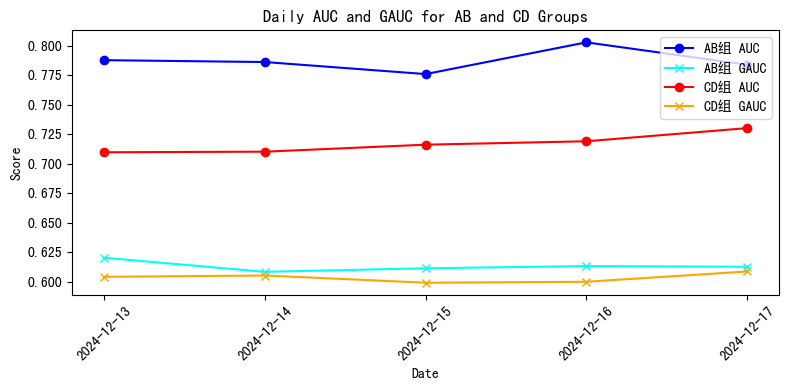

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

def calculate_daily_metrics(df):
    # 按日期分组计算每天的 AUC 和 GAUC
    daily_metrics = df.groupby('dt').apply(
        lambda x: pd.Series({
            'auc': roc_auc_score(x['label'], x['recall_score']),
            'gauc': cal_gauc(labels=x['label'], preds=x['recall_score'], user_id_list=x['recommend_id'])
        })
    ).reset_index()
    return daily_metrics

# 计算 AB 组和 CD 组的每日 AUC 和 GAUC
ab_daily_metrics = calculate_daily_metrics(AB_df)
cd_daily_metrics = calculate_daily_metrics(CD_df)

# 绘制折线图
plt.figure(figsize=(8, 4),dpi = 100)
plt.plot(ab_daily_metrics['dt'], ab_daily_metrics['auc'], label='AB组 AUC', marker='o', color='blue')
plt.plot(ab_daily_metrics['dt'], ab_daily_metrics['gauc'], label='AB组 GAUC', marker='x', color='cyan')
plt.plot(cd_daily_metrics['dt'], cd_daily_metrics['auc'], label='CD组 AUC', marker='o', color='red')
plt.plot(cd_daily_metrics['dt'], cd_daily_metrics['gauc'], label='CD组 GAUC', marker='x', color='orange')

plt.xlabel('Date')
plt.ylabel('Score')
plt.title('Daily AUC and GAUC for AB and CD Groups')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [102]:
ab_daily_metrics

,dt,auc,gauc
0,2024-10-12,0.7539,0.5898
1,2024-10-13,0.7801,0.5980
2,2024-10-14,0.7580,0.5998
3,2024-10-15,0.7622,0.6020
4,2024-10-16,0.7582,0.5893
5,2024-10-17,0.7715,0.5997
6,2024-10-18,0.7451,0.5738
7,2024-10-19,0.7475,0.5868
8,2024-10-20,0.7581,0.5880
9,2024-10-21,0.7534,0.5915


In [103]:
cd_daily_metrics

,dt,auc,gauc
0,2024-10-12,0.7530,0.5899
1,2024-10-13,0.7463,0.5857
2,2024-10-14,0.7273,0.5885
3,2024-10-15,0.7898,0.5950
4,2024-10-16,0.7617,0.6060
5,2024-10-17,0.7480,0.6045
6,2024-10-18,0.7659,0.5886
7,2024-10-19,0.7596,0.5836
8,2024-10-20,0.7611,0.5997
9,2024-10-21,0.7562,0.6007


# 实验分析

In [50]:
exp_start_date = '2024-10-12'
exp_last_date = '2024-10-21'
sample_sql = """
    select user_id
        ,clue_id
        ,recommend_id
        ,label
        ,ts as label_ts
    from g3_feature_dev.c2b_dssm_train_samples
    where dt between '{exp_start_date}' and '{exp_last_date}'
    and scene = 'SEARCH'
    and action = 'bid'
    and clue_id is not null
""".format(exp_start_date = exp_start_date, exp_last_date = exp_last_date)
df_sample = pd.read_sql_query(sample_sql, engine)

In [32]:
df_sample.head()

,user_id,clue_id,recommend_id,label,label_ts
0,611866559,137144341,c2a4102f-10d3-478e-a4f5-bcefaac9c9b7,1,1729398321
1,620275502,140241223,6e1af16e-4985-4929-ac90-fcb9b511e5a2,1,1729396810
2,787305270,140323054,66fb6121-5807-4b0e-b2c7-b6e3acf5735c,1,1729424386
3,616196576,139751648,068a124b-ef89-4efe-8484-016f5c4d24cf,1,1729433351
4,620282064,140211323,d19a7f02-458e-417c-8202-d28241ac3dfe,1,1729354777


In [51]:
score_sql = """
    select recommend_id
        ,cast(clue_id as int) clue_id
        ,cast(gz_user_id as int) user_id
        ,ab_group
        ,cast(recall_score as double) recall_score
        ,cast(rank_score as double) rank_score
        ,cast(postprocess_score as double) postprocess_score
    from gzlc_real.fact_ml_recommend_log_pipeline
    where dt between '{exp_start_date}' and '{exp_last_date}'
    and scene_id = 'c2b_today_seckill'
    and ab_group != 'closeRecommend'
    and postprocess_score != '0.0'
""".format(exp_start_date = exp_start_date, exp_last_date = exp_last_date)
df_score = pd.read_sql_query(score_sql, engine)

In [52]:
df_score.head()

,recommend_id,clue_id,user_id,ab_group,recall_score,rank_score,postprocess_score
0,bddec38c-b0e4-496f-b648-e855a9c22abc,140150510,601983471,D,0.1944,0.0211,0.0211
1,b89ae71c-e300-4951-8c1c-8c91ed910a6d,138812528,606715333,C,0.0028,0.0135,0.0135
2,b89ae71c-e300-4951-8c1c-8c91ed910a6d,140056516,606715333,C,0.0017,0.0115,0.0115
3,b89ae71c-e300-4951-8c1c-8c91ed910a6d,139123681,606715333,C,0.0024,0.0142,0.0142
4,7e93b6ae-8760-458e-9319-aa1ac92f5fc4,138125361,600320952,D,0.1146,0.0122,0.0122


In [53]:
df_merge = pd.merge(df_score, df_sample, on = ['recommend_id', 'clue_id', 'user_id'], how = 'left')
df_merge['rn'] = df_merge.groupby('recommend_id')['recall_score'].rank(method='first', ascending=False).astype(int)
group_lengths = df_merge.groupby('recommend_id')['rn'].transform('size')
df_merge['rn_normalized'] = df_merge['rn'] / group_lengths
df_sample.count()[0], df_score.count()[0], df_merge.count()[0]

(462579, 22418845, 22426930)

In [54]:
df_ab = df_merge[df_merge['ab_group'].isin(['A','B'])]
df_cd = df_merge[df_merge['ab_group'].isin(['C','D'])]

In [55]:
df_merge.dtypes

recommend_id          object
clue_id                int64
user_id                int64
ab_group              object
recall_score         float64
rank_score           float64
postprocess_score    float64
label                float64
label_ts             float64
rn                     int64
rn_normalized        float64
dtype: object

In [56]:
df_ab['recall_score'].mean(), df_cd['recall_score'].mean()

(0.44461297544343387, 0.07074220098405264)

In [57]:
df_merge[df_merge['label'] == 1].head(2)

,recommend_id,clue_id,user_id,ab_group,recall_score,rank_score,postprocess_score,label,label_ts,rn,rn_normalized
542,cf1e0f09-ec9a-481c-ae9d-2c486d653c3b,138217926,788225595,A,0.9867,0.0330,0.0330,1.0000,1729315383.0000,1,0.0003
648,254f4483-9cf1-4821-a355-66d011e1f063,139977208,769827301,C,0.9334,0.0505,0.0505,1.0000,1729349014.0000,2,0.0500


In [58]:
len(df_ab[df_ab['rn'] <= 1]['clue_id'].unique()), len(df_cd[df_cd['rn'] <= 1]['clue_id'].unique())

(34047, 28920)

In [59]:
df_ab[df_ab['rn'] <= 10]['label'].sum(), df_cd[df_cd['rn'] <= 10]['label'].sum()

(11824.0, 10933.0)

In [60]:
df_ab[df_ab['label'] == 1].count()[0], df_cd[df_cd['label'] == 1].count()[0]

(65765, 61362)

In [87]:
65765/61362

1.0717545060460871

In [94]:
df_ab[df_ab['label'] == 1]['rn'].median(), df_cd[df_cd['label'] == 1]['rn'].median()

(48.0, 45.0)

In [67]:
df_ab[df_ab['label'] == 1]['rn_normalized'].median(), df_cd[df_cd['label'] == 1]['rn_normalized'].median()

(0.4, 0.4)

In [93]:
df_ab['rn'].median(), df_cd['rn'].median()

(38.0, 35.0)

In [92]:
123.59213082825707/105.85020971994417

1.1676134714825226

In [82]:
df_ab[['recommend_id', 'rn']].groupby('recommend_id').max()['rn'].median()

20.0

# 新测算方法(实时计算之后不好用了)

In [4]:
# 取没有过滤条件的请求，取召回的topN然后看24h内 全站 出价人车对的数量

In [73]:
cur_date = '2024-12-15'
query_sql = """
    select cast(gz_user_id as int) user_id
        ,recommend_id
        ,ab_group
        ,ts/1000 ts
        ,dt
        ,CAST(json_extract(request_param, '$.otherFilter') AS VARCHAR) AS otherFilter
        ,CAST(json_extract(request_param, '$.pageIndex') AS VARCHAR) as pageIndex
        ,LENGTH(CAST(json_extract(request_param, '$.otherFilter') AS VARCHAR)) filter_length
    from gzlc_real.fact_ml_recommend_log_summary
    where dt = '{cur_date}' 
    and scene_id = 'c2b_today_seckill'
    AND ab_group != 'closeRecommend'
    and current_env = 'online'
    ORDER BY LENGTH(CAST(json_extract(request_param, '$.otherFilter') AS VARCHAR)) asc
""".format(cur_date = cur_date)
df_query = pd.read_sql_query(query_sql, engine)


In [192]:
df_query.count()[0]

95349

In [75]:
df_query.head(2)

,user_id,recommend_id,ab_group,ts,dt,otherFilter,pageIndex,filter_length
0,211774191,5fe228f8-4613-4ca0-98a1-da9ccde85f6f,A,1734231577,2024-12-15,"( city_id not in (-1) AND sale_status = 0 AND cars_tag not in (288,444,423,666,1092,1094) AND (( auction_type= 1 and show_time >1734105600 and show_time <= 1734192000) or (auction_type = 2) or (auction_type = 9) or (auction_type = 11 and auction_start_time <= 1734231577 and auction_end_time >= 1734231577))) AND ( cars_tag in (619,289) and (auction_type = 2) )",1,362
1,711319278,b245932d-a3c5-46c9-a860-8638d579dd94,B,1734232619,2024-12-15,"( city_id not in (-1) AND sale_status = 0 AND cars_tag not in (288,444,423,666,1092,1094) AND (( auction_type= 1 and show_time >1734192000 and show_time <= 1734278400) or (auction_type = 2) or (auction_type = 9) or (auction_type = 11 and auction_start_time <= 1734232619 and auction_end_time >= 1734232619))) AND ( cars_tag in (619,289) and (auction_type = 2) )",1,362


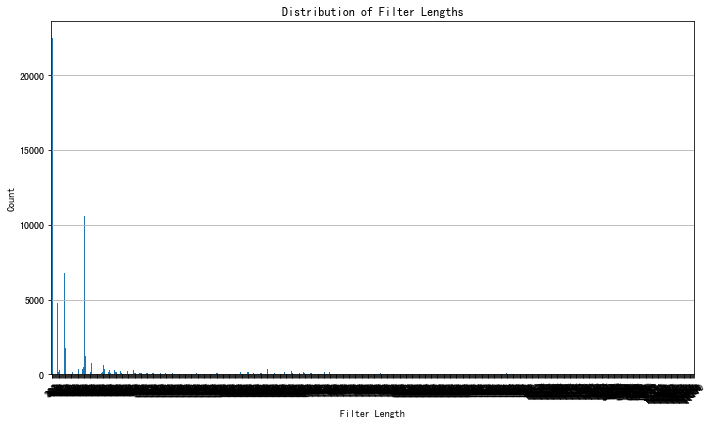

In [76]:
import pandas as pd
import matplotlib.pyplot as plt

# 假设df_query是您的DataFrame
# df_query = pd.read_csv('your_data.csv')  # 如果数据在CSV中，可以用这行代码读取

# 统计每个filter_length值的数量
filter_length_counts = df_query['filter_length'].value_counts().sort_index()

# 绘制柱状图
plt.figure(figsize=(10, 6))
filter_length_counts.plot(kind='bar')
plt.title('Distribution of Filter Lengths')
plt.xlabel('Filter Length')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y')

# 显示图形
plt.tight_layout()
plt.show()

## 没有多余filter的第一页请求(太少了)

In [77]:
# 没有多余filter的请求
df_pure_query = df_query[(df_query['filter_length'] == 383) & (df_query['pageIndex'] == '1')]
print(df_pure_query.count()[0])
df_pure_query = df_pure_query[['user_id', 'ts']]
df_pure_query.head(2)

10245


,user_id,ts
30,751699194,1734262319
32,612159852,1734199146


In [20]:
df_pure_query.dtypes

user_id    int64
ts         int64
dtype: object

## 加载新老emb

In [130]:
new_model_item_path = f'/home/jupyterhub/daiyuxuan/dssm_models_search/inference_data/item_embeddings1215.csv'
new_model_user_path = f'/home/jupyterhub/daiyuxuan/dssm_models_search/inference_data/user_embeddings1215.csv'
df_new_model_item = pd.read_csv(new_model_item_path)
df_new_model_user = pd.read_csv(new_model_user_path)
df_new_model_item = df_new_model_item.drop_duplicates(subset='clue_id', keep='first')
df_new_model_user = df_new_model_user.loc[df_new_model_user.groupby(['user_id',
                                         'recommend_id'])['ts'].idxmin()].reset_index(drop=True)


In [131]:
df_new_model_user.count()[0], df_new_model_item.count()[0]

(34341, 86324)

In [132]:
df_new_model_user.head(2)

,user_id,recommend_id,ts,user_embedding
0,14016,32bf82a9-ad93-4074-967f-25878eea5d28,1734247603,"[1.5681265592575073, -0.016651824116706848, -0.037318795919418335, -0.7121032476425171, -1.0829813480377197, 0.7742476463317871, -1.1066886186599731, -1.4761857986450195, 0.23940730094909668, 0.7702244520187378, 0.4926208257675171, -1.0791370868682861, 1.0693089962005615, -1.7394472360610962, -1.4274076223373413, -0.3469836115837097, -0.7640373110771179, -1.6538349390029907, 0.8488391637802124, 0.2146187722682953, 0.7223204374313354, 0.26556360721588135, -0.1687464565038681, -1.8631273508071..."
1,14016,32bf82a9-ad93-4074-967f-25878eea5d28.JIANLOUCHEYUAN,1734247806,"[1.3235528469085693, -0.18828223645687103, 0.0177038311958313, -1.1341973543167114, -1.3147000074386597, 0.3957583010196686, -0.9799779653549194, -1.7444547414779663, 1.0391666889190674, 1.0897953510284424, 0.7077921628952026, -0.8504409193992615, 0.8697652220726013, -1.1657524108886719, -1.4939950704574585, -0.20258356630802155, -0.9704728722572327, -1.8322546482086182, 0.8815187215805054, -0.12110377848148346, -0.25479140877723694, 0.6555907130241394, 0.34172654151916504, -2.27191805839538..."


In [133]:
df_new_model_item.head(2)

,clue_id,recommend_id,item_embedding
0,141267695,2b6a8959-492e-44ff-8535-76d477f03a61,"[0.2321847677230835, 0.20741625130176544, -0.26666754484176636, 0.427248477935791, 0.1519702970981598, 0.04533660411834717, -0.018121272325515747, 0.27235227823257446, -0.42968884110450745, -0.028528407216072083, -0.005320332944393158, -0.1875375509262085, 0.48813310265541077, -0.1376008689403534, 0.19151069223880768, -0.11809765547513962, 0.1754167377948761, -0.12046553939580917, -0.18172083795070648, 0.0084613636136055, -0.022302312776446342, 0.21572716534137726, 0.23866990208625793, 0.330..."
1,139882293,2b6a8959-492e-44ff-8535-76d477f03a61,"[0.07945399731397629, 0.7664543390274048, -0.4313783049583435, 0.6214677095413208, -0.2636100947856903, -0.1409064531326294, 0.070468008518219, 0.3218879699707031, -0.11738810688257217, -0.07101370394229889, -0.28219491243362427, -0.017439797520637512, 0.22495298087596893, -0.2716151475906372, 0.21830379962921143, 0.15765471756458282, 0.25267571210861206, -0.27438032627105713, -0.12944747507572174, 0.2340676635503769, -0.046123579144477844, -0.10431989282369614, 0.000738874077796936, 0.36622..."


In [134]:
import pandas as pd
import glob
import os
import ast
cur_date = '2024-12-15'
# 指定目录路径
# # 不加特征模型
# old_item_path = f'/home/jupyterhub/daiyuxuan/dssm_models_search/new_emb/item_{cur_date}'
# old_user_path = f'/home/jupyterhub/daiyuxuan/dssm_models_search/new_emb/user_{cur_date}'
# 线上模型
online_item_path = f'/home/jupyterhub/daiyuxuan/dssm_models_search/old_emb/item_{cur_date}'
online_user_path = f'/home/jupyterhub/daiyuxuan/dssm_models_search/old_emb/user_{cur_date}'
def load_csv(path):
    # 获取目录中所有CSV文件的路径
    csv_files = glob.glob(os.path.join(path, '*.csv'))
    # 读取所有CSV文件并合并成一个DataFrame
    df_list = [pd.read_csv(file, sep = '\t') for file in csv_files]
    combined_df = pd.concat(df_list, ignore_index=True)
    return combined_df
# df_old_model_item = load_csv(old_item_path)
# df_old_model_user = load_csv(old_user_path)
df_new_model_item['item_embedding'] = df_new_model_item['item_embedding'].apply(ast.literal_eval)
df_new_model_user['user_embedding'] = df_new_model_user['user_embedding'].apply(ast.literal_eval)

df_online_model_item = load_csv(online_item_path)
df_online_model_user = load_csv(online_user_path)

df_online_model_item[['clue_id', 'item_embedding']] = df_online_model_item['rank_score'].str.split(':', expand=True)
df_online_model_item['item_embedding'] = df_online_model_item['item_embedding'].apply(lambda x: list(map(float, x.split(','))))
df_online_model_item = df_online_model_item.drop(columns=['rank_score'])
df_online_model_user[['user_id', 'user_embedding']] = df_online_model_user['rank_score'].str.split(':', expand=True)
df_online_model_user['user_embedding'] = df_online_model_user['user_embedding'].apply(lambda x: list(map(float, x.split(','))))
df_online_model_user = df_online_model_user.drop(columns=['rank_score'])
df_new_model_item['clue_id'] = df_new_model_item['clue_id'].astype(int)
df_online_model_item['clue_id'] = df_online_model_item['clue_id'].astype(int)
df_new_model_user['user_id'] = df_new_model_user['user_id'].astype(int)
df_online_model_user['user_id'] = df_online_model_user['user_id'].astype(int)

In [135]:
df_new_model_user.count()[0], df_new_model_item.count()[0], \
df_online_model_user.count()[0], df_online_model_item.count()[0], 
# df_old_model_user.count()[0], df_old_model_item.count()[0], \


(34341, 86324, 149744, 102233)

In [138]:
df_new_model_user.head(2)

,user_id,recommend_id,ts,user_embedding
0,14016,32bf82a9-ad93-4074-967f-25878eea5d28,1734247603,"[1.5681265592575073, -0.016651824116706848, -0.037318795919418335, -0.7121032476425171, -1.0829813480377197, 0.7742476463317871, -1.1066886186599731, -1.4761857986450195, 0.23940730094909668, 0.7702244520187378, 0.4926208257675171, -1.0791370868682861, 1.0693089962005615, -1.7394472360610962, -1.4274076223373413, -0.3469836115837097, -0.7640373110771179, -1.6538349390029907, 0.8488391637802124, 0.2146187722682953, 0.7223204374313354, 0.26556360721588135, -0.1687464565038681, -1.8631273508071..."
1,14016,32bf82a9-ad93-4074-967f-25878eea5d28.JIANLOUCHEYUAN,1734247806,"[1.3235528469085693, -0.18828223645687103, 0.0177038311958313, -1.1341973543167114, -1.3147000074386597, 0.3957583010196686, -0.9799779653549194, -1.7444547414779663, 1.0391666889190674, 1.0897953510284424, 0.7077921628952026, -0.8504409193992615, 0.8697652220726013, -1.1657524108886719, -1.4939950704574585, -0.20258356630802155, -0.9704728722572327, -1.8322546482086182, 0.8815187215805054, -0.12110377848148346, -0.25479140877723694, 0.6555907130241394, 0.34172654151916504, -2.27191805839538..."


In [178]:
len(df_new_model_item['clue_id'].unique())

91842

In [111]:
df_new_model_item.head(2)

,clue_id,recommend_id,item_embedding
0,141267695,2b6a8959-492e-44ff-8535-76d477f03a61,"[0.2321847677230835, 0.20741625130176544, -0.26666754484176636, 0.427248477935791, 0.1519702970981598, 0.04533660411834717, -0.018121272325515747, 0.27235227823257446, -0.42968884110450745, -0.028528407216072083, -0.005320332944393158, -0.1875375509262085, 0.48813310265541077, -0.1376008689403534, 0.19151069223880768, -0.11809765547513962, 0.1754167377948761, -0.12046553939580917, -0.18172083795070648, 0.0084613636136055, -0.022302312776446342, 0.21572716534137726, 0.23866990208625793, 0.330..."
1,139882293,2b6a8959-492e-44ff-8535-76d477f03a61,"[0.07945399731397629, 0.7664543390274048, -0.4313783049583435, 0.6214677095413208, -0.2636100947856903, -0.1409064531326294, 0.070468008518219, 0.3218879699707031, -0.11738810688257217, -0.07101370394229889, -0.28219491243362427, -0.017439797520637512, 0.22495298087596893, -0.2716151475906372, 0.21830379962921143, 0.15765471756458282, 0.25267571210861206, -0.27438032627105713, -0.12944747507572174, 0.2340676635503769, -0.046123579144477844, -0.10431989282369614, 0.000738874077796936, 0.36622..."


In [46]:
def cal_metrics(df_query, df_user, df_item, topn = 400):
    print('请求数: {}'.format(df_query.count()[0]))
    df_query = pd.merge(df_query, df_user, on = 'user_id')
    print('用户请求数: {}'.format(df_query.count()[0]))
    user_embedding_matrix = np.array(df_query['user_embedding'].tolist())
    item_embedding_matrix = np.array(df_old_item['item_embedding'].tolist())
    result_matrix = np.dot(user_embedding_matrix, item_embedding_matrix.T)
    print(user_embedding_matrix.shape, item_embedding_matrix.shape, result_matrix.shape)
    top_indices = np.argsort(-result_matrix, axis=1)[:, :topn]
    # 根据 top_indices 从 df_old_item 中获取 clue_id
    top_clue_ids = []
    for row_indices in top_indices:
        clue_ids = df_item.iloc[row_indices]['clue_id'].tolist()
        top_clue_ids.append(clue_ids)
    df_query['top_clue_ids'] = top_clue_ids
    return df_query
df_query = cal_metrics(df_query = df_pure_query, df_user = df_new_user, df_item = df_new_item)

请求数: 8493
用户请求数: 8274
(8274, 32) (109305, 32) (8274, 109305)


In [47]:
df_query.count()

user_id           8274
ts                8274
user_embedding    8274
top_clue_ids      8274
dtype: int64

## 曝光出价人车对

In [163]:
sql_search = """
select clue_id
    ,user_id
    ,recommend_id
    ,ts
    ,1 as is_beseen
    ,is_click
    ,is_bid
    ,is_daojia80
    ,is_daojia90
    ,is_daojia100
    ,is_order
from g3_feature_dev.c2b_mtl_sample_v1  
where part='test' 
and page_type='SEARCH' 
and dt = '{cur_date}'
""".format(cur_date = cur_date)
df_search = pd.read_sql_query(sql_search, engine)

In [164]:
df_search.count()[0], df_query.count()[0]

(1414931, 95349)

In [174]:
df_search.head(2)

,clue_id,user_id,recommend_id,ts,is_beseen,is_click,is_bid,is_daojia80,is_daojia90,is_daojia100,is_order
0,140069938,623008953,4926de46-4e88-4cd6-905a-81c4ab3ccebb,1729960923,1,0,0,0,0,0,0
1,139772657,603622035,b6d874ac-f4a9-4f6a-a9eb-15a59aa1b02d,1730006689,1,0,0,0,0,0,0


In [139]:
df_query.head(2)

,user_id,recommend_id,ab_group,ts,dt,otherFilter,pageIndex,filter_length
0,211774191,5fe228f8-4613-4ca0-98a1-da9ccde85f6f,A,1734231577,2024-12-15,"( city_id not in (-1) AND sale_status = 0 AND cars_tag not in (288,444,423,666,1092,1094) AND (( auction_type= 1 and show_time >1734105600 and show_time <= 1734192000) or (auction_type = 2) or (auction_type = 9) or (auction_type = 11 and auction_start_time <= 1734231577 and auction_end_time >= 1734231577))) AND ( cars_tag in (619,289) and (auction_type = 2) )",1,362
1,711319278,b245932d-a3c5-46c9-a860-8638d579dd94,B,1734232619,2024-12-15,"( city_id not in (-1) AND sale_status = 0 AND cars_tag not in (288,444,423,666,1092,1094) AND (( auction_type= 1 and show_time >1734192000 and show_time <= 1734278400) or (auction_type = 2) or (auction_type = 9) or (auction_type = 11 and auction_start_time <= 1734232619 and auction_end_time >= 1734232619))) AND ( cars_tag in (619,289) and (auction_type = 2) )",1,362


In [140]:
def filter_rows(row):
    # 检查 clue_id 是否在 top_clue_ids 中，并且 ts 的差值不超过 86400
    return row['clue_id'] in row['top_clue_ids'] and (row['ts_search'] - row['ts_query']) <= 86400
# 合并两个 DataFrame
merged_df = pd.merge(df_search, df_query, on='user_id', suffixes=('_search', '_query'))
filtered_df = merged_df[merged_df.apply(filter_rows, axis=1)]
filtered_df.head()

KeyboardInterrupt: 

In [51]:
filtered_df.count()[0], filtered_df['is_click'].sum(), filtered_df['is_bid'].sum()

(19467, 584, 89)

## 选出全部车商的top100车源

In [165]:
# df_search['user_id'].unique()
df_active = df_search[['user_id', 'recommend_id']].drop_duplicates()

In [166]:
df_active.count()

user_id         34341
recommend_id    34341
dtype: int64

In [167]:
df_active.head()

,user_id,recommend_id
0,712436893,1db5fe15-be83-4a53-9d4e-7001d6ec1f45
1,802441434,a172e9be-1abb-4287-b6fe-6c4241c8b5eb
2,766613159,3924e455-92dc-4897-90ac-7bda66acb354
3,604134618,3f41c7a6-a942-4150-9e2b-f180588e67b9
4,605197075,b7e52b52-d85b-4b90-9f08-21e38319b1eb


In [168]:
def cal_metrics(df_active, df_user, df_item, topn = 400):
    df_active = pd.merge(df_active, df_user, on = 'user_id')
    print('活跃用户数: {}'.format(df_active.count()[0]))
    user_embedding_matrix = np.array(df_active['user_embedding'].tolist())
    item_embedding_matrix = np.array(df_item['item_embedding'].tolist())
    result_matrix = np.dot(user_embedding_matrix, item_embedding_matrix.T)
    print(user_embedding_matrix.shape, item_embedding_matrix.shape, result_matrix.shape)
    top_indices = np.argsort(-result_matrix, axis=1)[:, :topn]
    # 根据 top_indices 从 df_old_item 中获取 clue_id
    top_clue_ids = []
    for row_indices in top_indices:
        clue_ids = df_item.iloc[row_indices]['clue_id'].tolist()
        top_clue_ids.append(clue_ids)
    df_active['top_clue_ids'] = top_clue_ids
    return df_active

def cal_metrics_new(df_active, df_user, df_item, topn = 400):
    df_active = pd.merge(df_active, df_user, on = ['user_id', 'recommend_id'])
    print('活跃用户、请求数: {}'.format(df_active.count()[0]))
    user_embedding_matrix = np.array(df_active['user_embedding'].tolist())
    item_embedding_matrix = np.array(df_item['item_embedding'].tolist())
    result_matrix = np.dot(user_embedding_matrix, item_embedding_matrix.T)
    print(user_embedding_matrix.shape, item_embedding_matrix.shape, result_matrix.shape)
    top_indices = np.argsort(-result_matrix, axis=1)[:, :topn]
    # 根据 top_indices 从 df_old_item 中获取 clue_id
    top_clue_ids = []
    for row_indices in top_indices:
        clue_ids = df_item.iloc[row_indices]['clue_id'].tolist()
        top_clue_ids.append(clue_ids)
    df_active['top_clue_ids'] = top_clue_ids
    return df_active

In [169]:
df_user_topNcar_new = cal_metrics_new(df_active = df_active, df_user = df_new_model_user, df_item = df_new_model_item)
df_user_topNcar_online = cal_metrics(df_active = df_active, df_user = df_online_model_user, df_item = df_online_model_item)


活跃用户、请求数: 34341
(34341, 32) (86324, 32) (34341, 86324)
活跃用户数: 34204
(34204, 32) (102233, 32) (34204, 102233)


In [188]:
unique_combinations = df_user_topNcar_online[['user_id', 'recommend_id']].drop_duplicates()

# 打印独特组合的数量
print("独特的 'user_id' 和 'recommend_id' 组合数量:", unique_combinations.shape[0])

独特的 'user_id' 和 'recommend_id' 组合数量: 34204


In [185]:
df_user_topNcar_new.count()[0], df_user_topNcar_online.count()[0]

(34341, 34204)

In [190]:
df_user_topNcar_online.head(1)


,user_id,recommend_id,user_embedding,top_clue_ids
0,712436893,1db5fe15-be83-4a53-9d4e-7001d6ec1f45,"[-0.64452916, 0.67455614, -0.04895992, 0.14203829, -0.923087, 0.11491574, -0.45495835, -0.54571927, -0.23910433, 0.53419125, -0.6005487, 0.54868454, -0.77889943, -0.6861652, -0.062209275, -0.38148925, 1.3898348, 0.6052507, 0.098774016, -0.035431787, 0.051143687, -1.4017746, 0.036782198, -1.4936032, 0.7212708, 0.69489545, 0.039567243, 0.25701082, 0.6705836, -0.30904406, 0.2065897, -0.050664578]","[141423476, 142699063, 143248163, 141239315, 142494836, 141816275, 140081678, 139636802, 143241705, 142362756, 141771630, 141294059, 140560776, 141780427, 143105248, 137011559, 142755445, 140429261, 141945972, 141291966, 141558667, 142574646, 140556635, 139674734, 142596137, 141232173, 141277713, 140817885, 141457309, 140933866, 140421976, 141822285, 143089169, 142829883, 143168602, 143208356, 140555491, 138631399, 140429518, 142248006, 141064443, 142831338, 143290398, 142291644, 140789049, ..."


In [172]:
# 将所有 top_clue_ids 展平为一个集合
unique_clue_ids = set(clue_id for sublist in df_user_topNcar_new['top_clue_ids'] for clue_id in sublist)

# 计算不同 clue_id 的数量
unique_clue_id_count = len(unique_clue_ids)

# 显示结果
print("Number of unique clue_ids:", unique_clue_id_count)

Number of unique clue_ids: 49244


In [173]:
# 将所有 top_clue_ids 展平为一个集合
unique_clue_ids = set(clue_id for sublist in df_user_topNcar_online['top_clue_ids'] for clue_id in sublist)

# 计算不同 clue_id 的数量
unique_clue_id_count = len(unique_clue_ids)

# 显示结果
print("Number of unique clue_ids:", unique_clue_id_count)

Number of unique clue_ids: 56418


In [22]:
df_user_topNcar_new.count()[0]

6264

In [154]:
df_user_topNcar_new.head()

,user_id,recommend_id,ts,user_embedding,top_clue_ids
0,267346073,6a8e95ff-fd08-4fcf-8ebc-ae981f0e226f,1734192002,"[0.15906748175621033, -0.027765929698944092, 0.06884312629699707, -0.3092444837093353, -1.3297369480133057, -0.9847005605697632, 0.09574833512306213, -1.7720162868499756, 1.433500051498413, 0.02464858442544937, -0.5570537447929382, -1.29443359375, 0.6784713268280029, -0.35761505365371704, -0.5625734329223633, -0.8571357727050781, -0.032575711607933044, -0.7523289322853088, 1.0794934034347534, -0.8338583111763, -0.7925724983215332, -0.0859881117939949, 0.7151637673377991, -0.6498816013336182,...","[142406952, 143247260, 143106348, 143325283, 143226274, 143173017, 143381183, 143219222, 143213659, 142935824, 143284231, 143404962, 141698446, 141766551, 142874995, 142766732, 143230830, 140161945, 143405070, 140033577, 143159871, 143086113, 142887689, 142759510, 142602821, 143396792, 142601366, 142828189, 143169030, 143122737, 143229462, 142982063, 142822350, 143177243, 143031455, 143374050, 142599154, 141394863, 142975103, 143042452, 143056534, 143032635, 142398608, 140187398, 142930256, ..."
1,267346073,6a8e95ff-fd08-4fcf-8ebc-ae981f0e226f.JIANLOUCHEYUAN,1734192585,"[0.8947017788887024, -0.3244026005268097, -0.06984591484069824, -0.08358278125524521, -2.9444363117218018, -1.5469306707382202, -0.4891049861907959, -3.0869991779327393, 1.475274920463562, -0.7412281632423401, -0.2371245175600052, -1.7488716840744019, 2.0970582962036133, -0.8026431798934937, -1.4532710313796997, -1.3675397634506226, -0.5163269639015198, -0.577876091003418, 1.5643354654312134, -0.6920791864395142, -2.270632266998291, 0.6959863305091858, 0.9818944931030273, -1.7526836395263672...","[142935824, 142813593, 142540389, 141260023, 143247260, 142398608, 140561640, 143106348, 142828189, 143226274, 140707202, 143344190, 142185730, 143093467, 143284231, 140095010, 142812711, 139532893, 141397472, 140458854, 142772380, 143032635, 143335119, 142981599, 142490460, 139403518, 143213659, 143169030, 141394863, 143103550, 139878497, 142339914, 143115465, 142545037, 140033577, 139500376, 143159871, 140561207, 143381664, 142114442, 143116320, 140887142, 143242641, 139642876, 142976423, ..."
2,611625216,5a690e80-e205-4164-bf63-241ac8446030,1734264545,"[0.4852088689804077, -0.10647005587816238, -1.1643000841140747, 1.087158203125, -1.5332900285720825, -0.03288155794143677, 0.8399733901023865, -0.4758481979370117, -0.9483337998390198, -0.08038372546434402, 0.34322792291641235, -1.0589804649353027, 1.6003965139389038, 2.0730576515197754, 0.05308311805129051, -0.6295349597930908, 1.4049959182739258, -0.38934746384620667, -1.0440783500671387, -2.6859421730041504, 0.3893265426158905, -0.30958324670791626, 0.8299124240875244, -2.3693959712982178...","[143247017, 142177777, 142904612, 143268474, 142656912, 141603425, 142754792, 143030672, 143051420, 142176286, 143204111, 143157630, 142388225, 142828824, 142712181, 141548514, 140061726, 142951723, 140209241, 142821189, 143058247, 141331286, 143256907, 143144356, 143039835, 143055454, 141043617, 142951133, 142690401, 143141854, 143156654, 140743733, 141340662, 141332304, 141209592, 140850867, 142714219, 139918549, 143175809, 140814765, 143035320, 143083363, 143033222, 141775835, 142008011, ..."
3,611625216,96fbfa0e-3867-4b92-a37b-56d7fbce9982,1734269229,"[0.36112937331199646, -0.1301899552345276, -0.9910387992858887, 1.737385869026184, -1.7122232913970947, -0.4919486343860626, 0.5382803678512573, -0.911149799823761, -0.5244491696357727, -0.5408490896224976, -0.024850554764270782, -1.0565156936645508, 1.8790003061294556, 1.3788957595825195, 0.3873548209667206, -0.3696950674057007, 1.0713269710540771, 0.029121309518814087, -1.4377026557922363, -2.7068240642547607, 0.7468705177307129, 0.2825615108013153, 1.1705056428909302, -3.3788325786590576,...","[143247017, 142904612, 142177777, 142754792, 140061726, 142176286, 142656912, 143268474, 141209592, 142828824, 143204111, 143051420, 143030672, 143055454, 142712181, 141603425, 

In [179]:
def filter_rows(row):
    # 检查 clue_id 是否在 top_clue_ids 中，并且 ts 的差值不超过 86400
    return row['clue_id'] in row['top_clue_ids']
# 合并两个 DataFrame

df_new_model_emb = pd.merge(df_search, df_user_topNcar_new, on = ['user_id', 'recommend_id'])
df_online_model_emb = pd.merge(df_search, df_user_topNcar_online, on = ['user_id', 'recommend_id'])
df_new_model_filtered = df_new_model_emb[df_new_model_emb.apply(filter_rows, axis=1)]
df_online_model_filtered = df_online_model_emb[df_online_model_emb.apply(filter_rows, axis=1)]

In [196]:
df_new_model_filtered.head(1)

,clue_id,user_id,recommend_id,ts_x,is_beseen,is_click,is_bid,is_daojia80,is_daojia90,is_daojia100,is_order,ts_y,user_embedding,top_clue_ids
6,140852859,712436893,1db5fe15-be83-4a53-9d4e-7001d6ec1f45,1734223139,1,1,0,0,0,0,0,1734223100,"[-0.009862994775176048, -2.017947196960449, -0.8043763637542725, 0.8236552476882935, 0.8079524636268616, -0.6927611231803894, 0.08227530121803284, 1.817420244216919, -1.4368040561676025, 0.020993873476982117, -0.545153796672821, -0.4857637286186218, 0.7238427400588989, 1.2871408462524414, 1.0569100379943848, 0.5452135801315308, 0.35344356298446655, 1.4990183115005493, -1.823390245437622, 0.4804784059524536, 1.789466142654419, -1.3455256223678589, 0.01007986068725586, -3.211367130279541, 2.53...","[142406952, 143211272, 142719030, 143231358, 143169086, 143302418, 143210084, 141899402, 143305395, 143371366, 140432550, 142872642, 143208823, 140500375, 142998698, 143237035, 142763803, 143240841, 142628279, 143253925, 143255293, 143099796, 143208146, 142144291, 143327572, 141376500, 142567271, 143177275, 141990714, 143183141, 143372510, 143332514, 143090387, 142777111, 143397339, 143390174, 143112520, 137592890, 141001174, 139835098, 142867731, 143114275, 143257387, 141853627, 143048292, ..."


In [191]:
df_new_model_emb.count()[0], df_online_model_emb.count()[0]

(1414931, 1412383)

In [184]:
df_new_model_filtered.count()[0], df_online_model_filtered.count()[0]

(201390, 84468)

In [182]:
df_new_model_filtered['is_click'].sum(), df_online_model_filtered['is_click'].sum()

(14129, 5603)

In [183]:
df_new_model_filtered['is_bid'].sum(), df_online_model_filtered['is_bid'].sum()

(2745, 1377)

## 模拟10-15召回分

In [126]:
cur_date = '2024-10-15'
sql_online_score = """
select cast(gz_user_id as int) user_id
    ,recommend_id
    ,cast(clue_id as int) clue_id
    ,cast(recall_score as double) recall_score
    ,ab_group
from
  gzlc_real.fact_ml_recommend_log_pipeline
where dt = '{cur_date}' 
and scene_id = 'c2b_today_seckill'
and strategy_id != '231'
and postprocess_score > '0.0'
and current_env = 'online'
and recall_strategy = 'C2bDssmRecall'
""".format(cur_date = cur_date)

sql_label = """
select clue_id
    ,user_id
    ,recommend_id
    ,ts
    ,is_bid as label
from g3_feature_dev.c2b_mtl_sample_v1  
where part='test' 
and page_type='SEARCH' 
and dt = '{cur_date}'
""".format(cur_date = cur_date)

In [127]:
# 保存pipeline分数
df_online_score = pd.read_sql_query(sql_online_score, engine)
df_online_score.to_csv('/home/jupyterhub/daiyuxuan/dssm_models_search/pipeline_score1015.csv',sep='\t')

In [128]:
df_online_score = pd.read_csv('/home/jupyterhub/daiyuxuan/dssm_models_search/pipeline_score1015.csv',sep='\t', index_col=0)
df_label = pd.read_sql_query(sql_label, engine)
online_df = pd.merge(df_label, df_online_score, on = ['user_id', 'recommend_id', 'clue_id'])
df_label.count()[0], df_online_score.count()[0], online_df.count()[0]

(1664670, 2231595, 1614380)

In [129]:
import glob
import os
# 指定目录路径
directory_path = '/home/jupyterhub/daiyuxuan/dssm_models_search/user_{}'.format(cur_date)
csv_files = glob.glob(os.path.join(directory_path, '*.csv'))
df_list = [pd.read_csv(file, sep = '\t') for file in csv_files]
user_embedding = pd.concat(df_list, ignore_index=True)

directory_path = '/home/jupyterhub/daiyuxuan/dssm_models_search/item_{}'.format(cur_date)
csv_files = glob.glob(os.path.join(directory_path, '*.csv'))
df_list = [pd.read_csv(file, sep = '\t') for file in csv_files]
item_embedding = pd.concat(df_list, ignore_index=True)

In [130]:
online_df.head()

,clue_id,user_id,recommend_id,ts,label,recall_score,ab_group
0,138210481,739526026,7ba44e0b-1680-47df-9720-0dfad13aa936,1728967484,0,0.0014,D
1,139880334,601993313,9db1f035-d4e8-4151-a0ae-e25823d230fa,1728991785,0,0.3777,B
2,137683722,617021782,013b5670-60cb-4bf3-b723-71db04283ce5,1729004688,0,0.0024,D
3,139559603,740879318,5b8d2cf7-38f4-47ce-b8cc-fa318cf1ae55,1729001359,0,0.0411,C
4,139559603,740879318,5b8d2cf7-38f4-47ce-b8cc-fa318cf1ae55,1729001359,0,0.0411,C


In [131]:
new_df = pd.merge(online_df, user_embedding, on = 'user_id')
new_df = pd.merge(new_df, item_embedding, on = 'clue_id')
import ast
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
new_df['user_embedding'] = new_df['user_embedding'].apply(ast.literal_eval).apply(np.array)
new_df['item_embedding'] = new_df['item_embedding'].apply(ast.literal_eval).apply(np.array)

new_df['score'] = new_df.apply(lambda row: sigmoid(np.dot(row['user_embedding'], row['item_embedding'])), axis=1)


new_df.head()

,clue_id,user_id,recommend_id,ts,label,recall_score,ab_group,user_embedding,item_embedding,score
0,138210481,739526026,7ba44e0b-1680-47df-9720-0dfad13aa936,1728967484,0,0.0014,D,"[0.31407079100608826, 0.30329617857933044, 0.07569245249032974, 0.33639925718307495, -0.081647127866745, -0.7239711284637451, -0.49311208724975586, -0.10364668071269989, -0.24897104501724243, -1.2828917503356934, 2.4625539779663086, 0.2883272171020508, -0.5527091026306152, -0.4230341911315918, -1.1147936582565308, -0.13096797466278076, -0.06567656248807907, -0.1444912850856781, 0.25614824891090393, 0.8111385107040405, -0.36242949962615967, 0.15741431713104248, -0.8262472748756409, -0.0428523...","[0.06537254899740219, 1.1096432209014893, 0.4907960891723633, 0.4797358512878418, -0.5487896800041199, 0.19383643567562103, 1.3643779754638672, 0.12149569392204285, 0.025484666228294373, 1.8486762046813965, 0.22032704949378967, -0.6593835353851318, -0.4659443497657776, -0.20840322971343994, -0.7081843614578247, -0.518723726272583, 0.6950932145118713, 0.9788321256637573, -1.3805235624313354, 0.07943978905677795, -0.0730631947517395, -0.3478976786136627, 0.8637986183166504, -0.4052216708660126...",0.1456
1,138210481,611431225,556e2a6c-7f58-4e19-8b4d-9fb30a1ff9dc,1728977009,0,0.0655,C,"[-0.27447208762168884, 0.9121623039245605, 0.048659007996320724, 0.38644084334373474, 0.13081836700439453, -1.112127661705017, -0.7433330416679382, 0.4414137899875641, -0.3707157373428345, -1.0291271209716797, 2.860163450241089, 0.20764222741127014, -0.7086148262023926, -0.581110417842865, -1.403572678565979, 0.08647400140762329, 0.11760088056325912, -0.15671265125274658, -0.4762321710586548, 1.2123472690582275, 0.07817306369543076, 0.1624368280172348, -1.0795540809631348, -0.097972936928272...","[0.06537254899740219, 1.1096432209014893, 0.4907960891723633, 0.4797358512878418, -0.5487896800041199, 0.19383643567562103, 1.3643779754638672, 0.12149569392204285, 0.025484666228294373, 1.8486762046813965, 0.22032704949378967, -0.6593835353851318, -0.4659443497657776, -0.20840322971343994, -0.7081843614578247, -0.518723726272583, 0.6950932145118713, 0.9788321256637573, -1.3805235624313354, 0.07943978905677795, -0.0730631947517395, -0.3478976786136627, 0.8637986183166504, -0.4052216708660126...",0.7340
2,138210481,620530780,7a4d8f12-23c2-4ffa-bc97-2e3b7a6d2d10,1728957603,0,0.1560,D,"[-0.6649870872497559, 0.9409000873565674, -0.7004668116569519, 1.0464338064193726, 0.5320847034454346, -1.0101364850997925, -0.6687295436859131, -0.37504300475120544, -0.046675920486450195, -0.8851651549339294, 2.0861761569976807, 0.11542066931724548, -0.29140254855155945, -0.8020471334457397, 0.21428591012954712, 1.162455677986145, 0.4214039146900177, -0.5301979184150696, 0.1455218344926834, 0.4431683421134949, 0.5248838067054749, 0.3809379041194916, -1.138205647468567, 0.9192980527877808, ...","[0.06537254899740219, 1.1096432209014893, 0.4907960891723633, 0.4797358512878418, -0.5487896800041199, 0.19383643567562103, 1.3643779754638672, 0.12149569392204285, 0.025484666228294373, 1.8486762046813965, 0.22032704949378967, -0.6593835353851318, -0.4659443497657776, -0.20840322971343994, -0.7081843614578247, -0.518723726272583, 0.6950932145118713, 0.9788321256637573, -1.3805235624313354, 0.07943978905677795, -0.0730631947517395, -0.3478976786136627, 0.8637986183166504, -0.4052216708660126...",0.0154
3,138210481,762552819,58f8d51b-bd27-48fd-a3c7-cd545956cd88,1728998798,0,0.0004,D,"[0.3363315165042877, -0.44200262427330017, 0.25270819664001465, -0.30234673619270325, 0.19445326924324036, -0.3350329101085663, -0.8509358763694763, -0.44592341780662537, -0.30655214190483093, -1.5886836051940918, 0.4820338785648346, -0.42085161805152893, -0.149612158536911, 0.019433163106441498, 0.43656212091445923, 0.08699377626180649, -1.1559089422225952, -1.5496151447296143, -0.26891249418258667, 0.20984312891960144, -0.08645323663949966, -0.1379796266555786, -0.3525829017162323, 0.06102...","[0.06537254899740219, 1.1096432209014893, 0

In [132]:
new_df = pd.merge(online_df, user_embedding, on = 'user_id')
print(new_df.count()[0])
new_df = pd.merge(new_df, item_embedding, on = 'clue_id')
print(new_df.count()[0])

1591332
1522241


In [133]:
# 10-15结果
gauc = cal_gauc(labels = new_df['label'], preds = new_df['recall_score'], user_id_list = new_df['user_id'])
auc = round(roc_auc_score(new_df['label'], new_df['recall_score']), 4)
print('线上测试auc:{}, gauc:{}'.format(auc, gauc))
gauc = cal_gauc(labels = new_df['label'], preds = new_df['score'], user_id_list = new_df['user_id'])
auc = round(roc_auc_score(new_df['label'], new_df['score']), 4)
print('新向量测试auc:{}, gauc:{}'.format(auc, gauc))

线上测试auc:0.7223, gauc:0.604


KeyError: 'score'